### Setting Up the Environment
We started by importing all the necessary libraries and modules required for data handling, preprocessing, visualization, and building our PyTorch model.

- **Data Handling & Preprocessing**: Libraries like `pandas`, `numpy`, and `pickle` are used for data manipulation and loading.
- **Visualization**: Libraries like `matplotlib` and `seaborn` are used for creating plots and visualizing data trends.
- **Machine Learning Utilities**: We use `sklearn` for scaling, encoding, and evaluating metrics.
- **PyTorch**: The core library for building and training our deep learning model.
- **Time Series Analysis**: `statsmodels` is used for autocorrelation and partial autocorrelation analysis.
- **Reproducibility**: We set random seeds to ensure consistent results across runs.
- **Device Configuration**: We check if a GPU is available and configure PyTorch to use it for faster computations.

In [1]:
# Data Handling & Preprocessing
import pandas as pd
import numpy as np
import pickle
import ast
from datetime import timedelta
import random
import gc
import time # For timing
from tqdm import tqdm
import os

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence # For padding


#Correlation plots
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 6) # Default figure size

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Loading the Dataset
In this step, we access our dataset which is stored as a pickle file. The dataset contains movie box office performance data that we'll use to build our forecasting model.

- **Dataset Loading**: We use `pd.read_pickle()` to load our preprocessed dataset and include error handling to provide meaningful feedback if the file can't be loaded.
- **Key Column Definition**: After loading the data, we define important columns that we'll be working with throughout the notebook:
  - `MOVIE_ID_COLUMN`: Identifies each unique movie in the dataset
  - `DATE_COLUMN`: Contains the observation date for each record
  - `DAYS_RELEASE_COLUMN`: Indicates the number of days since a movie was released
  - `TARGET_COLUMN`: The daily gross revenue that we aim to predict

If the dataset loads successfully, we'll be ready to proceed with exploration and preprocessing. If not, the script will exit gracefully with an error message.

In [ ]:

try:
    # commented line used to load data from Google Drive
    # df = pd.read_pickle("/content/drive/MyDrive/full_dataset_with_small_embeddings.pkl")
    df = pd.read_pickle("http://drive.google.com/uc?export=download&id=1lCD1dZ9KFYM5UT9EMxYpYXdCh9cTT3i9")
    print("Loaded data from pickle.")
except Exception as e:
    print(f"Error loading pickle: {e}")
    # Add fallback or exit if necessary
    raise SystemExit("Could not load data.")


# Configuration
MOVIE_ID_COLUMN = 'Movie Title_x' # Unique movie identifier
DATE_COLUMN = 'Date'              # Daily date column
DAYS_RELEASE_COLUMN = 'Days In Release' # Days in release column
TARGET_COLUMN = 'Gross'           # Daily gross column to predict

### Initial Data Preprocessing
In this step, we begin transforming our raw data into a format suitable for modeling. This involves several key cleaning operations to ensure data quality and consistency.

We will:
1. **Create a working copy** of our data to preserve the original dataset
2. **Convert date fields** to proper datetime format for easy manipulation
3. **Handle numeric conversions** for key columns like 'Days In Release' and our target variable 'Gross'
4. **Process categorical data** like the 'adult' flag to ensure it's in a consistent numeric format

These cleaning steps are essential for our time-series forecasting model, as they ensure our data is properly typed and free from missing or invalid values in critical columns.

In [ ]:
# Create a copy of the original DataFrame for processing.
df_processed = df.copy()

# Initial Cleaning & Type Conversion 
# Convert date columns to datetime format and drop rows with invalid primary dates.
try:
    df_processed[DATE_COLUMN] = pd.to_datetime(df_processed[DATE_COLUMN], errors='coerce')
    df_processed['domestic_release_date'] = pd.to_datetime(df_processed['domestic_release_date'], errors='coerce')
    if 'release_date' in df_processed.columns:
         df_processed['release_date'] = pd.to_datetime(df_processed['release_date'], errors='coerce')
    date_na_before = df_processed[DATE_COLUMN].isnull().sum()
    df_processed.dropna(subset=[DATE_COLUMN], inplace=True)
except Exception as e:
    print(f"Warning: Could not parse all date columns. Error: {e}")

# Convert 'Days In Release' to numeric, drop rows with invalid values, and cast the column to integer.
df_processed[DAYS_RELEASE_COLUMN] = pd.to_numeric(df_processed[DAYS_RELEASE_COLUMN], errors='coerce')
days_na_before = df_processed[DAYS_RELEASE_COLUMN].isnull().sum()
df_processed.dropna(subset=[DAYS_RELEASE_COLUMN], inplace=True)
df_processed[DAYS_RELEASE_COLUMN] = df_processed[DAYS_RELEASE_COLUMN].astype(int)

# Convert 'adult' column to numeric (0/1) if it exists and is of object type.
if 'adult' in df_processed.columns and df_processed['adult'].dtype == 'object':
    df_processed['adult'] = df_processed['adult'].astype(str).str.lower().map({'false': 0, 'true': 1, 'nan': np.nan})

# Convert the target 'Gross' column to numeric and drop rows with invalid values.
df_processed[TARGET_COLUMN] = pd.to_numeric(df_processed[TARGET_COLUMN], errors='coerce')
gross_na_before = df_processed[TARGET_COLUMN].isnull().sum()
df_processed.dropna(subset=[TARGET_COLUMN], inplace=True)

### Ensuring Chronological Ordering
For time-series analysis, proper ordering of data points is critical. In this step, we sort our dataset to maintain chronological consistency for each movie's box office performance data.

We sort the dataframe by:
1. **Movie ID**: To group all entries for the same movie together
2. **Date**: To arrange each movie's daily performance data in chronological order

After sorting, we reset the index to maintain a clean, sequential numbering of rows. This ordering is essential for our subsequent steps, especially when we create lagged features and analyze temporal patterns in the data.

In [ ]:
# Ensure Sorting
# Sort the DataFrame by movie identifier and date, then reset the index.
df_processed.sort_values(by=[MOVIE_ID_COLUMN, DATE_COLUMN], inplace=True)
df_processed.reset_index(drop=True, inplace=True)

### Handling Missing Static Features
Movies have many attributes that remain constant throughout their theatrical run - these are what we call "static features." Examples include director, budget, genre, and production companies. In this step, we implement a comprehensive strategy to handle missing values in these static features.

Our approach includes:

1. **Group-Based Imputation**: For each movie, we propagate known values to fill in missing values within the same group. This uses both forward-fill (ffill) and backward-fill (bfill) techniques.

2. **Global Imputation**: For any remaining missing values after group imputation, we apply type-specific strategies:
   - For numerical columns (like budget): We use the global median value
   - For categorical text columns: We use the placeholder 'Unknown'
   - For list-like columns: We use an empty list ('[]')
   - For boolean flags: We use the mode (most common value) or default to 0

This careful treatment of missing values ensures we maintain as much information as possible while providing sensible defaults that won't distort our analysis or model training.

In [ ]:
# Handle Missing Static Features
# Identify static columns that are expected to remain constant within each movie group.
static_cols_candidates = [
    'Distributor', 'director', 'running_time', 'genre', 'adult', 'budget',
    'release_date', 'origin_country', 'production_companies', 'title',
    'spoken_languages', 'genres', 'original_language', 'overview', 'tagline',
    'belongs_to_collection', 'crew_size', 'cast_size', 'total_crew_popularity',
    'total_cast_popularity', 'top_director', 'top_producer', 'top_actor',
    'top_actress', 'top5cast', 'movie_description', 'embedding',
    'domestic_release_date'
]
static_cols = [col for col in static_cols_candidates if col in df_processed.columns]

if static_cols:
    # Fill missing static features within each movie group using forward and backward fill.
    df_processed[static_cols] = df_processed.groupby(MOVIE_ID_COLUMN)[static_cols].ffill().bfill()

    # Identify remaining missing values and impute globally.
    remaining_static_nans = df_processed[static_cols].isnull().sum()
    remaining_static_nans = remaining_static_nans[remaining_static_nans > 0]
    if not remaining_static_nans.empty:
        # Impute numerical columns using the global median.
        num_cols_to_impute_globally = ['budget', 'running_time', 'crew_size', 'cast_size', 'total_crew_popularity', 'total_cast_popularity']
        for col in num_cols_to_impute_globally:
            if col in remaining_static_nans.index:
                global_median = df_processed[col].median()
                df_processed[col] = df_processed[col].fillna(global_median)
                if col == 'budget':
                     df_processed['budget_missing_indicator'] = df_processed['budget'].isna().astype(int)

        # Impute categorical text columns with 'Unknown'.
        cat_cols_to_impute_globally = ['Distributor', 'director', 'genre', 'original_language', 'top_director', 'top_producer', 'top_actor', 'top_actress']
        for col in cat_cols_to_impute_globally:
            if col in remaining_static_nans.index:
                 df_processed[col] = df_processed[col].fillna('Unknown')

        # Impute list-like object columns with '[]'.
        list_like_cols_global = ['origin_country', 'production_companies', 'spoken_languages', 'genres', 'top5cast', 'embedding']
        for col in list_like_cols_global:
            if col in remaining_static_nans.index:
                fill_value = '[]'
                if df_processed[col].dtype != 'object':
                     df_processed[col] = df_processed[col].astype(object)
                df_processed[col] = df_processed[col].fillna(fill_value)

        # Impute missing values in the 'adult' column using mode or 0.
        if 'adult' in remaining_static_nans.index:
             mode_adult = df_processed['adult'].mode()[0] if not df_processed['adult'].mode().empty else 0
             df_processed['adult'] = df_processed['adult'].fillna(mode_adult)

### Handling Missing Dynamic Features
Unlike static features, dynamic features change throughout a movie's theatrical run. Examples include the number of theaters showing the film, percentage change from last week, and per-theater averages. 

In this step, we process these time-varying features:

1. **Identify dynamic columns**: We check which of our candidate dynamic features are present in the dataset

2. **Convert to numeric**: We ensure all dynamic feature columns are properly typed as numeric values

3. **Forward-fill within groups**: For each movie, we propagate the most recent known value forward to fill in subsequent missing values
   - This is particularly useful for metrics like theater counts, which might be reported weekly but we need daily values

4. **Zero-fill remaining gaps**: For any remaining missing values after forward-filling, we use 0 as a default
   - This assumes that missing records likely represent days with negligible values for these metrics

This careful handling of dynamic features preserves the time-series character of our data while ensuring there are no missing values that could disrupt our model training.

In [ ]:
# Handle Missing Dynamic Features
# Identify dynamic columns that may change over time.
dynamic_cols_candidates = ['Theaters', '%YD', '%LW', 'Per Theater', 'Theater Expansion Rate', 'Genre-Adjusted Growth Rate']
dynamic_cols = [col for col in dynamic_cols_candidates if col in df_processed.columns]

if dynamic_cols:
    # Ensure dynamic columns are numeric.
    for col in dynamic_cols:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

    # Forward-fill dynamic columns within each movie group.
    df_processed[dynamic_cols] = df_processed.groupby(MOVIE_ID_COLUMN)[dynamic_cols].ffill()

    # Impute any remaining missing dynamic feature values with 0.
    for col in dynamic_cols:
        missing_count = df_processed[col].isnull().sum()
        if missing_count > 0:
            df_processed[col] = df_processed[col].fillna(0)

### Feature Engineering for Time Series Analysis
Now that we've cleaned our data, we'll create additional features to capture temporal patterns and cyclical behaviors in movie box office performance. Well-designed features can dramatically improve a model's ability to detect and learn from time-based patterns.

In this comprehensive feature engineering step, we will:

1. **Extract Date Components**:
   - Create features like day of week, day of year, week of year, month, and year
   - Add a flag to identify weekend days (Saturday and Sunday)

2. **Extract Release Date Features**:
   - Generate similar temporal features from each movie's release date
   - Create a flag to identify movies released on weekends

3. **Parse Complex Data Structures**:
   - Define a helper function to safely parse string representations of lists and dictionaries
   - Convert fields like genres, production companies, and cast lists to proper Python objects

4. **Create Derived Features from Lists**:
   - Count the number of genres for each movie
   - Count the number of production companies
   - Flag if a movie is from a major studio
   - Count the number of languages and check if English is the primary language

These engineered features will help our model understand temporal patterns, release timing effects, and categorical information about movies, all of which can influence box office performance trends.

In [ ]:
# Feature Engineering (Time Series Focused)

# Extract date-based features from the primary date column.
df_processed['dayofweek'] = df_processed[DATE_COLUMN].dt.dayofweek
df_processed['dayofyear'] = df_processed[DATE_COLUMN].dt.dayofyear
df_processed['weekofyear'] = df_processed[DATE_COLUMN].dt.isocalendar().week.astype(int)
df_processed['month'] = df_processed[DATE_COLUMN].dt.month
df_processed['year'] = df_processed[DATE_COLUMN].dt.year
df_processed['is_weekend_daily'] = df_processed['dayofweek'].isin([5, 6]).astype(int)

# Add Release Date Features
# Extract additional features from the domestic release date.
RELEASE_DATE_COLUMN = 'domestic_release_date'
if RELEASE_DATE_COLUMN in df_processed.columns and pd.api.types.is_datetime64_any_dtype(df_processed[RELEASE_DATE_COLUMN]):
    df_processed['release_year'] = df_processed[RELEASE_DATE_COLUMN].dt.year
    df_processed['release_month'] = df_processed[RELEASE_DATE_COLUMN].dt.month
    df_processed['release_dayofweek'] = df_processed[RELEASE_DATE_COLUMN].dt.dayofweek
    df_processed['release_dayofyear'] = df_processed[RELEASE_DATE_COLUMN].dt.dayofyear
    df_processed['release_weekofyear'] = df_processed[RELEASE_DATE_COLUMN].dt.isocalendar().week.astype(int)
    df_processed['is_weekend_release'] = df_processed['release_dayofweek'].isin([5, 6]).astype(int)
    release_date_feature_cols = ['release_year', 'release_month', 'release_dayofweek', 'release_dayofyear', 'release_weekofyear', 'is_weekend_release']
    for col in release_date_feature_cols:
         if df_processed[col].isnull().any():
             fill_val = df_processed[col].median() if 'year' in col else (df_processed[col].mode()[0] if not df_processed[col].mode().empty else 0)
             df_processed[col] = df_processed[col].fillna(fill_val)
else:
    RELEASE_DATE_COLUMN = DATE_COLUMN

# Parse List/Dict/Embedding Columns 
def safe_parse(x):
    try:
        if isinstance(x, (list, dict)) or pd.isna(x):
            return x if not pd.isna(x) else []
        if isinstance(x, str):
             val = ast.literal_eval(x)
             return val if isinstance(val, (list, dict)) else []
        return []
    except (ValueError, SyntaxError, TypeError):
        return []

list_parse_cols_candidates = ['origin_country', 'production_companies', 'spoken_languages', 'genres', 'top5cast']
list_parse_cols = [col for col in list_parse_cols_candidates if col in df_processed.columns]
for col in list_parse_cols:
    if df_processed[col].apply(lambda x: isinstance(x, str)).any():
        df_processed[col] = df_processed[col].apply(safe_parse)
        df_processed[col] = df_processed[col].apply(lambda x: x if isinstance(x, list) else list(x) if isinstance(x, dict) else [])


# Engineer Features from Parsed Static Lists 
# Create feature counts and flags from list-like columns.
if 'genres' in df_processed.columns and df_processed['genres'].apply(isinstance, args=(list,)).all():
    df_processed['num_genres'] = df_processed['genres'].apply(len)
else:
    pass
if 'production_companies' in df_processed.columns and df_processed['production_companies'].apply(isinstance, args=(list,)).all():
    df_processed['num_prod_companies'] = df_processed['production_companies'].apply(len)
    major_studios = ['Warner Bros.', 'Universal Pictures', 'Paramount', 'Walt Disney Pictures', 'Columbia Pictures', '20th Century Fox']
    def check_major(comps):
        if not isinstance(comps, list):
            return 0
        return 1 if any(isinstance(comp, dict) and any(studio in comp.get('name', '') for studio in major_studios) for comp in comps) else 0
    df_processed['is_major_studio'] = df_processed['production_companies'].apply(check_major)
else:
    pass
if 'spoken_languages' in df_processed.columns and df_processed['spoken_languages'].apply(isinstance, args=(list,)).all():
    df_processed['num_languages'] = df_processed['spoken_languages'].apply(len)
    def check_english(langs):
        if not isinstance(langs, list) or not langs:
            return 0
        first_lang = langs[0]
        return 1 if isinstance(first_lang, dict) and first_lang.get('iso_639_1') == 'en' else 0
    df_processed['is_english_primary'] = df_processed['spoken_languages'].apply(check_english)
else:
    pass


### Data Cleanup and Verification
After extensive preprocessing and feature engineering, we need to perform cleanup steps to ensure our dataset is streamlined and ready for modeling. This involves removing unnecessary columns, filtering rows, and verifying data quality.

In this step we:

1. **Drop Redundant Columns**:
   - Remove original columns that have been replaced with engineered features
   - Eliminate columns with textual data that isn't needed for modeling
   - Clean up nested data structures that we've already extracted information from

2. **Filter Valid Rows**:
   - Remove rows where the movie has been in release for 0 or fewer days
   - This ensures we only model actual theatrical performance data

3. **Check for Remaining Missing Values**:
   - Verify that all missing values have been addressed
   - Print a warning if any columns still contain NaN values

4. **Display Dataset Summary**:
   - Show the shape of the dataset
   - Print a sample of key columns to confirm the data looks as expected

This final verification step gives us confidence that our data is clean, complete, and properly structured for model training.

In [ ]:
# Cleanup
# Drop columns that have been replaced by engineered features or are deemed unnecessary.
cols_to_drop_final = [
    'domestic_release', 'genre', 'title', 'poster_path', 'overview', 'movie_description',
    'day_of_week_str', 'month_str', 'domestic_release_clean', 'tagline',
    'belongs_to_collection', 'origin_country', 'production_companies',
    'spoken_languages', 'genres', 'top5cast'
]
existing_cols_to_drop = [col for col in cols_to_drop_final if col in df_processed.columns]
if existing_cols_to_drop:
     df_processed.drop(columns=existing_cols_to_drop, inplace=True)

# Drop rows where the 'Days In Release' value is less than or equal to 0.
initial_rows = len(df_processed)
df_processed = df_processed[df_processed[DAYS_RELEASE_COLUMN] > 0].copy()
rows_dropped = initial_rows - len(df_processed)

# Final check for remaining NaN values.
final_nans = df_processed.isnull().sum()
final_nans = final_nans[final_nans > 0]
if not final_nans.empty:
    print("Warning: NaNs remaining after preprocessing:")
    print(final_nans)

# Display final DataFrame structure and head.
print(f"Final Shape: {df_processed.shape}")
example_cols_to_show = [MOVIE_ID_COLUMN, DATE_COLUMN, DAYS_RELEASE_COLUMN, TARGET_COLUMN]
example_cols_to_show += [col for col in df_processed.columns if '_lag1' in col]
example_cols_to_show += [col for col in df_processed.columns if '_roll_mean_7d' in col]
example_cols_to_show = [col for col in example_cols_to_show if col in df_processed.columns]
print(df_processed[example_cols_to_show].head(10))

# Save Checkpoint 
# df_processed.to_pickle("movies_processed_pytorch_ready.pkl")

Final Shape: (52499, 51)
  Movie Title_x       Date  Days In Release    Gross
0          1917 2020-01-01                8   217029
1          1917 2020-01-02                9   146660
2          1917 2020-01-03               10   190403
3          1917 2020-01-04               11   238577
4          1917 2020-01-05               12   188717
5          1917 2020-01-06               13   112349
6          1917 2020-01-07               14   113587
7          1917 2020-01-08               15   108388
8          1917 2020-01-09               16  3250000
9          1917 2020-01-09               16    79391


### Configuring the Forecasting Problem
In this step, we define the specific forecasting task we want to solve. We're setting up the parameters that will shape how we build and evaluate our model.

Key configurations include:

1. **Target Transformation**:
   - We define a log-transformed target (`LOG_TARGET_COLUMN`) to handle skewed box office data
   - We also define a delta log target (`DELTA_LOG_TARGET_COLUMN`) that will represent day-to-day changes

2. **Time Window Parameters**:
   - `N_DAYS_KNOWN`: The number of initial days we'll use as known input (14 days)
   - `N_DAYS_PREDICT`: The number of days we want to predict into the future (26 days)
   - `N_DAYS_TOTAL_WINDOW`: The total time span we're working with (40 days)

3. **Technical Parameters**:
   - `PAD_VALUE`: The value we'll use to pad sequences of different lengths 
   - Various detection parameters for filtering anomalous data

4. **Time-Based Split**:
   - We'll use the release date to split our data into training and testing sets
   - Movies released before a certain date are used for training, and those after are used for testing
   - This simulates a real-world scenario where we build a model on past movies to predict newer releases

This configuration lays out the complete structure of our forecasting problem, making it clear exactly what we're trying to predict and how we'll evaluate success.

In [9]:
# Column Names
LOG_TARGET_COLUMN = 'Gross_log1p'         # Intermediate log target column
DELTA_LOG_TARGET_COLUMN = 'Gross_log1p_delta'  # Final target column for prediction

# Control Window
N_DAYS_KNOWN = 14   # Number of initial days known (e.g., first 14 days)
N_DAYS_PREDICT = 26  # Number of subsequent days to predict
N_DAYS_TOTAL_WINDOW = N_DAYS_KNOWN + N_DAYS_PREDICT  # Total days involved

PAD_VALUE = 0.0     # Padding value for sequences

# Jump Detection Parameters
JUMP_FACTOR_MAX = 5.0
JUMP_FACTOR_AVG = 5.0
JUMP_MIN_FUTURE_GROSS = 25000

# Evaluation
NUM_SAMPLE_PLOTS = 20

# Split Date
if RELEASE_DATE_COLUMN not in df_processed.columns or not pd.api.types.is_datetime64_any_dtype(df_processed[RELEASE_DATE_COLUMN]):
    print(f"Error: Release date column '{RELEASE_DATE_COLUMN}' not suitable for splitting. Exiting.")
    raise SystemExit()

if df_processed.empty:
    raise ValueError("Processed DataFrame is empty before splitting.")

# Ensure the release date column is in datetime format.
df_processed[RELEASE_DATE_COLUMN] = pd.to_datetime(df_processed[RELEASE_DATE_COLUMN])
max_year = df_processed[RELEASE_DATE_COLUMN].dt.year.max()
# Default split: train on movies released before the last year; test on movies released during the last year.
SPLIT_DATE = pd.Timestamp(f'{max_year}-01-01')
print(f"Using time-based split: Train movies released before {SPLIT_DATE.date()}, Test movies released on/after {SPLIT_DATE.date()}")
print(f"Configuration: Known Days = {N_DAYS_KNOWN}, Predict Days = {N_DAYS_PREDICT}, Total Window = {N_DAYS_TOTAL_WINDOW}")

Using time-based split: Train movies released before 2025-01-01, Test movies released on/after 2025-01-01
Configuration: Known Days = 14, Predict Days = 26, Total Window = 40


### Detecting and Filtering Anomalous Movies
One common challenge in box office forecasting is dealing with movies that show unexpected jumps in revenue - perhaps due to expanded theater release, viral marketing, or special events. These jumps can confuse our model and lead to poor generalization.

In this step, we implement a systematic approach to detect and filter out movies with significant gross revenue jumps:

1. **Define the Jump Detection Function**:
   - We compare maximum/average gross in the first 14 days (known period) to maximum gross in the future period
   - A movie is flagged if its future maximum exceeds the known maximum by a specified factor
   - We also check that the jump is significant in absolute terms (above $25,000)

2. **Apply Detection to All Movies**:
   - We group the data by movie and apply our detection function to each group
   - Movies meeting the jump criteria are collected in a list

3. **Filter the Dataset**:
   - We create a new dataframe that excludes all identified "jump movies"
   - This gives us a cleaner dataset where box office patterns are more consistent

This filtering step helps ensure our model learns from movies with more predictable revenue patterns, which should improve its forecasting accuracy for typical theatrical runs.

In [10]:
#Detecting and Filtering Movies with Gross Jumps

def detect_jumps(group):
    # Identify the known and future periods for a given movie group.
    known_period = group[group[DAYS_RELEASE_COLUMN].between(1, N_DAYS_KNOWN)]
    future_period = group[group[DAYS_RELEASE_COLUMN].between(N_DAYS_KNOWN + 1, N_DAYS_TOTAL_WINDOW)]
    if known_period.empty or future_period.empty:
        return False
    max_gross_known = known_period[TARGET_COLUMN].max()
    avg_gross_known = known_period[TARGET_COLUMN].mean()
    max_gross_future = future_period[TARGET_COLUMN].max()
    # Skip groups with missing or non-positive values
    if pd.isna(max_gross_known) or pd.isna(avg_gross_known) or pd.isna(max_gross_future):
        return False
    if max_gross_known <= 0:
        max_gross_known = 1e-6  # Prevent division by zero
    if avg_gross_known <= 0:
        avg_gross_known = 1e-6
    # Determine if a jump is present using defined factors.
    is_jump = (max_gross_future > (JUMP_FACTOR_MAX * max_gross_known) and
               max_gross_future > (JUMP_FACTOR_AVG * avg_gross_known) and
               max_gross_future > JUMP_MIN_FUTURE_GROSS)
    return is_jump

# Group the DataFrame by the movie identifier for jump detection.
grouped_for_jump_detection = df_processed.groupby(MOVIE_ID_COLUMN)
movies_to_drop = [
    name for name, group in tqdm(grouped_for_jump_detection, desc="Detecting jumps")
    if detect_jumps(group)
]
print(f"Identified {len(movies_to_drop)} movies with significant jumps to drop.")

original_rows = len(df_processed)
df_processed_filtered = df_processed[~df_processed[MOVIE_ID_COLUMN].isin(movies_to_drop)].copy()
print(f"Dropped {original_rows - len(df_processed_filtered)} rows belonging to jump movies.")
if df_processed_filtered.empty:
    raise ValueError("All movies were filtered out after jump detection.")


Detecting jumps: 100%|██████████| 1355/1355 [00:05<00:00, 257.28it/s]

Identified 15 movies with significant jumps to drop.
Dropped 1311 rows belonging to jump movies.
Jump detection took 5.33 seconds.


### Target Transformation for Time Series Modeling
Now that we've filtered our dataset to exclude anomalous movies, we need to transform our target variable to make it more suitable for modeling. For financial data like box office revenue, which tends to be right-skewed (with many small values and few very large values), a logarithmic transformation is particularly helpful.

In this step, we:

1. **Apply Log1p Transformation**:
   - We use `np.log1p()` (natural log of x+1) on our gross revenue target
   - This transformation compresses the range of large values while maintaining the relationship between smaller values
   - The +1 part ensures we can handle zero values gracefully

2. **Calculate Delta Values**:
   - After transforming to log space, we calculate day-to-day changes (deltas)
   - These deltas represent the proportional growth or decline in daily gross
   - Working with deltas often produces more stationary time series, which are easier to forecast

3. **Store Both Representations**:
   - We keep both the log-transformed values and their deltas in our dataframe
   - This allows us to predict the deltas directly, but then reconstruct the actual gross amounts 

This transformation approach helps our model learn more effectively from the data patterns while allowing us to convert the predictions back to meaningful dollar amounts for evaluation.

In [11]:
# Data Preparation

BATCH_SIZE = 128

start_time_prep = time.time()

# Log transform the target variable and calculate delta log-gross.
print("Applying log1p transformation and calculating delta log-gross...")
df_processed_filtered[LOG_TARGET_COLUMN] = np.log1p(df_processed_filtered[TARGET_COLUMN].clip(lower=0))
df_processed_filtered = df_processed_filtered.sort_values(by=[MOVIE_ID_COLUMN, DAYS_RELEASE_COLUMN])
df_processed_filtered[DELTA_LOG_TARGET_COLUMN] = df_processed_filtered.groupby(MOVIE_ID_COLUMN)[LOG_TARGET_COLUMN].diff().fillna(0)

Applying log1p transformation and calculating delta log-gross...


### Time Series Pattern Analysis with ACF/PACF
Before building our predictive model, we want to understand the inherent temporal patterns in our data. Two powerful tools for this are the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF). These techniques help us identify:

1. **How past values influence future values (ACF)**:
   - Shows correlations between a time series and its lagged versions
   - Helps detect seasonality and overall correlation decay patterns

2. **Direct relationships between lags (PACF)**:
   - Shows the direct correlation between observations at different lags
   - Helps identify which specific past days have the strongest direct influence

In this cell, we:

1. **Configure the analysis parameters**:
   - Set the maximum lag to analyze (40 days)
   - Define the variables to analyze (Gross, delta log-gross, theaters, and per-theater figures)

2. **Calculate ACF/PACF for individual movies**:
   - For each movie with sufficient data, we calculate both functions
   - We store these results to create an aggregate view

3. **Average and visualize the patterns**:
   - Combine results across all movies to find general patterns
   - Create stem plots that visualize these average patterns clearly

The insights from this analysis will directly inform our feature engineering (particularly which lagged values to include) and model architecture decisions.

Iterating through movies to calculate individual ACF/PACF (min length: 45)...


Analyzing Movies:   6%|▋         | 86/1340 [00:00<00:11, 112.20it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
Analyzing Movies:  53%|█████▎    | 707/1340 [00:04<00:03, 184.11it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
Analyzing Movies: 100%|██████████| 1340/1340 [00:08<00:00, 154.82it/s]


Processed 458 movies with sufficient length.

--- Plotting Averaged ACF/PACF ---


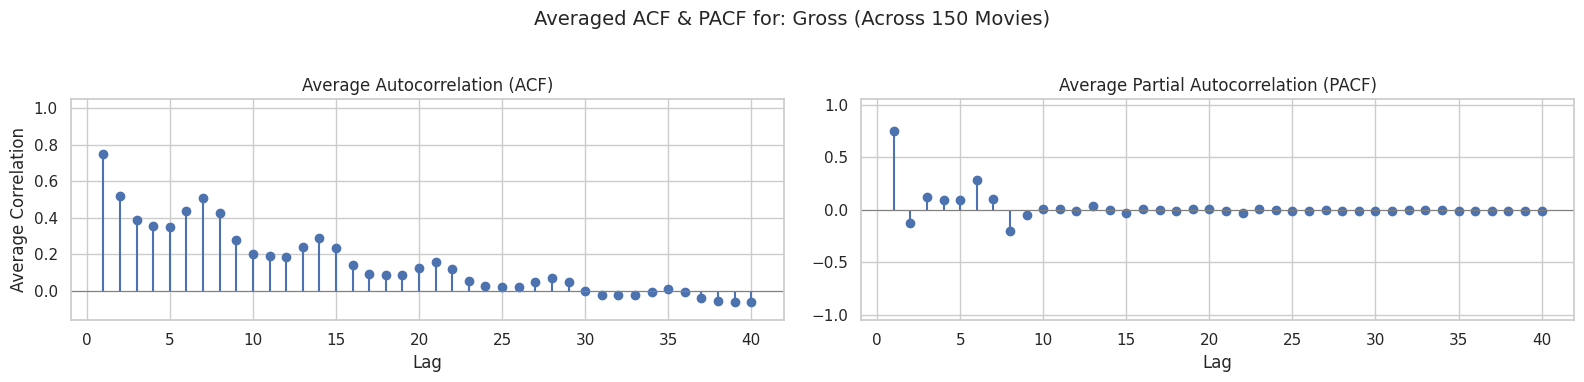

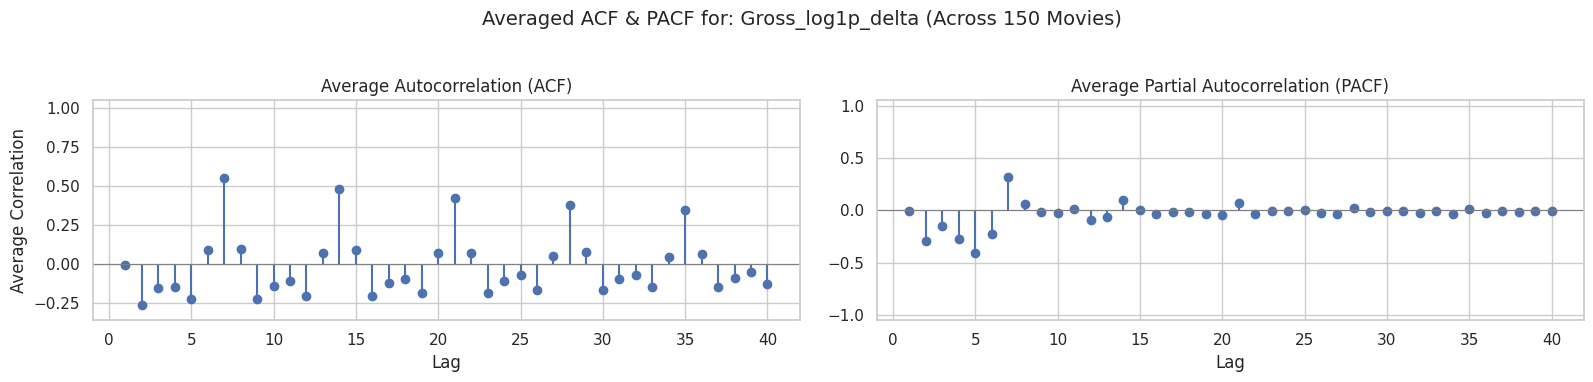

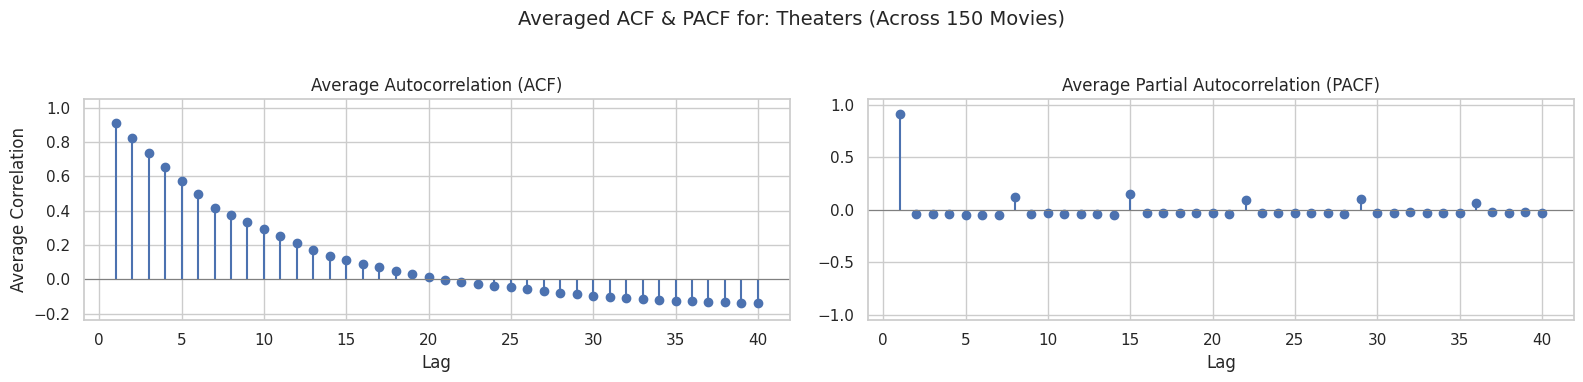

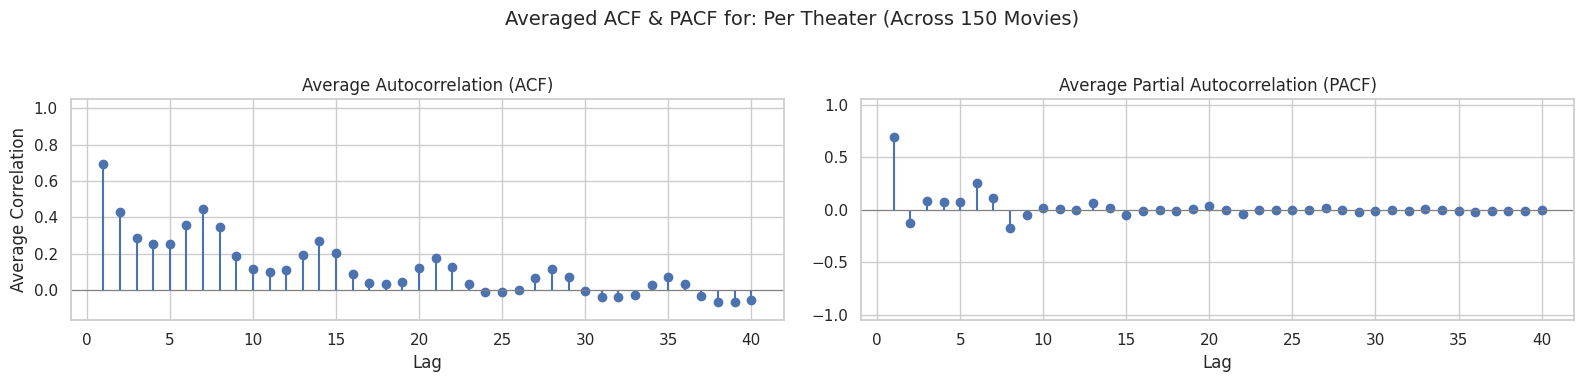

In [ ]:
# Aggregated ACF/PACF Analysis

# Configuration parameters.
MAX_LAG_PLOT = 40     # Maximum lag to calculate for ACF/PACF.
MIN_LENGTH_FOR_ACF = MAX_LAG_PLOT + 5  # Minimum movie length required.
VARIABLES_TO_ANALYZE = ['Gross', 'Gross_log1p_delta', 'Theaters', 'Per Theater']

# Remove 'Gross_log1p_delta' from analysis if not present.
if 'Gross_log1p_delta' not in df_processed_filtered.columns:
    print("Warning: 'Gross_log1p_delta' column not found. Skipping its analysis.")
    if 'Gross_log1p_delta' in VARIABLES_TO_ANALYZE:
        VARIABLES_TO_ANALYZE.remove('Gross_log1p_delta')

# Initialize dictionaries to store ACF/PACF results.
acf_results = {var: [] for var in VARIABLES_TO_ANALYZE}
pacf_results = {var: [] for var in VARIABLES_TO_ANALYZE}
valid_movies_count = 0

print(f"Iterating through movies to calculate individual ACF/PACF (min length: {MIN_LENGTH_FOR_ACF})...")
grouped = df_processed_filtered.groupby(MOVIE_ID_COLUMN)

for movie_id, group in tqdm(grouped, desc="Analyzing Movies"):
    # Skip movies that do not have enough data points.
    if len(group) < MIN_LENGTH_FOR_ACF:
        continue

    valid_movies_count += 1
    group = group.sort_values(by=DAYS_RELEASE_COLUMN)

    for var in VARIABLES_TO_ANALYZE:
        if var not in group.columns:
            continue

        series = group[var].dropna()

        if len(series) < MIN_LENGTH_FOR_ACF:
            continue

        try:
            # Calculate ACF (using FFT for speed) and PACF with the 'ywm' method.
            acf_vals = stattools.acf(series.values, nlags=MAX_LAG_PLOT, fft=True)
            pacf_vals = stattools.pacf(series.values, nlags=MAX_LAG_PLOT, method='ywm')
            acf_results[var].append(acf_vals)
            pacf_results[var].append(pacf_vals)
        except Exception as e:
            # If there is an error (e.g., due to zero variance), silently skip this movie.
            pass

print(f"Processed {valid_movies_count} movies with sufficient length.")

# Averaging and plotting the ACF/PACF results.
if valid_movies_count == 0:
    print("No movies found with sufficient length to plot aggregated ACF/PACF.")
else:
    print("\nPlotting Averaged ACF/PACF")
    for var in VARIABLES_TO_ANALYZE:
        if not acf_results[var]:
            print(f"  Skipping plot for '{var}': No valid ACF/PACF results collected.")
            continue

        # Convert lists of arrays to 2D numpy arrays.
        all_acfs = np.array(acf_results[var])
        all_pacfs = np.array(pacf_results[var])

        # Average the ACF/PACF values across movies, excluding lag 0.
        avg_acf = np.nanmean(all_acfs[:, 1:], axis=0)
        avg_pacf = np.nanmean(all_pacfs[:, 1:], axis=0)

        if np.isnan(avg_acf).all() or np.isnan(avg_pacf).all():
            print(f"  Skipping plot for '{var}': Average ACF/PACF calculation resulted in NaNs.")
            continue

        lags = np.arange(1, MAX_LAG_PLOT + 1)

        # Create subplots for ACF and PACF.
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'Averaged ACF & PACF for: {var} (Across {len(all_acfs)} Movies)', fontsize=14)

        # Plot the averaged ACF.
        axes[0].stem(lags, avg_acf, basefmt=" ")
        axes[0].axhline(0, color='grey', linewidth=0.8)
        axes[0].set_title('Average Autocorrelation (ACF)')
        axes[0].set_xlabel('Lag')
        axes[0].set_ylabel('Average Correlation')
        axes[0].grid(True)
        min_acf_val = np.nanmin(avg_acf) if not np.isnan(avg_acf).all() else -0.1
        axes[0].set_ylim(min(min_acf_val - 0.1, -0.1), 1.05)

        # Plot the averaged PACF.
        axes[1].stem(lags, avg_pacf, basefmt=" ")
        axes[1].axhline(0, color='grey', linewidth=0.8)
        axes[1].set_title('Average Partial Autocorrelation (PACF)')
        axes[1].set_xlabel('Lag')
        axes[1].grid(True)
        pacf_min = np.nanmin(avg_pacf) if not np.isnan(avg_pacf).all() else -1.05
        pacf_max = np.nanmax(avg_pacf) if not np.isnan(avg_pacf).all() else 1.05
        axes[1].set_ylim(min(pacf_min - 0.1, -1.05), max(pacf_max + 0.1, 1.05))

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

### Creating Lag and Rolling Features
Based on the ACF/PACF analysis we just performed, we'll now create time-lagged features that capture the temporal dependencies identified in our data. These features are crucial for time series forecasting, as they allow our model to learn how past values influence future outcomes.

In this step, we implement two types of time-based features:

1. **Lagged Features**:
   - We create features representing values from 1, 5, and 7 days ago
   - These specific lags were chosen based on our ACF/PACF analysis, which showed strong correlations at these time intervals
   - The lag features capture direct relationships between specific days

2. **Rolling Window Features**:
   - We calculate the 7-day rolling mean (centered on each day)
   - This creates a smoothed version of each feature that captures the local trend
   - Rolling features help reduce noise and highlight underlying patterns

We apply these transformations to our key numerical columns:
- Gross revenue (our target variable)
- Theater count
- Per-theater average

These engineered features will allow our model to leverage both short-term and medium-term patterns in the data, significantly improving its forecasting capabilities.

In [13]:
# Create lagged features for selected columns (e.g., target, Theaters, Per Theater).
# Based on the aggregated ACF/PACF Analysis
lags = [1, 5, 7]
lag_cols_candidates = [TARGET_COLUMN, 'Theaters', 'Per Theater']
lag_cols = [col for col in lag_cols_candidates if col in df_processed_filtered.columns]
if lag_cols:
    for lag in lags:
        for col in lag_cols:
            lag_col_name = f'{col}_lag{lag}'
            df_processed_filtered[lag_col_name] = df_processed_filtered.groupby(MOVIE_ID_COLUMN)[col].shift(lag)
            df_processed_filtered[lag_col_name] = df_processed_filtered[lag_col_name].fillna(0)

# Create rolling window features (mean over a 7-day period) for selected columns.
for w in [7]:
    window = w
    roll_cols_candidates = [TARGET_COLUMN, 'Theaters', 'Per Theater']
    roll_cols = [col for col in roll_cols_candidates if col in df_processed_filtered.columns]
    if roll_cols:
        for col in roll_cols:
            roll_col_name = f'{col}_roll_mean_{window}d'
            df_processed_filtered[roll_col_name] = df_processed_filtered.groupby(MOVIE_ID_COLUMN)[col].shift(1).rolling(window, min_periods=1).mean()
            df_processed_filtered[roll_col_name] = df_processed_filtered[roll_col_name].fillna(0)

### Creating Cyclic Features for Temporal Patterns
Many time series exhibit cyclical patterns - for example, weekend effects in movie box office data or seasonal trends throughout the year. Traditional features like "day of week" are problematic because they're categorical and don't capture the cyclic nature (e.g., the fact that day 7 is adjacent to day 1).

In this step, we address this challenge by creating trigonometric features that elegantly represent cyclical patterns:

1. **The Cyclic Feature Creation Function**:
   - We define a function that transforms a numeric column into sine and cosine components
   - This encodes the cyclic nature where the end of one cycle connects smoothly to the beginning of the next
   - The period parameter defines the cycle length (e.g., 7 for days of the week)

2. **Daily Pattern Features**:
   - We apply this transformation to day-of-week (period=7)
   - Day-of-year (period=365.25)
   - Month (period=12)
   - Week-of-year (period=52.14)

3. **Release Date Cyclic Features**:
   - We also encode cyclic features based on when the movie was released
   - This captures potential seasonality effects in movie performance by release timing

This approach provides a much richer representation of temporal cycles compared to simple categorical features. The sine/cosine transformation ensures our model can understand, for example, that Saturday (day 6) is closer to Sunday (day 0) than to Wednesday (day 3), which is vital for learning accurate weekend patterns in box office performance.

In [14]:
# Add cyclic (sin/cos) date features for daily and release dates.

def add_cyclic_features(df, col_name, period, prefix=""):
    """
    Add cyclic sine and cosine transformation features from a numeric column.
    """
    col_sin = f"{prefix}{col_name}_sin"
    col_cos = f"{prefix}{col_name}_cos"
    if col_sin not in df.columns and col_cos not in df.columns and col_name in df.columns:
         print(f"  - Adding sin/cos for {prefix}{col_name} (period={period})")
         numeric_col = pd.to_numeric(df[col_name], errors='coerce')
         valid_idx = numeric_col.notna()
         df.loc[valid_idx, col_sin] = np.sin(2 * np.pi * numeric_col[valid_idx] / period)
         df.loc[valid_idx, col_cos] = np.cos(2 * np.pi * numeric_col[valid_idx] / period)
         df[col_sin] = df[col_sin].fillna(0)
         df[col_cos] = df[col_cos].fillna(0)
         return True
    return False

# Add cyclic features for daily date components.
date_cols_periods = {
    'dayofweek': 7.0,
    'dayofyear': 365.25,
    'month': 12.0,
    'weekofyear': 52.14  # Approximate
}
for col, period in date_cols_periods.items():
    add_cyclic_features(df_processed_filtered, col, period)

# Add cyclic features for release date components.
release_date_cols_periods = {
    'release_month': 12.0,
    'release_dayofweek': 7.0,
    'release_dayofyear': 365.25,
    'release_weekofyear': 52.14
}
for col, period in release_date_cols_periods.items():
     add_cyclic_features(df_processed_filtered, col, period)

  - Adding sin/cos for dayofweek (period=7.0)
  - Adding sin/cos for dayofyear (period=365.25)
  - Adding sin/cos for month (period=12.0)
  - Adding sin/cos for weekofyear (period=52.14)
  - Adding sin/cos for release_month (period=12.0)
  - Adding sin/cos for release_dayofweek (period=7.0)
  - Adding sin/cos for release_dayofyear (period=365.25)
  - Adding sin/cos for release_weekofyear (period=52.14)


### Defining Feature Groups for the Model
Now that we've engineered a rich set of features, we need to organize them for use in our sequence-to-sequence forecasting model. The model requires different types of features for different components:

1. **Static Features**: Characteristics that don't change over a movie's run
   - **Numerical static features**: Like runtime, budget, and crew size
   - **Categorical static features**: Like distributor, director, and language

2. **Known Day Features**: Time-varying features for the known sequence period
   - Target values, target deltas, theater counts
   - Time-based features like weekend indicators
   - Lagged and rolling features for capturing temporal patterns

3. **Decoder Input Features**: Features available for future days to help with prediction
   - Cyclic time features that we can know in advance (e.g., future weekday patterns)

In this step, we identify the available columns in our dataset for each of these categories, preparing them for use in our model architecture. This organization ensures that each component of our model receives the appropriate set of features for its specific role in the forecasting pipeline.

In [15]:
# Define feature lists.

# Numerical static features.
static_feature_candidates_base = [
    'running_time', 'adult', 'budget', 'budget_missing_indicator',
    'crew_size', 'cast_size', 'total_crew_popularity', 'total_cast_popularity',
    'num_genres', 'num_prod_companies', 'is_major_studio', 'num_languages', 'is_english_primary',
    'release_year', 'release_month_sin', 'release_month_cos',
    'release_dayofweek_sin', 'release_dayofweek_cos', 'release_dayofyear_sin', 'release_dayofyear_cos',
    'release_weekofyear_sin', 'release_weekofyear_cos', 'is_weekend_release'
]
static_features_num_list = [
    col for col in static_feature_candidates_base
    if col in df_processed_filtered.columns and pd.api.types.is_numeric_dtype(df_processed_filtered[col])
]

# Categorical static features.
static_feature_candidates_cat = [
    'Distributor', 'director', 'original_language', 'top_director',
    'top_producer', 'top_actor', 'top_actress'
]
static_features_cat_list = [
    col for col in static_feature_candidates_cat if col in df_processed_filtered.columns
]

# Features for the known days sequence.
known_days_features_list_base = [
    LOG_TARGET_COLUMN, DELTA_LOG_TARGET_COLUMN,
    'Theaters', 'Per Theater',
    'dayofweek_sin', 'dayofweek_cos', 'is_weekend_daily'
]
# Generate lag feature names.
lag_feature_names = []
base_cols_for_lags = [TARGET_COLUMN, 'Theaters', 'Per Theater']
for lag in range(1, 15):
    for base_col in base_cols_for_lags:
         lag_col_name = f'{base_col}_lag{lag}'
         if lag_col_name in df_processed_filtered.columns:
             lag_feature_names.append(lag_col_name)

# Generate rolling window feature names.
rolling_feature_names = []
base_cols_for_rolling = [TARGET_COLUMN, 'Theaters', 'Per Theater']
for w in range(1, 15):
    for base_col in base_cols_for_rolling:
        roll_col_name = f'{base_col}_roll_mean_{w}d'
        if roll_col_name in df_processed_filtered.columns:
            rolling_feature_names.append(roll_col_name)

# Combine features for known days sequence.
known_days_features_list_candidates = known_days_features_list_base + rolling_feature_names + lag_feature_names
known_days_features_list = [
    col for col in known_days_features_list_candidates if col in df_processed_filtered.columns
]

# Decoder input sequence features.
decoder_dynamic_feature_list_candidates = [
    'dayofweek_sin', 'dayofweek_cos',
    'month_sin', 'month_cos',
    'dayofyear_sin', 'dayofyear_cos',
    'weekofyear_sin', 'weekofyear_cos',
    'is_weekend_daily'
]
decoder_dynamic_feature_list = [
    col for col in decoder_dynamic_feature_list_candidates if col in df_processed_filtered.columns
]

print(f"Selected {len(static_features_num_list)} numerical static features.")
print(f"Selected {len(static_features_cat_list)} categorical static features.")
print(f"Selected {len(known_days_features_list)} features per known day.")
print(f"Selected {len(decoder_dynamic_feature_list)} features for decoder input sequence.")



Selected 22 numerical static features.
Selected 7 categorical static features.
Selected 19 features per known day.
Selected 9 features for decoder input sequence.


### Preparing Movie Sequences for Sequence-to-Sequence Modeling
Now that we have defined all our feature groups, we need to extract and structure the data into the specific format required by our sequence-to-sequence model. This is a critical step that transforms our time series data from a row-based format into structured sequences.

For each movie, we need to extract:

1. **Static Features**:
   - Numerical and categorical attributes that remain constant for each movie
   - These are extracted from the first day's record for each movie

2. **Known Performance Sequence**:
   - A fixed-length sequence of the first 14 days of each movie's run
   - Contains all time-varying features for these known days

3. **Decoder Target Sequence**:
   - The delta log gross values for days 15-40 that we want to predict
   - This sequence may be shorter if a movie's run ended before day 40

4. **Decoder Input Features**:
   - Time-based features that we can know in advance for the prediction period
   - Will help the decoder generate better predictions

Additionally, we store metadata like the last known log gross (day 14) for each movie. This will be used later to reconstruct absolute gross predictions from our delta predictions.

We only include movies with complete data for all 14 known days and at least one future day to predict. This ensures our model has sufficient data to learn from and evaluate against.

In [ ]:
# Process each movie to extract data sequences.
all_static_features_num_data = []
all_static_features_cat_data = []
all_known_performance_seq_data = []
decoder_target_delta_data = []
decoder_input_base_features_data = []
movies_for_split = []  # Stores {'id': movie_name, 'release_date': release_date}
last_known_log_gross_history = {}  # For reconstruction
original_target_gross_log_sequences = {}  # For evaluation
movie_ids_processed = []  # List of processed movie IDs

print("Processing each movie for sequence extraction...")
grouped = df_processed_filtered.groupby(MOVIE_ID_COLUMN)
for movie_name, group in tqdm(grouped, desc="Extracting Sequences"):
    group = group.sort_values(by=DAYS_RELEASE_COLUMN).reset_index(drop=True)

    # Require enough data: known period + at least one prediction day.
    if len(group) < N_DAYS_KNOWN + 1:
        continue

    first_day_indices = group[group[DAYS_RELEASE_COLUMN] == 1].index
    if first_day_indices.empty:
        continue
    day1_record_df = group.loc[[first_day_indices[0]]]

    # Extract static features from day 1.
    static_num_features = day1_record_df[static_features_num_list].iloc[0].values
    static_cat_features = day1_record_df[static_features_cat_list].iloc[0].astype(str).values

    # Extract known performance sequence.
    known_seq_indices = []
    for day in range(1, N_DAYS_KNOWN + 1):
        day_indices = group[group[DAYS_RELEASE_COLUMN] == day].index
        if not day_indices.empty:
            known_seq_indices.append(day_indices[0])
        else:
            known_seq_indices = []
            break
    if len(known_seq_indices) != N_DAYS_KNOWN:
        continue
    known_performance_seq_df = group.loc[known_seq_indices]
    known_performance_seq = known_performance_seq_df[known_days_features_list].fillna(0).values

    # Extract decoder target (delta) sequence.
    decoder_seq_indices = []
    for day in range(N_DAYS_KNOWN + 1, N_DAYS_TOTAL_WINDOW + 1):
         day_indices = group[group[DAYS_RELEASE_COLUMN] == day].index
         if not day_indices.empty:
            decoder_seq_indices.append(day_indices[0])
    if not decoder_seq_indices:
        continue
    target_delta_seq_df = group.loc[decoder_seq_indices]
    target_delta_seq = target_delta_seq_df[DELTA_LOG_TARGET_COLUMN].fillna(0).values

    # Extract decoder input features sequence.
    decoder_input_features_seq = target_delta_seq_df[decoder_dynamic_feature_list].fillna(0).values

    min_len_predict = min(len(target_delta_seq), len(decoder_input_features_seq))
    if min_len_predict == 0:
        continue
    target_delta_seq = target_delta_seq[:min_len_predict]
    decoder_input_features_seq = decoder_input_features_seq[:min_len_predict]

    # Get last known log gross for reconstruction.
    last_known_indices = group[group[DAYS_RELEASE_COLUMN] == N_DAYS_KNOWN].index
    if last_known_indices.empty:
        continue
    last_known_record = group.loc[[last_known_indices[0]]]
    last_known_log_gross = last_known_record.iloc[0][LOG_TARGET_COLUMN]
    if pd.isna(last_known_log_gross):
        continue

    # Get original log gross sequence for evaluation.
    original_target_gross_log_seq = target_delta_seq_df[LOG_TARGET_COLUMN].iloc[:min_len_predict].values

    # Append movie data.
    all_static_features_num_data.append(static_num_features)
    all_static_features_cat_data.append(static_cat_features)
    all_known_performance_seq_data.append(known_performance_seq)
    decoder_target_delta_data.append(target_delta_seq)
    decoder_input_base_features_data.append(decoder_input_features_seq)
    movies_for_split.append({'id': movie_name, 'release_date': day1_record_df[RELEASE_DATE_COLUMN].iloc[0]})
    last_known_log_gross_history[movie_name] = last_known_log_gross
    original_target_gross_log_sequences[movie_name] = original_target_gross_log_seq
    movie_ids_processed.append(movie_name)

print(f"Successfully processed {len(movie_ids_processed)} movies for sequence extraction.")
if not movie_ids_processed:
    raise ValueError("No movies left after sequence extraction filtering.")

Processing each movie for sequence extraction...


Extracting Sequences: 100%|██████████| 1340/1340 [00:22<00:00, 60.83it/s]

Successfully processed 785 movies for sequence extraction.


### Feature Preprocessing: Encoding Categorical Features
Our model can't directly work with categorical text data - we need to convert categories like 'Distributor' or 'director' into numerical representations. In this step, we encode all categorical static features using scikit-learn's LabelEncoder.

For each categorical feature, we:

1. **Create a DataFrame** containing the categorical data for all processed movies
2. **Fill Missing Values** replacing any NaN with 'Unknown' to ensure consistency
3. **Apply Label Encoding** where each unique category gets assigned a unique integer ID
4. **Store Vocabulary Information** for later use in the model's embedding layers
   - We keep track of how many unique values exist for each categorical feature
   - This is crucial for correctly sizing the embedding layers

The encoded features will be used by the embedding layers in our model, which will learn dense vector representations of these categories during training. These learned embeddings allow the model to capture semantic relationships between different categories and their impact on box office performance.

In [17]:
# Preprocess Features: Scaling and Encoding.

# Encode categorical static features.
static_cat_df = pd.DataFrame(all_static_features_cat_data, columns=static_features_cat_list)
encoders = {}
cat_vocab_sizes = {}
static_cat_encoded_list = []
print("Encoding static categorical features...")
for col in static_features_cat_list:
    static_cat_df[col] = static_cat_df[col].astype(str).fillna('Unknown')
    le = LabelEncoder()
    le.fit(static_cat_df[col].unique())
    encoded_col = le.transform(static_cat_df[col])
    static_cat_encoded_list.append(encoded_col)
    encoders[col] = le
    cat_vocab_sizes[col] = len(le.classes_)
    print(f" - Encoded '{col}' with {cat_vocab_sizes[col]} unique values.")

Encoding static categorical features...
 - Encoded 'Distributor' with 93 unique values.
 - Encoded 'director' with 693 unique values.
 - Encoded 'original_language' with 22 unique values.
 - Encoded 'top_director' with 689 unique values.
 - Encoded 'top_producer' with 581 unique values.
 - Encoded 'top_actor' with 548 unique values.
 - Encoded 'top_actress' with 575 unique values.


### Feature Preprocessing: Scaling Numerical Static Features
In addition to encoding categorical features, we need to standardize numerical features to ensure they have similar scales. This is crucial for neural network training, as features with wildly different scales can cause training issues and slower convergence.

In this step, we:

1. **Convert the Feature Arrays** to a consistent float format
2. **Handle Missing Values** by imputing them with column medians
   - This ensures no NaN values disrupt the training process
   - Using medians rather than means provides robustness to outliers

3. **Apply StandardScaler** to normalize each feature
   - Transforms features to have zero mean and unit variance
   - Ensures all numerical features contribute equally to the model

This standardization process will significantly improve training stability and model performance. Our scaled features will have values typically ranging between -3 and +3, which is ideal for neural network training.

In [18]:
# Scale numerical static features.
static_num_array = np.array(all_static_features_num_data).astype(float)
print("Scaling static numerical features...")
scaler_static = StandardScaler()
if np.isnan(static_num_array).any():
    print("Imputing NaNs in static numerical features with column medians...")
    col_medians = np.nanmedian(static_num_array, axis=0)
    nan_indices = np.where(np.isnan(static_num_array))
    static_num_array[nan_indices] = np.take(col_medians, nan_indices[1])
    static_num_array[:, np.isnan(col_medians)] = 0
static_num_scaled = scaler_static.fit_transform(static_num_array)

Scaling static numerical features...


### Feature Preprocessing: Scaling Known Performance Sequences
Next, we need to scale the time-series data from the known performance period (first 14 days). This sequence data requires special handling because:

1. It has a three-dimensional structure: [movies × days × features]
2. We need to maintain the temporal relationship while scaling

Our approach follows these steps:

1. **Validate Sequence Integrity**:
   - Check that all sequences have the same shape
   - Ensure we have data for all movies

2. **Flatten for Scaling**:
   - Temporarily reshape the 3D array to 2D [all_movie_days × features]
   - This allows us to scale across the entire dataset

3. **Handle Missing Values**:
   - Replace any NaN values with column medians
   - This maintains data consistency without distorting distributions

4. **Apply StandardScaler**:
   - Normalize each feature to have zero mean and unit variance
   - Ensures all features contribute appropriately to the model

5. **Reshape Back to 3D**:
   - Restore the original 3D shape after scaling
   - The result is a properly scaled sequence for each movie

This scaled sequential data will serve as input to our encoder module, allowing it to effectively learn patterns from the first 14 days of each movie's performance.

In [19]:
# Scale known performance sequences.
print("Scaling known performance sequence features...")
num_movies = len(all_known_performance_seq_data)
if not all_known_performance_seq_data:
     raise ValueError("No known performance sequence data to process.")
first_shape = all_known_performance_seq_data[0].shape
if not all(s.shape == first_shape for s in all_known_performance_seq_data):
    raise ValueError("Inconsistent shapes found in known performance sequences.")
n_known_features = first_shape[1]
known_perf_flat = np.vstack(all_known_performance_seq_data).astype(float)
scaler_known_perf_seq = StandardScaler()
if np.isnan(known_perf_flat).any():
     print("Imputing NaNs in known performance sequences with column medians...")
     col_medians_known = np.nanmedian(known_perf_flat, axis=0)
     col_medians_known = np.nan_to_num(col_medians_known)
     nan_indices_known = np.where(np.isnan(known_perf_flat))
     known_perf_flat[nan_indices_known] = np.take(col_medians_known, nan_indices_known[1])
known_perf_flat_scaled = scaler_known_perf_seq.fit_transform(known_perf_flat)
X_known_perf_scaled_seq = known_perf_flat_scaled.reshape(num_movies, N_DAYS_KNOWN, n_known_features)

Scaling known performance sequence features...


### Feature Preprocessing: Scaling Decoder Input Features
In time series forecasting, we need to consider not just what has happened in the past, but also information about the future that we can know in advance - like what day of the week a future date will be. 

This is where decoder input features come in. These are time-based features for our prediction period (days 15-40) that we can calculate beforehand, such as weekend flags or seasonal indicators. Just like with our known sequence features, we need to properly scale these decoder inputs to help the model learn effectively.

In this step, we:
1. **Validate and collect the data**: We make sure we have decoder features for all movies
2. **Flatten the features**: We combine all sequences to properly scale across the entire dataset
3. **Handle missing values**: We replace NaNs with column medians to maintain data integrity
4. **Apply StandardScaler**: We normalize the features to improve training stability
 
This ensures that all temporal patterns in our future prediction window are properly represented to the model in a consistent, normalized format.

In [20]:
# Scale decoder input base features.
print("Scaling decoder input base features...")
if not decoder_input_base_features_data:
     raise ValueError("No decoder input base feature data to process.")
valid_decoder_base_data = [s for s in decoder_input_base_features_data if s.shape[0] > 0]
if not valid_decoder_base_data:
    raise ValueError("All decoder input sequences are empty.")
decoder_base_flat = np.vstack(valid_decoder_base_data).astype(float)
n_decoder_base_features = decoder_base_flat.shape[1] if decoder_base_flat.size > 0 else 0
scaler_decoder_base = StandardScaler()
if np.isnan(decoder_base_flat).any():
     print("Imputing NaNs in decoder base features with column medians...")
     col_medians_decoder = np.nanmedian(decoder_base_flat, axis=0)
     col_medians_decoder = np.nan_to_num(col_medians_decoder)
     nan_indices_decoder = np.where(np.isnan(decoder_base_flat))
     decoder_base_flat[nan_indices_decoder] = np.take(col_medians_decoder, nan_indices_decoder[1])
decoder_base_flat_scaled = scaler_decoder_base.fit_transform(decoder_base_flat)

Scaling decoder input base features...


### Feature Preprocessing: Scaling Decoder Input Features
In time series forecasting, we need to consider not just what has happened in the past, but also information about the future that we can know in advance - like what day of the week a future date will be. 

This is where decoder input features come in. These are time-based features for our prediction period (days 15-40) that we can calculate beforehand, such as weekend flags or seasonal indicators. Just like with our known sequence features, we need to properly scale these decoder inputs to help the model learn effectively.

In this step, we:
1. **Validate and collect the data**: We make sure we have decoder features for all movies
2. **Flatten the features**: We combine all sequences to properly scale across the entire dataset
3. **Handle missing values**: We replace NaNs with column medians to maintain data integrity
4. **Apply StandardScaler**: We normalize the features to improve training stability
 
This ensures that all temporal patterns in our future prediction window are properly represented to the model in a consistent, normalized format.

In [21]:
# Reconstruct scaled decoder input sequences.
all_decoder_input_base_scaled_list = []
original_lengths_predict = [len(s) for s in decoder_input_base_features_data]
scaled_data_cursor = 0
for length in original_lengths_predict:
    if length > 0:
       end_idx = scaled_data_cursor + length
       seq = decoder_base_flat_scaled[scaled_data_cursor:end_idx, :]
       all_decoder_input_base_scaled_list.append(torch.tensor(seq, dtype=torch.float32))
       scaled_data_cursor = end_idx
    else:
       all_decoder_input_base_scaled_list.append(torch.empty((0, n_decoder_base_features), dtype=torch.float32))

### Converting Data to PyTorch Tensors
Now that we have all our features properly processed and scaled, we need to convert everything to PyTorch tensors - the fundamental data structure that PyTorch uses for computations. Tensors allow us to move data to the GPU for acceleration and enable automatic differentiation during training.

In this step, we:
1. **Convert target sequences**: Transform our delta predictions (what we're trying to forecast) into tensors
2. **Convert static features**: Convert both numerical and categorical static movie attributes to tensors
3. **Convert sequence data**: Transform our known performance sequence (first 14 days) into tensor format

By doing this conversion now, before splitting into training and testing sets, we ensure that all our data is in a consistent format and ready for efficient loading during the model training phase.

In [22]:
# Convert target delta sequences to tensors.
decoder_target_delta_list = [torch.tensor(s, dtype=torch.float32) for s in decoder_target_delta_data]

# Convert other features to tensors.
X_num_static_tensor = torch.tensor(static_num_scaled, dtype=torch.float32)
X_cat_static_tensor_list = [torch.tensor(arr, dtype=torch.long) for arr in static_cat_encoded_list]
X_known_perf_scaled_tensor = torch.tensor(X_known_perf_scaled_seq, dtype=torch.float32)

### Creating Time-Based Train/Test Split
Unlike traditional machine learning tasks where data points are independent, for time series forecasting we need to be careful about how we split our data. To simulate a real-world scenario, we need to train on past movies and test on newer releases. This approach evaluates how well our model can predict future performance given historical patterns.

In this step, we:
1. **Use release date for splitting**: We identify a cutoff date (the most recent year in our dataset)
2. **Create train and test indices**: Movies released before the cutoff go into training, others into testing
3. **Verify the split distribution**: We check that both sets have enough movies for meaningful training and evaluation
4. **Handle edge cases**: We ensure the split doesn't result in empty sets and raise clear errors if it does

This time-based split better reflects real-world forecasting challenges where we need to make predictions about new movies based on patterns learned from older ones.

In [23]:
# Train/Test Split based on release date.
print("Performing time-based train/test split on movies...")
movie_split_df = pd.DataFrame(movies_for_split).reset_index()  # 'index' links to original movie order
train_indices_movie = movie_split_df[movie_split_df['release_date'] < SPLIT_DATE]['index'].tolist()
test_indices_movie = movie_split_df[movie_split_df['release_date'] >= SPLIT_DATE]['index'].tolist()
if not train_indices_movie:
    print("Warning: Training set is empty based on split date.")
if not test_indices_movie:
    print("Warning: Test set is empty based on split date.")
if not train_indices_movie or not test_indices_movie:
    raise ValueError("Train or test set is empty. Adjust SPLIT_DATE or check data.")
print(f"Found {len(train_indices_movie)} train movies, {len(test_indices_movie)} test movies.")

Performing time-based train/test split on movies...
Found 764 train movies, 21 test movies.


### Creating a Custom PyTorch Dataset
To efficiently train our deep learning model, we need to create a custom dataset class that handles the complexities of our movie data. PyTorch's Dataset class provides a structured way to access our data during training and evaluation.

In this step, we:
1. **Define the MovieForecastDataset class**: Inheriting from PyTorch's Dataset
2. **Store different data components**: Store references to features, sequences, and targets
3. **Implement the __len__ method**: Return the number of movies in the dataset
4. **Implement the __getitem__ method**: Extract features for a specific movie index
   - We retrieve the original index from our filtered dataset
   - We collect static features, both numerical and categorical 
   - We extract the known sequence (first 14 days)
   - We obtain the decoder input features and target
   - We create position encodings to help the model understand sequence order

This custom dataset class intelligently manages the complexities of our heterogeneous data (static features, time series, and variable-length sequences), making it easy to batch and process during model training.

In [24]:
# Create PyTorch Dataset and DataLoader.
class MovieForecastDataset(Dataset):
    def __init__(self, movie_indices, static_num, static_cat_list, known_seq, decoder_base_list, target_delta_list, movie_ids, n_predict_steps):
        self.movie_indices = movie_indices
        self.static_num = static_num
        self.static_cat_list = static_cat_list
        self.known_seq = known_seq
        self.decoder_base_list = decoder_base_list
        self.target_delta_list = target_delta_list
        self.movie_ids = movie_ids
        self.n_predict_steps = n_predict_steps

    def __len__(self):
        return len(self.movie_indices)

    def __getitem__(self, idx):
        original_idx = self.movie_indices[idx]
        num_static = self.static_num[original_idx]
        cat_static = [cat_tensor[original_idx] for cat_tensor in self.static_cat_list]
        known = self.known_seq[original_idx]  # Shape: (N_DAYS_KNOWN, n_known_features)
        decoder_base = self.decoder_base_list[original_idx]  # Variable length sequence
        target = self.target_delta_list[original_idx]  # Variable length
        seq_len = target.shape[0]
        positions = torch.arange(0, seq_len, dtype=torch.long) if seq_len > 0 else torch.empty((0,), dtype=torch.long)
        movie_id = self.movie_ids[original_idx]
        return {
            'num_static': num_static,
            'cat_static': cat_static,
            'known_seq': known,
            'decoder_base': decoder_base,
            'positions': positions,
            'target_delta': target,
            'movie_id': movie_id
        }

### Creating Training and Test Datasets
With our custom dataset class defined, we now need to create two separate datasets: one for training our model and one for evaluating its performance. This step instantiates the MovieForecastDataset class we just created with the appropriate indices.

In this step, we:
1. **Extract movie IDs**: Gather the movie identifiers for both training and test sets
2. **Instantiate training dataset**: Create a MovieForecastDataset with training indices and all our preprocessed features
3. **Instantiate test dataset**: Create a second dataset with test indices and the same feature structures

These dataset objects will be used by our DataLoader to efficiently batch and iterate through the data during training and evaluation. Having separate train and test datasets ensures we evaluate our model on movies it hasn't seen during training.

In [25]:
train_movie_ids = [movie_ids_processed[i] for i in train_indices_movie]
test_movie_ids = [movie_ids_processed[i] for i in test_indices_movie]

train_dataset = MovieForecastDataset(
    train_indices_movie, X_num_static_tensor, X_cat_static_tensor_list, X_known_perf_scaled_tensor,
    all_decoder_input_base_scaled_list, decoder_target_delta_list, movie_ids_processed, N_DAYS_PREDICT
)
test_dataset = MovieForecastDataset(
    test_indices_movie, X_num_static_tensor, X_cat_static_tensor_list, X_known_perf_scaled_tensor,
    all_decoder_input_base_scaled_list, decoder_target_delta_list, movie_ids_processed, N_DAYS_PREDICT
)

### Defining a Batch Collate Function
One challenge when working with sequence data is that different movies have different run lengths in our dataset. While the first 14 days (known period) are always the same length, the prediction period can vary. To efficiently batch these variable-length sequences, we need a custom collation function.

In this step, we:
1. **Define the collate_fn**: A function that properly batches our heterogeneous data
2. **Stack uniform-length features**: For fixed-length data like static features and known sequences
3. **Pad variable-length sequences**: For prediction targets and decoder inputs that differ in length
   - Using PyTorch's pad_sequence to align sequences to the same length
   - Padding with our specified PAD_VALUE (0.0)
4. **Create attention masks**: Generate binary masks to identify real vs. padded values
5. **Standardize sequence lengths**: Ensure all sequences match our desired prediction horizon
   - Pad sequences shorter than N_DAYS_PREDICT
   - Truncate sequences longer than N_DAYS_PREDICT

This complex collation function enables us to efficiently batch our data while maintaining the variable-length nature of movie runs and properly masking padded values during training.

In [26]:
def collate_fn(batch):
    """
    Collate function to pad variable-length sequences in a batch.
    """
    batch_dict = {key: [item[key] for item in batch] for key in batch[0].keys()}
    num_static = torch.stack(batch_dict['num_static'])
    cat_static = [torch.stack([item if torch.is_tensor(item) else torch.tensor(item)
                                 for item in cat_list])
                  for cat_list in zip(*batch_dict['cat_static'])]
    known_seq = torch.stack(batch_dict['known_seq'])
    decoder_base = pad_sequence(batch_dict['decoder_base'], batch_first=True, padding_value=PAD_VALUE)
    positions = pad_sequence(batch_dict['positions'], batch_first=True, padding_value=0)
    target_delta = pad_sequence(batch_dict['target_delta'], batch_first=True, padding_value=PAD_VALUE)

    # Adjust padding to match fixed sequence length for predictions.
    current_max_len = target_delta.shape[1]
    if current_max_len < N_DAYS_PREDICT:
        pad_len = N_DAYS_PREDICT - current_max_len
        decoder_base = nn.functional.pad(decoder_base, (0, 0, 0, pad_len), value=PAD_VALUE)
        positions = nn.functional.pad(positions, (0, pad_len), value=0)
        target_delta = nn.functional.pad(target_delta, (0, pad_len), value=PAD_VALUE)
    elif current_max_len > N_DAYS_PREDICT:
        decoder_base = decoder_base[:, :N_DAYS_PREDICT, :]
        positions = positions[:, :N_DAYS_PREDICT]
        target_delta = target_delta[:, :N_DAYS_PREDICT]

    # Create a mask for non-padded elements.
    mask = (target_delta != PAD_VALUE)
    movie_ids = batch_dict['movie_id']
    return {
        'num_static': num_static,
        'cat_static': cat_static,
        'known_seq': known_seq,
        'decoder_base': decoder_base,
        'positions': positions,
        'target_delta': target_delta,
        'mask': mask,
        'movie_ids': movie_ids
    }

### Creating DataLoaders and Checking Batch Structure
Now that we have our datasets and collation function ready, we need to create DataLoaders - PyTorch objects that efficiently iterate through our datasets during training. The DataLoader handles batching, shuffling, and parallel data loading to optimize the training process.

In this step, we:
1. **Configure DataLoader parameters**:
   - Set the batch size (128 samples)
   - Enable shuffling for the training set (to prevent learning order biases)
   - Apply our custom collation function
   - Enable pinned memory for faster GPU transfers
   - Configure multi-worker loading when using GPU

2. **Verify the data structure**:
   - Sample a batch from the training loader to inspect
   - Print the shapes and contents of each component
   - Confirm masking is working correctly for padded sequences

This verification step gives us confidence that our complex data pipeline is working correctly before we proceed to building and training the model. It helps catch any issues with batching, tensor shapes, or data structure early in the process.

In [27]:
num_workers = 2 if torch.cuda.is_available() else 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=num_workers)

print("Checking a sample batch from DataLoader:")
try:
    sample_batch = next(iter(train_loader))
    print("Batch keys:", sample_batch.keys())
    print("Num static shape:", sample_batch['num_static'].shape)
    print("Cat static shapes:", [c.shape for c in sample_batch['cat_static']])
    print("Known seq shape:", sample_batch['known_seq'].shape)
    print("Decoder base shape:", sample_batch['decoder_base'].shape)
    print("Positions shape:", sample_batch['positions'].shape)
    print("Target delta shape:", sample_batch['target_delta'].shape)
    print("Mask shape:", sample_batch['mask'].shape)
    print("Number of movie IDs:", len(sample_batch['movie_ids']))
    print("Mask example (first 5):", sample_batch['mask'][0, :5])
    print("Target example (first 5):", sample_batch['target_delta'][0, :5])
except Exception as e:
    print(f"Error getting sample batch: {e}")
    print("Check dataset/collate function.")

print(f"\nData Preparation for PyTorch took {time.time() - start_time_prep:.2f} seconds.")

Checking a sample batch from DataLoader:
Batch keys: dict_keys(['num_static', 'cat_static', 'known_seq', 'decoder_base', 'positions', 'target_delta', 'mask', 'movie_ids'])
Num static shape: torch.Size([128, 22])
Cat static shapes: [torch.Size([128]), torch.Size([128]), torch.Size([128]), torch.Size([128]), torch.Size([128]), torch.Size([128]), torch.Size([128])]
Known seq shape: torch.Size([128, 14, 19])
Decoder base shape: torch.Size([128, 26, 9])
Positions shape: torch.Size([128, 26])
Target delta shape: torch.Size([128, 26])
Mask shape: torch.Size([128, 26])
Number of movie IDs: 128
Mask example (first 5): tensor([True, True, True, True, True])
Target example (first 5): tensor([ 1.5431, -0.0103, -0.2430, -0.7880,  0.3392])

Data Preparation for PyTorch took 33.24 seconds.


### Setting Model Hyperparameters
Before building our model, we need to define its architecture and training characteristics through hyperparameters. These parameters control the model's capacity, regularization, and learning behavior.

In this step, we define several groups of hyperparameters:

1. **Embedding Parameters**:
   - `EMBEDDING_DIM`: Size of the embedding vectors for categorical features (64)
   - `POS_EMBEDDING_DIM`: Dimension for positional embeddings (16)

2. **LSTM Architecture Parameters**:
   - `ENCODER_LSTM_UNITS`: Hidden units in the encoder LSTM (128)
   - `DECODER_LSTM_UNITS`: Hidden units in the decoder LSTM (128)

3. **Attention Mechanism Parameters**:
   - `NUM_HEADS`: Number of attention heads (4)

4. **Regularization Parameters**:
   - `LSTM_DROPOUT_RATE`: Dropout rate for LSTM layers (0.2)
   - `DENSE_DROPOUT_RATE`: Dropout rate for dense layers (0.3)
   - `WEIGHT_DECAY`: L2 regularization strength (5e-5)

5. **Training Parameters**:
   - `LEARNING_RATE`: Initial learning rate (1e-4)
   - `CLIP_GRAD_NORM`: Gradient clipping threshold (2.0)
   - `EPOCHS`: Maximum number of training epochs (1000)
   - `EARLY_STOPPING_PATIENCE`: Epochs to wait before stopping if no improvement (200)
   - `REDUCE_LR_PATIENCE`: Epochs to wait before reducing learning rate (30)
   - `REDUCE_LR_FACTOR`: Factor by which to reduce learning rate (0.8)
   - `MIN_LR`: Minimum learning rate (1e-7)

These carefully chosen hyperparameters reflect best practices for sequence-to-sequence models and will help our model learn effectively while preventing overfitting.

In [ ]:
# Model Hyperparameters
# Embeddings

# Embedding dimension for categoricals
EMBEDDING_DIM = 64
# Dimension for learned positional embedding
POS_EMBEDDING_DIM = 16
# LSTMs

# For processing known days sequence
ENCODER_LSTM_UNITS = 128
# Main decoder LSTM layer size
DECODER_LSTM_UNITS = 128
# Attention
# Number of attention heads (must divide DECODER_LSTM_UNITS if used as dim)
NUM_HEADS = 4

# Regularization
LSTM_DROPOUT_RATE = 0.2
DENSE_DROPOUT_RATE = 0.3
# Weight decay for AdamW
WEIGHT_DECAY = 5e-5


# Training Parameters
LEARNING_RATE = 1e-4
CLIP_GRAD_NORM = 2.0
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 200
REDUCE_LR_PATIENCE = 30
REDUCE_LR_FACTOR = 0.8
MIN_LR = 1e-7

### Building the Encoder Module
The core of our sequence-to-sequence model starts with the encoder. This module is responsible for processing the movie's static features and the known performance sequence (first 14 days), and creating a rich representation that will be passed to the decoder.

In this step, we:

1. **Define the Encoder class**: A PyTorch module with specialized components
2. **Set up embedding layers**: Create learnable embeddings for each categorical feature
3. **Define the sequence processor**: An LSTM layer that processes the known daily performance
4. **Create feature fusion components**: Layers to combine static features with sequence representations
5. **Build decoder initialization layers**: Linear projections to create the decoder's initial states

The encoder's architecture follows a carefully designed information flow:
- First, it processes the known sequence through an LSTM
- Separately, it embeds all categorical features into dense vectors
- It then combines these embeddings with the numerical static features
- Finally, it projects this combined representation to initialize the decoder

This architecture enables the model to effectively capture both the static characteristics of each movie and the temporal patterns in its early performance data.

In [29]:
# Model Building

# Determine input dimensions from preprocessed data.
N_NUM_STATIC_FEATURES = static_num_scaled.shape[1]
N_KNOWN_TIMESTEPS, N_KNOWN_PERF_FEATURES = X_known_perf_scaled_seq.shape[1], X_known_perf_scaled_seq.shape[2]
# n_decoder_base_features was calculated earlier.
N_CAT_STATIC_FEATURES = len(static_features_cat_list)
N_TIMESTEPS_DECODER = N_DAYS_PREDICT  # Fixed prediction horizon.

# Encoder Module: Processes static and known sequential features to create an initial decoder state.
class Encoder(nn.Module):
    def __init__(self, num_static_features, cat_feature_configs, known_seq_features,
                 embedding_dim, known_lstm_units, latent_dim, dense_dropout, lstm_dropout):
        super().__init__()
        self.num_static_features = num_static_features
        self.cat_feature_configs = cat_feature_configs  # List of tuples (name, vocab_size)
        self.embedding_dim = embedding_dim
        self.known_lstm_units = known_lstm_units
        self.latent_dim = latent_dim

        # Create embedding layers for categorical features.
        self.embeddings = nn.ModuleList([
            nn.Embedding(vocab_size, embedding_dim) for _, vocab_size in cat_feature_configs
        ])
        total_cat_embed_dim = len(cat_feature_configs) * embedding_dim

        # LSTM to process the known performance sequence.
        self.known_days_lstm = nn.LSTM(known_seq_features, known_lstm_units, num_layers=1, batch_first=True, dropout=lstm_dropout if lstm_dropout > 0 else 0)

        # Combine static features with LSTM outputs and categorical embeddings.
        combined_static_size = num_static_features + (known_lstm_units * 2) + total_cat_embed_dim
        self.dropout = nn.Dropout(dense_dropout)
        self.fc_init_h = nn.Linear(combined_static_size, latent_dim)
        self.fc_init_c = nn.Linear(combined_static_size, latent_dim)
        self.tanh = nn.Tanh()

    def forward(self, num_static, cat_static_list, known_seq):
        # Process the known sequence with LSTM.
        known_output, (known_hn, known_cn) = self.known_days_lstm(known_seq)
        known_hn = known_hn.squeeze(0)
        known_cn = known_cn.squeeze(0)
        known_context = torch.cat([known_hn, known_cn], dim=1)

        # Process each categorical feature through its embedding layer.
        embedded_cats = [self.embeddings[i](cat_static_list[i]) for i in range(len(cat_static_list))]
        concatenated_embeddings = torch.cat(embedded_cats, dim=1)

        # Concatenate static features, LSTM context, and categorical embeddings.
        encoder_combined_static = torch.cat([num_static, known_context, concatenated_embeddings], dim=1)
        encoder_combined_static_drop = self.dropout(encoder_combined_static)

        # Project the combined features to initialize the decoder's hidden and cell states.
        init_h = self.tanh(self.fc_init_h(encoder_combined_static_drop))
        init_c = self.tanh(self.fc_init_c(encoder_combined_static_drop))
        return known_output, (init_h.unsqueeze(0), init_c.unsqueeze(0))


### Building the Decoder Module with Attention
The decoder is the second major component of our sequence-to-sequence model. It's responsible for generating the future box office predictions based on the encoder's representations. Our decoder incorporates an attention mechanism to dynamically focus on different parts of the encoded sequence while making each prediction.

In this step, we:

1. **Define the DecoderWithAttention class**: A PyTorch module that generates predictions
2. **Create positional embeddings**: To help the model understand sequence order
3. **Build the input projection**: A layer that combines decoder inputs with position information
4. **Define the sequence generator**: An LSTM layer that produces the prediction sequence
5. **Implement multi-head attention**: A mechanism that lets the decoder focus on relevant parts of the encoder's output
6. **Add normalization and residual connections**: For stable training and gradient flow
7. **Create the output projection**: A series of layers to transform LSTM outputs into daily delta predictions

This attention-based decoder brings several key benefits:
- It can access any part of the encoder's sequence when making predictions
- It handles variable-length input and output sequences
- It combines both the known sequence information and the future time information
- It learns which parts of the past are most relevant for different prediction points

This sophisticated architecture allows our model to capture complex dependencies between a movie's early performance and its future trajectory.

In [ ]:
# Decoder Module with Attention: Generates the future sequence (delta predictions) using decoder inputs and encoder context.
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder_base_features, pos_embedding_dim, max_pred_len,
                 latent_dim, encoder_lstm_units, num_heads,
                 dense_dropout, lstm_dropout, l2_reg=0):
        super().__init__()
        self.pos_embedding_dim = pos_embedding_dim
        self.latent_dim = latent_dim
        self.max_pred_len = max_pred_len

        # Positional embedding layer to encode decoder timestep positions.
        self.pos_embedding = nn.Embedding(max_pred_len, pos_embedding_dim)

        # Dense layer to combine decoder base features with positional embeddings.
        decoder_input_dim = decoder_base_features + pos_embedding_dim
        self.input_dense = nn.Linear(decoder_input_dim, latent_dim)
        self.input_relu = nn.ReLU()
        self.input_dropout = nn.Dropout(dense_dropout)

        # Decoder LSTM to generate sequence outputs.
        self.decoder_lstm = nn.LSTM(latent_dim, latent_dim, num_layers=1, batch_first=True, dropout=lstm_dropout if lstm_dropout > 0 else 0)

        self.attention = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=num_heads,
                                               dropout=dense_dropout, batch_first=True,
                                               kdim=encoder_lstm_units, vdim=encoder_lstm_units)

        # Layer normalization after attention.
        self.add_norm = nn.LayerNorm(latent_dim)

        # Final dense layers to project decoder outputs to the target delta prediction.
        self.fc1 = nn.Linear(latent_dim, latent_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dense_dropout)
        self.fc2 = nn.Linear(latent_dim, latent_dim // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dense_dropout)
        self.fc_out = nn.Linear(latent_dim // 2, 1)

    def forward(self, decoder_base, positions, encoder_outputs, hidden_state):
        batch_size = decoder_base.shape[0]
        seq_len = decoder_base.shape[1]

        # Obtain positional embeddings.
        pos_embed = self.pos_embedding(positions)
        decoder_input_combined = torch.cat([decoder_base, pos_embed], dim=-1)
        decoder_input_processed = self.input_dropout(self.input_relu(self.input_dense(decoder_input_combined)))

        # Pass through the decoder LSTM.
        decoder_lstm_output, _ = self.decoder_lstm(decoder_input_processed, hidden_state)

        # Apply multi-head attention using the encoder outputs as keys and values.
        context_vector, _ = self.attention(query=decoder_lstm_output, key=encoder_outputs, value=encoder_outputs)
        attention_output = self.add_norm(decoder_lstm_output + context_vector)

        # Pass through final dense layers to produce output.
        output = self.dropout1(self.relu1(self.fc1(attention_output)))
        output = self.dropout2(self.relu2(self.fc2(output)))
        output = self.fc_out(output)
        return output.squeeze(-1)  # Shape: (B, T_dec)


### Combining Encoder and Decoder into a Seq2Seq Model
Now that we've built our encoder and decoder components, we need to combine them into a complete sequence-to-sequence (Seq2Seq) model. This unified model will coordinate the flow of information from input features to prediction outputs.

In this step, we:

1. **Define the Seq2Seq class**: A PyTorch module that connects encoder and decoder
2. **Implement the forward method**: The main method that orchestrates the prediction process
   - First processes inputs through the encoder to get representations and initial states
   - Then passes those to the decoder along with future time features to generate predictions

The Seq2Seq model represents our complete forecasting pipeline: it takes in all the movie's static features and known performance history, processes them through specialized modules, and outputs predictions for future daily box office performance.

This architecture provides a clean separation of concerns between encoding the input information and generating the forecast sequence, while ensuring the necessary information flows between components.

In [31]:
# Seq2Seq Module: Combines the encoder and decoder into a complete model.
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, num_static, cat_static_list, known_seq, decoder_base, positions):
        encoder_outputs, hidden_state = self.encoder(num_static, cat_static_list, known_seq)
        predictions = self.decoder(decoder_base, positions, encoder_outputs, hidden_state)
        return predictions


### Instantiating and Initializing the Model
With all our model components defined, we're ready to instantiate our actual model. This step creates the concrete model instance with our specified architecture and parameters, making it ready for training.

In this step, we:

1. **Prepare categorical feature configurations**: Convert our vocabulary size dictionary to a format suitable for the model
2. **Create the encoder**: Instantiate our encoder with the right dimensions and parameters
3. **Create the decoder**: Instantiate our attention-based decoder with matching dimensions
4. **Combine into the Seq2Seq model**: Connect the encoder and decoder into our final model
5. **Move to the target device**: Transfer the model to GPU if available
6. **Count parameters**: Report the total number of trainable parameters to understand model complexity

Our model architecture is quite sophisticated, incorporating:
- Embedding layers for all categorical features
- LSTM layers to process sequential data
- Attention mechanisms to focus on relevant parts of the past
- Deep projection layers for the final predictions

The parameter count gives us an indication of the model's capacity - with millions of parameters, our model has significant power to learn complex patterns in movie performance data.

In [ ]:
# Instantiate the model components.
cat_feature_configs = list(cat_vocab_sizes.items())  # List of (feature_name, vocab_size)
print(cat_feature_configs)

encoder = Encoder(
    num_static_features=N_NUM_STATIC_FEATURES,
    cat_feature_configs=cat_feature_configs,
    known_seq_features=N_KNOWN_PERF_FEATURES,
    embedding_dim=EMBEDDING_DIM,
    known_lstm_units=ENCODER_LSTM_UNITS,
    latent_dim=DECODER_LSTM_UNITS,  # Match decoder state size.
    dense_dropout=DENSE_DROPOUT_RATE,
    lstm_dropout=LSTM_DROPOUT_RATE
)

decoder = DecoderWithAttention(
    decoder_base_features=n_decoder_base_features,
    pos_embedding_dim=POS_EMBEDDING_DIM,
    max_pred_len=N_TIMESTEPS_DECODER,
    latent_dim=DECODER_LSTM_UNITS,
    encoder_lstm_units=ENCODER_LSTM_UNITS,
    num_heads=NUM_HEADS,
    dense_dropout=DENSE_DROPOUT_RATE,
    lstm_dropout=LSTM_DROPOUT_RATE
)

model = Seq2Seq(encoder, decoder).to(device)

# Utility function to count the number of trainable parameters.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

[('Distributor', 93), ('director', 693), ('original_language', 22), ('top_director', 689), ('top_producer', 581), ('top_actor', 548), ('top_actress', 575)]
The model has 694,241 trainable parameters


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


### Setting Up the Training Environment
Before we begin training our model, we need to configure the training environment by setting up the optimizer, loss function, and learning rate scheduler. These components control how the model learns from data and adapts over time.

In this step, we:

1. **Configure the optimizer**: We use AdamW, a variant of Adam that properly implements weight decay
   - Set the learning rate to our specified value (1e-4)
   - Add weight decay for regularization (5e-5)

2. **Define the loss function**: We use Mean Squared Error (MSE) with 'none' reduction
   - The 'none' reduction allows us to apply masking to handle variable sequence lengths
   - This ensures we only calculate loss on actual (non-padded) values

3. **Set up the learning rate scheduler**: We use ReduceLROnPlateau
   - This scheduler reduces the learning rate when validation loss plateaus
   - We configured it to reduce by a factor of 0.8 after 30 epochs without improvement
   - We set a minimum learning rate to prevent it from becoming too small

4. **Initialize training variables**:
   - Track the best validation loss to identify model improvements
   - Set up a counter for epochs without improvement for early stopping
   - Create a history dictionary to record training and validation losses

This careful training setup helps our model converge efficiently while preventing overfitting, allowing us to find parameters that generalize well to new movies.

In [33]:
# Training the Model

# Set up the optimizer using AdamW (with weight decay for regularization)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Mean Squared Error loss applied per element (we will mask padded positions)
criterion = nn.MSELoss(reduction='none')

# Configure learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE,
    verbose=True, min_lr=MIN_LR
)

best_val_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': []}

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training the Model
Now we're ready for the most compute-intensive part of our pipeline: training the model. During this process, the model will learn to predict future box office performance based on past data through many iterations of forward and backward passes.

In this step, we:

1. **Track training time**: Start a timer to measure total training duration
2. **Loop through epochs**: Iterate for up to 1000 epochs (with early stopping)
3. **Implement the training loop**:
   - Set model to training mode
   - Iterate through batches of training data with progress tracking
   - Move batch data to GPU or CPU as needed
   - Forward pass to get predictions
   - Calculate masked loss (ignoring padded values)
   - Backward pass to compute gradients
   - Apply gradient clipping to prevent exploding gradients
   - Update model weights with optimizer
   - Track running loss statistics

4. **Implement the validation loop**:
   - Set model to evaluation mode (disables dropout, etc.)
   - Process validation batches without gradient calculation
   - Calculate validation loss with the same masking approach
   - Track running validation statistics

5. **Post-epoch processing**:
   - Calculate average train and validation losses
   - Log the losses and current learning rate
   - Update the learning rate with the scheduler
   - Save the model if validation loss improves
   - Check for early stopping if validation loss hasn't improved

This comprehensive training process includes:
- Data and batch management
- Proper handling of masked sequences
- Model state saving
- Learning rate adaptation
- Gradient clipping
- Detailed progress tracking
- Early stopping to prevent overfitting

By the end of this process, our model will have learned to forecast box office performance using patterns from our training data.

In [34]:
start_time_train = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0
    total_train_samples = 0

    # Training loop with progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for batch in train_pbar:
        # Move batch tensors to device
        num_static = batch['num_static'].to(device)
        cat_static = [c.to(device) for c in batch['cat_static']]
        known_seq = batch['known_seq'].to(device)
        decoder_base = batch['decoder_base'].to(device)
        positions = batch['positions'].to(device)
        target_delta = batch['target_delta'].to(device)
        mask = batch['mask'].to(device)

        optimizer.zero_grad()
        predictions = model(num_static, cat_static, known_seq, decoder_base, positions)

        # Compute loss only on non-padded elements
        loss_per_element = criterion(predictions, target_delta)
        masked_loss = loss_per_element * mask
        batch_loss = masked_loss.sum()
        num_valid_elements = mask.sum()

        if num_valid_elements > 0:
            avg_batch_loss = batch_loss / num_valid_elements
            avg_batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
            optimizer.step()

            total_train_loss += batch_loss.item()
            total_train_samples += num_valid_elements.item()
            train_pbar.set_postfix(loss=f"{avg_batch_loss.item():.4f}")
        else:
            train_pbar.set_postfix(loss="0.0000")

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    total_val_samples = 0

    val_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_pbar:
            num_static = batch['num_static'].to(device)
            cat_static = [c.to(device) for c in batch['cat_static']]
            known_seq = batch['known_seq'].to(device)
            decoder_base = batch['decoder_base'].to(device)
            positions = batch['positions'].to(device)
            target_delta = batch['target_delta'].to(device)
            mask = batch['mask'].to(device)

            predictions = model(num_static, cat_static, known_seq, decoder_base, positions)
            loss_per_element = criterion(predictions, target_delta)
            masked_loss = loss_per_element * mask
            batch_loss = masked_loss.sum()
            num_valid_elements = mask.sum()

            if num_valid_elements > 0:
                total_val_loss += batch_loss.item()
                total_val_samples += num_valid_elements.item()
                val_pbar.set_postfix(loss=f"{(batch_loss/num_valid_elements).item():.4f}")
            else:
                val_pbar.set_postfix(loss="0.0000")

    avg_epoch_train_loss = total_train_loss / total_train_samples if total_train_samples > 0 else 0
    avg_epoch_val_loss = total_val_loss / total_val_samples if total_val_samples > 0 else 0

    history['train_loss'].append(avg_epoch_train_loss)
    history['val_loss'].append(avg_epoch_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}, LR: {current_lr:.1e}")

    lr_scheduler.step(avg_epoch_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
         print(f"    Learning rate reduced to {new_lr:.1e}")

    if avg_epoch_val_loss < best_val_loss:
        best_val_loss = avg_epoch_val_loss
        epochs_no_improve = 0
        try:
            torch.save(model.state_dict(), 'best_model_pytorch.pth')
            print(f"Validation loss improved to {best_val_loss:.4f}. Saved best model.")
        except Exception as e:
            print(f"Error saving model: {e}")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s). Current best: {best_val_loss:.4f}")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE + 20:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print(f"Model training took {time.time() - start_time_train:.2f} seconds.")


Epoch 1/1000 - Train Loss: 0.4542, Val Loss: 0.4369, LR: 1.0e-04
Validation loss improved to 0.4369. Saved best model.


Epoch 2/1000 - Train Loss: 0.4409, Val Loss: 0.4212, LR: 1.0e-04
Validation loss improved to 0.4212. Saved best model.


Epoch 3/1000 - Train Loss: 0.4292, Val Loss: 0.4070, LR: 1.0e-04
Validation loss improved to 0.4070. Saved best model.


Epoch 4/1000 - Train Loss: 0.4196, Val Loss: 0.3922, LR: 1.0e-04
Validation loss improved to 0.3922. Saved best model.


Epoch 5/1000 - Train Loss: 0.4096, Val Loss: 0.3747, LR: 1.0e-04
Validation loss improved to 0.3747. Saved best model.


Epoch 6/1000 - Train Loss: 0.3992, Val Loss: 0.3572, LR: 1.0e-04
Validation loss improved to 0.3572. Saved best model.


Epoch 7/1000 - Train Loss: 0.3869, Val Loss: 0.3419, LR: 1.0e-04
Validation loss improved to 0.3419. Saved best model.


Epoch 8/1000 - Train Loss: 0.3802, Val Loss: 0.3272, LR: 1.0e-04
Validation loss improved to 0.3272. Saved best model.


Epoch 9/1000 - Train Loss: 0.3701, Val Loss: 0.3157, LR: 1.0e-04
Validation loss improved to 0.3157. Saved best model.


Epoch 10/1000 - Train Loss: 0.3646, Val Loss: 0.3062, LR: 1.0e-04
Validation loss improved to 0.3062. Saved best model.


Epoch 11/1000 - Train Loss: 0.3568, Val Loss: 0.2985, LR: 1.0e-04
Validation loss improved to 0.2985. Saved best model.


Epoch 12/1000 - Train Loss: 0.3515, Val Loss: 0.2905, LR: 1.0e-04
Validation loss improved to 0.2905. Saved best model.


Epoch 13/1000 - Train Loss: 0.3428, Val Loss: 0.2828, LR: 1.0e-04
Validation loss improved to 0.2828. Saved best model.


Epoch 14/1000 - Train Loss: 0.3365, Val Loss: 0.2775, LR: 1.0e-04
Validation loss improved to 0.2775. Saved best model.


Epoch 15/1000 - Train Loss: 0.3345, Val Loss: 0.2734, LR: 1.0e-04
Validation loss improved to 0.2734. Saved best model.


Epoch 16/1000 - Train Loss: 0.3285, Val Loss: 0.2697, LR: 1.0e-04
Validation loss improved to 0.2697. Saved best model.


Epoch 17/1000 - Train Loss: 0.3232, Val Loss: 0.2656, LR: 1.0e-04
Validation loss improved to 0.2656. Saved best model.


Epoch 18/1000 - Train Loss: 0.3196, Val Loss: 0.2633, LR: 1.0e-04
Validation loss improved to 0.2633. Saved best model.


Epoch 19/1000 - Train Loss: 0.3193, Val Loss: 0.2589, LR: 1.0e-04
Validation loss improved to 0.2589. Saved best model.


Epoch 20/1000 - Train Loss: 0.3140, Val Loss: 0.2577, LR: 1.0e-04
Validation loss improved to 0.2577. Saved best model.


Epoch 21/1000 - Train Loss: 0.3134, Val Loss: 0.2553, LR: 1.0e-04
Validation loss improved to 0.2553. Saved best model.


Epoch 22/1000 - Train Loss: 0.3087, Val Loss: 0.2518, LR: 1.0e-04
Validation loss improved to 0.2518. Saved best model.


Epoch 23/1000 - Train Loss: 0.3086, Val Loss: 0.2501, LR: 1.0e-04
Validation loss improved to 0.2501. Saved best model.


Epoch 24/1000 - Train Loss: 0.3045, Val Loss: 0.2463, LR: 1.0e-04
Validation loss improved to 0.2463. Saved best model.


Epoch 25/1000 - Train Loss: 0.3032, Val Loss: 0.2459, LR: 1.0e-04
Validation loss improved to 0.2459. Saved best model.


Epoch 26/1000 - Train Loss: 0.2996, Val Loss: 0.2423, LR: 1.0e-04
Validation loss improved to 0.2423. Saved best model.


Epoch 27/1000 - Train Loss: 0.2962, Val Loss: 0.2421, LR: 1.0e-04
Validation loss improved to 0.2421. Saved best model.


Epoch 28/1000 - Train Loss: 0.2961, Val Loss: 0.2377, LR: 1.0e-04
Validation loss improved to 0.2377. Saved best model.


Epoch 29/1000 - Train Loss: 0.2932, Val Loss: 0.2390, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2377


Epoch 30/1000 - Train Loss: 0.2937, Val Loss: 0.2353, LR: 1.0e-04
Validation loss improved to 0.2353. Saved best model.


Epoch 31/1000 - Train Loss: 0.2918, Val Loss: 0.2318, LR: 1.0e-04
Validation loss improved to 0.2318. Saved best model.


Epoch 32/1000 - Train Loss: 0.2912, Val Loss: 0.2335, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2318


Epoch 33/1000 - Train Loss: 0.2889, Val Loss: 0.2286, LR: 1.0e-04
Validation loss improved to 0.2286. Saved best model.


Epoch 34/1000 - Train Loss: 0.2887, Val Loss: 0.2273, LR: 1.0e-04
Validation loss improved to 0.2273. Saved best model.


Epoch 35/1000 - Train Loss: 0.2870, Val Loss: 0.2261, LR: 1.0e-04
Validation loss improved to 0.2261. Saved best model.


Epoch 36/1000 - Train Loss: 0.2873, Val Loss: 0.2250, LR: 1.0e-04
Validation loss improved to 0.2250. Saved best model.


Epoch 37/1000 - Train Loss: 0.2840, Val Loss: 0.2247, LR: 1.0e-04
Validation loss improved to 0.2247. Saved best model.


Epoch 38/1000 - Train Loss: 0.2822, Val Loss: 0.2225, LR: 1.0e-04
Validation loss improved to 0.2225. Saved best model.


Epoch 39/1000 - Train Loss: 0.2830, Val Loss: 0.2219, LR: 1.0e-04
Validation loss improved to 0.2219. Saved best model.


Epoch 40/1000 - Train Loss: 0.2813, Val Loss: 0.2198, LR: 1.0e-04
Validation loss improved to 0.2198. Saved best model.


Epoch 41/1000 - Train Loss: 0.2805, Val Loss: 0.2171, LR: 1.0e-04
Validation loss improved to 0.2171. Saved best model.


Epoch 42/1000 - Train Loss: 0.2794, Val Loss: 0.2191, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2171


Epoch 43/1000 - Train Loss: 0.2772, Val Loss: 0.2166, LR: 1.0e-04
Validation loss improved to 0.2166. Saved best model.


Epoch 44/1000 - Train Loss: 0.2770, Val Loss: 0.2167, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2166


Epoch 45/1000 - Train Loss: 0.2776, Val Loss: 0.2156, LR: 1.0e-04
Validation loss improved to 0.2156. Saved best model.


Epoch 46/1000 - Train Loss: 0.2758, Val Loss: 0.2136, LR: 1.0e-04
Validation loss improved to 0.2136. Saved best model.


Epoch 47/1000 - Train Loss: 0.2737, Val Loss: 0.2124, LR: 1.0e-04
Validation loss improved to 0.2124. Saved best model.


Epoch 48/1000 - Train Loss: 0.2735, Val Loss: 0.2102, LR: 1.0e-04
Validation loss improved to 0.2102. Saved best model.


Epoch 49/1000 - Train Loss: 0.2721, Val Loss: 0.2100, LR: 1.0e-04
Validation loss improved to 0.2100. Saved best model.


Epoch 50/1000 - Train Loss: 0.2708, Val Loss: 0.2103, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2100


Epoch 51/1000 - Train Loss: 0.2724, Val Loss: 0.2089, LR: 1.0e-04
Validation loss improved to 0.2089. Saved best model.


Epoch 52/1000 - Train Loss: 0.2697, Val Loss: 0.2093, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2089


Epoch 53/1000 - Train Loss: 0.2678, Val Loss: 0.2085, LR: 1.0e-04
Validation loss improved to 0.2085. Saved best model.


Epoch 54/1000 - Train Loss: 0.2696, Val Loss: 0.2061, LR: 1.0e-04
Validation loss improved to 0.2061. Saved best model.


Epoch 55/1000 - Train Loss: 0.2674, Val Loss: 0.2057, LR: 1.0e-04
Validation loss improved to 0.2057. Saved best model.


Epoch 56/1000 - Train Loss: 0.2659, Val Loss: 0.2064, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2057


Epoch 57/1000 - Train Loss: 0.2650, Val Loss: 0.2049, LR: 1.0e-04
Validation loss improved to 0.2049. Saved best model.


Epoch 58/1000 - Train Loss: 0.2682, Val Loss: 0.2054, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2049


Epoch 59/1000 - Train Loss: 0.2659, Val Loss: 0.2051, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.2049


Epoch 60/1000 - Train Loss: 0.2645, Val Loss: 0.2023, LR: 1.0e-04
Validation loss improved to 0.2023. Saved best model.


Epoch 61/1000 - Train Loss: 0.2648, Val Loss: 0.2014, LR: 1.0e-04
Validation loss improved to 0.2014. Saved best model.


Epoch 62/1000 - Train Loss: 0.2628, Val Loss: 0.2020, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2014


Epoch 63/1000 - Train Loss: 0.2613, Val Loss: 0.2011, LR: 1.0e-04
Validation loss improved to 0.2011. Saved best model.


Epoch 64/1000 - Train Loss: 0.2624, Val Loss: 0.2012, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.2011


Epoch 65/1000 - Train Loss: 0.2635, Val Loss: 0.1993, LR: 1.0e-04
Validation loss improved to 0.1993. Saved best model.


Epoch 66/1000 - Train Loss: 0.2616, Val Loss: 0.1993, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1993


Epoch 67/1000 - Train Loss: 0.2610, Val Loss: 0.1975, LR: 1.0e-04
Validation loss improved to 0.1975. Saved best model.


Epoch 68/1000 - Train Loss: 0.2610, Val Loss: 0.1976, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1975


Epoch 69/1000 - Train Loss: 0.2595, Val Loss: 0.1963, LR: 1.0e-04
Validation loss improved to 0.1963. Saved best model.


Epoch 70/1000 - Train Loss: 0.2568, Val Loss: 0.1987, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1963


Epoch 71/1000 - Train Loss: 0.2594, Val Loss: 0.1949, LR: 1.0e-04
Validation loss improved to 0.1949. Saved best model.


Epoch 72/1000 - Train Loss: 0.2590, Val Loss: 0.1968, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1949


Epoch 73/1000 - Train Loss: 0.2577, Val Loss: 0.1969, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1949


Epoch 74/1000 - Train Loss: 0.2567, Val Loss: 0.1966, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s). Current best: 0.1949


Epoch 75/1000 - Train Loss: 0.2561, Val Loss: 0.1963, LR: 1.0e-04
Validation loss did not improve for 4 epoch(s). Current best: 0.1949


Epoch 76/1000 - Train Loss: 0.2579, Val Loss: 0.1942, LR: 1.0e-04
Validation loss improved to 0.1942. Saved best model.


Epoch 77/1000 - Train Loss: 0.2556, Val Loss: 0.1948, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1942


Epoch 78/1000 - Train Loss: 0.2546, Val Loss: 0.1949, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1942


Epoch 79/1000 - Train Loss: 0.2560, Val Loss: 0.1957, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s). Current best: 0.1942


Epoch 80/1000 - Train Loss: 0.2534, Val Loss: 0.1936, LR: 1.0e-04
Validation loss improved to 0.1936. Saved best model.


Epoch 81/1000 - Train Loss: 0.2539, Val Loss: 0.1944, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1936


Epoch 82/1000 - Train Loss: 0.2533, Val Loss: 0.1937, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1936


Epoch 83/1000 - Train Loss: 0.2540, Val Loss: 0.1933, LR: 1.0e-04
Validation loss improved to 0.1933. Saved best model.


Epoch 84/1000 - Train Loss: 0.2527, Val Loss: 0.1919, LR: 1.0e-04
Validation loss improved to 0.1919. Saved best model.


Epoch 85/1000 - Train Loss: 0.2522, Val Loss: 0.1896, LR: 1.0e-04
Validation loss improved to 0.1896. Saved best model.


Epoch 86/1000 - Train Loss: 0.2503, Val Loss: 0.1905, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1896


Epoch 87/1000 - Train Loss: 0.2507, Val Loss: 0.1902, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1896


Epoch 88/1000 - Train Loss: 0.2495, Val Loss: 0.1908, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s). Current best: 0.1896


Epoch 89/1000 - Train Loss: 0.2505, Val Loss: 0.1911, LR: 1.0e-04
Validation loss did not improve for 4 epoch(s). Current best: 0.1896


Epoch 90/1000 - Train Loss: 0.2497, Val Loss: 0.1902, LR: 1.0e-04
Validation loss did not improve for 5 epoch(s). Current best: 0.1896


Epoch 91/1000 - Train Loss: 0.2495, Val Loss: 0.1903, LR: 1.0e-04
Validation loss did not improve for 6 epoch(s). Current best: 0.1896


Epoch 92/1000 - Train Loss: 0.2482, Val Loss: 0.1906, LR: 1.0e-04
Validation loss did not improve for 7 epoch(s). Current best: 0.1896


Epoch 93/1000 - Train Loss: 0.2480, Val Loss: 0.1914, LR: 1.0e-04
Validation loss did not improve for 8 epoch(s). Current best: 0.1896


Epoch 94/1000 - Train Loss: 0.2469, Val Loss: 0.1938, LR: 1.0e-04
Validation loss did not improve for 9 epoch(s). Current best: 0.1896


Epoch 95/1000 - Train Loss: 0.2476, Val Loss: 0.1916, LR: 1.0e-04
Validation loss did not improve for 10 epoch(s). Current best: 0.1896


Epoch 96/1000 - Train Loss: 0.2474, Val Loss: 0.1888, LR: 1.0e-04
Validation loss improved to 0.1888. Saved best model.


Epoch 97/1000 - Train Loss: 0.2466, Val Loss: 0.1895, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1888


Epoch 98/1000 - Train Loss: 0.2468, Val Loss: 0.1879, LR: 1.0e-04
Validation loss improved to 0.1879. Saved best model.


Epoch 99/1000 - Train Loss: 0.2457, Val Loss: 0.1873, LR: 1.0e-04
Validation loss improved to 0.1873. Saved best model.


Epoch 100/1000 - Train Loss: 0.2456, Val Loss: 0.1873, LR: 1.0e-04
Validation loss improved to 0.1873. Saved best model.


Epoch 101/1000 - Train Loss: 0.2453, Val Loss: 0.1909, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1873


Epoch 102/1000 - Train Loss: 0.2449, Val Loss: 0.1888, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1873


Epoch 103/1000 - Train Loss: 0.2453, Val Loss: 0.1891, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s). Current best: 0.1873


Epoch 104/1000 - Train Loss: 0.2431, Val Loss: 0.1906, LR: 1.0e-04
Validation loss did not improve for 4 epoch(s). Current best: 0.1873


Epoch 105/1000 - Train Loss: 0.2441, Val Loss: 0.1900, LR: 1.0e-04
Validation loss did not improve for 5 epoch(s). Current best: 0.1873


Epoch 106/1000 - Train Loss: 0.2438, Val Loss: 0.1885, LR: 1.0e-04
Validation loss did not improve for 6 epoch(s). Current best: 0.1873


Epoch 107/1000 - Train Loss: 0.2430, Val Loss: 0.1867, LR: 1.0e-04
Validation loss improved to 0.1867. Saved best model.


Epoch 108/1000 - Train Loss: 0.2427, Val Loss: 0.1877, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1867


Epoch 109/1000 - Train Loss: 0.2436, Val Loss: 0.1873, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1867


Epoch 110/1000 - Train Loss: 0.2409, Val Loss: 0.1905, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s). Current best: 0.1867


Epoch 111/1000 - Train Loss: 0.2427, Val Loss: 0.1909, LR: 1.0e-04
Validation loss did not improve for 4 epoch(s). Current best: 0.1867


Epoch 112/1000 - Train Loss: 0.2420, Val Loss: 0.1885, LR: 1.0e-04
Validation loss did not improve for 5 epoch(s). Current best: 0.1867


Epoch 113/1000 - Train Loss: 0.2422, Val Loss: 0.1885, LR: 1.0e-04
Validation loss did not improve for 6 epoch(s). Current best: 0.1867


Epoch 114/1000 - Train Loss: 0.2420, Val Loss: 0.1891, LR: 1.0e-04
Validation loss did not improve for 7 epoch(s). Current best: 0.1867


Epoch 115/1000 - Train Loss: 0.2407, Val Loss: 0.1899, LR: 1.0e-04
Validation loss did not improve for 8 epoch(s). Current best: 0.1867


Epoch 116/1000 - Train Loss: 0.2388, Val Loss: 0.1869, LR: 1.0e-04
Validation loss did not improve for 9 epoch(s). Current best: 0.1867


Epoch 117/1000 - Train Loss: 0.2399, Val Loss: 0.1859, LR: 1.0e-04
Validation loss improved to 0.1859. Saved best model.


Epoch 118/1000 - Train Loss: 0.2405, Val Loss: 0.1866, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1859


Epoch 119/1000 - Train Loss: 0.2403, Val Loss: 0.1871, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1859


Epoch 120/1000 - Train Loss: 0.2402, Val Loss: 0.1886, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s). Current best: 0.1859


Epoch 121/1000 - Train Loss: 0.2404, Val Loss: 0.1895, LR: 1.0e-04
Validation loss did not improve for 4 epoch(s). Current best: 0.1859


Epoch 122/1000 - Train Loss: 0.2379, Val Loss: 0.1906, LR: 1.0e-04
Validation loss did not improve for 5 epoch(s). Current best: 0.1859


Epoch 123/1000 - Train Loss: 0.2388, Val Loss: 0.1908, LR: 1.0e-04
Validation loss did not improve for 6 epoch(s). Current best: 0.1859


Epoch 124/1000 - Train Loss: 0.2391, Val Loss: 0.1902, LR: 1.0e-04
Validation loss did not improve for 7 epoch(s). Current best: 0.1859


Epoch 125/1000 - Train Loss: 0.2391, Val Loss: 0.1895, LR: 1.0e-04
Validation loss did not improve for 8 epoch(s). Current best: 0.1859


Epoch 126/1000 - Train Loss: 0.2359, Val Loss: 0.1917, LR: 1.0e-04
Validation loss did not improve for 9 epoch(s). Current best: 0.1859


Epoch 127/1000 - Train Loss: 0.2373, Val Loss: 0.1894, LR: 1.0e-04
Validation loss did not improve for 10 epoch(s). Current best: 0.1859


Epoch 128/1000 - Train Loss: 0.2368, Val Loss: 0.1901, LR: 1.0e-04
Validation loss did not improve for 11 epoch(s). Current best: 0.1859


Epoch 129/1000 - Train Loss: 0.2379, Val Loss: 0.1896, LR: 1.0e-04
Validation loss did not improve for 12 epoch(s). Current best: 0.1859


Epoch 130/1000 - Train Loss: 0.2347, Val Loss: 0.1901, LR: 1.0e-04
Validation loss did not improve for 13 epoch(s). Current best: 0.1859


Epoch 131/1000 - Train Loss: 0.2367, Val Loss: 0.1870, LR: 1.0e-04
Validation loss did not improve for 14 epoch(s). Current best: 0.1859


Epoch 132/1000 - Train Loss: 0.2362, Val Loss: 0.1885, LR: 1.0e-04
Validation loss did not improve for 15 epoch(s). Current best: 0.1859


Epoch 133/1000 - Train Loss: 0.2359, Val Loss: 0.1922, LR: 1.0e-04
Validation loss did not improve for 16 epoch(s). Current best: 0.1859


Epoch 134/1000 - Train Loss: 0.2354, Val Loss: 0.1886, LR: 1.0e-04
Validation loss did not improve for 17 epoch(s). Current best: 0.1859


Epoch 135/1000 - Train Loss: 0.2329, Val Loss: 0.1875, LR: 1.0e-04
Validation loss did not improve for 18 epoch(s). Current best: 0.1859


Epoch 136/1000 - Train Loss: 0.2332, Val Loss: 0.1861, LR: 1.0e-04
Validation loss did not improve for 19 epoch(s). Current best: 0.1859


Epoch 137/1000 - Train Loss: 0.2327, Val Loss: 0.1871, LR: 1.0e-04
Validation loss did not improve for 20 epoch(s). Current best: 0.1859


Epoch 138/1000 - Train Loss: 0.2341, Val Loss: 0.1897, LR: 1.0e-04
Validation loss did not improve for 21 epoch(s). Current best: 0.1859


Epoch 139/1000 - Train Loss: 0.2336, Val Loss: 0.1879, LR: 1.0e-04
Validation loss did not improve for 22 epoch(s). Current best: 0.1859


Epoch 140/1000 - Train Loss: 0.2332, Val Loss: 0.1866, LR: 1.0e-04
Validation loss did not improve for 23 epoch(s). Current best: 0.1859


Epoch 141/1000 - Train Loss: 0.2327, Val Loss: 0.1866, LR: 1.0e-04
Validation loss did not improve for 24 epoch(s). Current best: 0.1859


Epoch 142/1000 - Train Loss: 0.2323, Val Loss: 0.1869, LR: 1.0e-04
Validation loss did not improve for 25 epoch(s). Current best: 0.1859


Epoch 143/1000 - Train Loss: 0.2331, Val Loss: 0.1843, LR: 1.0e-04
Validation loss improved to 0.1843. Saved best model.


Epoch 144/1000 - Train Loss: 0.2344, Val Loss: 0.1880, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s). Current best: 0.1843


Epoch 145/1000 - Train Loss: 0.2325, Val Loss: 0.1884, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s). Current best: 0.1843


Epoch 146/1000 - Train Loss: 0.2301, Val Loss: 0.1882, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s). Current best: 0.1843


Epoch 147/1000 - Train Loss: 0.2321, Val Loss: 0.1889, LR: 1.0e-04
Validation loss did not improve for 4 epoch(s). Current best: 0.1843


Epoch 148/1000 - Train Loss: 0.2306, Val Loss: 0.1894, LR: 1.0e-04
Validation loss did not improve for 5 epoch(s). Current best: 0.1843


Epoch 149/1000 - Train Loss: 0.2314, Val Loss: 0.1876, LR: 1.0e-04
Validation loss did not improve for 6 epoch(s). Current best: 0.1843


Epoch 150/1000 - Train Loss: 0.2308, Val Loss: 0.1867, LR: 1.0e-04
Validation loss did not improve for 7 epoch(s). Current best: 0.1843


Epoch 151/1000 - Train Loss: 0.2305, Val Loss: 0.1921, LR: 1.0e-04
Validation loss did not improve for 8 epoch(s). Current best: 0.1843


Epoch 152/1000 - Train Loss: 0.2306, Val Loss: 0.1895, LR: 1.0e-04
Validation loss did not improve for 9 epoch(s). Current best: 0.1843


Epoch 153/1000 - Train Loss: 0.2295, Val Loss: 0.1901, LR: 1.0e-04
Validation loss did not improve for 10 epoch(s). Current best: 0.1843


Epoch 154/1000 - Train Loss: 0.2297, Val Loss: 0.1913, LR: 1.0e-04
Validation loss did not improve for 11 epoch(s). Current best: 0.1843


Epoch 155/1000 - Train Loss: 0.2299, Val Loss: 0.1911, LR: 1.0e-04
Validation loss did not improve for 12 epoch(s). Current best: 0.1843


Epoch 156/1000 - Train Loss: 0.2303, Val Loss: 0.1936, LR: 1.0e-04
Validation loss did not improve for 13 epoch(s). Current best: 0.1843


Epoch 157/1000 - Train Loss: 0.2287, Val Loss: 0.1923, LR: 1.0e-04
Validation loss did not improve for 14 epoch(s). Current best: 0.1843


Epoch 158/1000 - Train Loss: 0.2277, Val Loss: 0.1905, LR: 1.0e-04
Validation loss did not improve for 15 epoch(s). Current best: 0.1843


Epoch 159/1000 - Train Loss: 0.2281, Val Loss: 0.1885, LR: 1.0e-04
Validation loss did not improve for 16 epoch(s). Current best: 0.1843


Epoch 160/1000 - Train Loss: 0.2276, Val Loss: 0.1918, LR: 1.0e-04
Validation loss did not improve for 17 epoch(s). Current best: 0.1843


Epoch 161/1000 - Train Loss: 0.2269, Val Loss: 0.1909, LR: 1.0e-04
Validation loss did not improve for 18 epoch(s). Current best: 0.1843


Epoch 162/1000 - Train Loss: 0.2270, Val Loss: 0.1904, LR: 1.0e-04
Validation loss did not improve for 19 epoch(s). Current best: 0.1843


Epoch 163/1000 - Train Loss: 0.2273, Val Loss: 0.1941, LR: 1.0e-04
Validation loss did not improve for 20 epoch(s). Current best: 0.1843


Epoch 164/1000 - Train Loss: 0.2256, Val Loss: 0.1906, LR: 1.0e-04
Validation loss did not improve for 21 epoch(s). Current best: 0.1843


Epoch 165/1000 - Train Loss: 0.2272, Val Loss: 0.1880, LR: 1.0e-04
Validation loss did not improve for 22 epoch(s). Current best: 0.1843


Epoch 166/1000 - Train Loss: 0.2255, Val Loss: 0.1918, LR: 1.0e-04
Validation loss did not improve for 23 epoch(s). Current best: 0.1843


Epoch 167/1000 - Train Loss: 0.2255, Val Loss: 0.1956, LR: 1.0e-04
Validation loss did not improve for 24 epoch(s). Current best: 0.1843


Epoch 168/1000 - Train Loss: 0.2258, Val Loss: 0.1931, LR: 1.0e-04
Validation loss did not improve for 25 epoch(s). Current best: 0.1843


Epoch 169/1000 - Train Loss: 0.2260, Val Loss: 0.1914, LR: 1.0e-04
Validation loss did not improve for 26 epoch(s). Current best: 0.1843


Epoch 170/1000 - Train Loss: 0.2256, Val Loss: 0.1911, LR: 1.0e-04
Validation loss did not improve for 27 epoch(s). Current best: 0.1843


Epoch 171/1000 - Train Loss: 0.2250, Val Loss: 0.1927, LR: 1.0e-04
Validation loss did not improve for 28 epoch(s). Current best: 0.1843


Epoch 172/1000 - Train Loss: 0.2241, Val Loss: 0.1911, LR: 1.0e-04
Validation loss did not improve for 29 epoch(s). Current best: 0.1843


Epoch 173/1000 - Train Loss: 0.2237, Val Loss: 0.1920, LR: 1.0e-04
Validation loss did not improve for 30 epoch(s). Current best: 0.1843


Epoch 174/1000 - Train Loss: 0.2227, Val Loss: 0.1914, LR: 1.0e-04
    Learning rate reduced to 8.0e-05
Validation loss did not improve for 31 epoch(s). Current best: 0.1843


Epoch 175/1000 - Train Loss: 0.2227, Val Loss: 0.1922, LR: 8.0e-05
Validation loss did not improve for 32 epoch(s). Current best: 0.1843


Epoch 176/1000 - Train Loss: 0.2240, Val Loss: 0.1922, LR: 8.0e-05
Validation loss did not improve for 33 epoch(s). Current best: 0.1843


Epoch 177/1000 - Train Loss: 0.2235, Val Loss: 0.1938, LR: 8.0e-05
Validation loss did not improve for 34 epoch(s). Current best: 0.1843


Epoch 178/1000 - Train Loss: 0.2221, Val Loss: 0.1958, LR: 8.0e-05
Validation loss did not improve for 35 epoch(s). Current best: 0.1843


Epoch 179/1000 - Train Loss: 0.2228, Val Loss: 0.1951, LR: 8.0e-05
Validation loss did not improve for 36 epoch(s). Current best: 0.1843


Epoch 180/1000 - Train Loss: 0.2218, Val Loss: 0.1940, LR: 8.0e-05
Validation loss did not improve for 37 epoch(s). Current best: 0.1843


Epoch 181/1000 - Train Loss: 0.2221, Val Loss: 0.1944, LR: 8.0e-05
Validation loss did not improve for 38 epoch(s). Current best: 0.1843


Epoch 182/1000 - Train Loss: 0.2225, Val Loss: 0.1970, LR: 8.0e-05
Validation loss did not improve for 39 epoch(s). Current best: 0.1843


Epoch 183/1000 - Train Loss: 0.2213, Val Loss: 0.1959, LR: 8.0e-05
Validation loss did not improve for 40 epoch(s). Current best: 0.1843


Epoch 184/1000 - Train Loss: 0.2205, Val Loss: 0.1955, LR: 8.0e-05
Validation loss did not improve for 41 epoch(s). Current best: 0.1843


Epoch 185/1000 - Train Loss: 0.2204, Val Loss: 0.1958, LR: 8.0e-05
Validation loss did not improve for 42 epoch(s). Current best: 0.1843


Epoch 186/1000 - Train Loss: 0.2216, Val Loss: 0.1946, LR: 8.0e-05
Validation loss did not improve for 43 epoch(s). Current best: 0.1843


Epoch 187/1000 - Train Loss: 0.2214, Val Loss: 0.1944, LR: 8.0e-05
Validation loss did not improve for 44 epoch(s). Current best: 0.1843


Epoch 188/1000 - Train Loss: 0.2205, Val Loss: 0.1967, LR: 8.0e-05
Validation loss did not improve for 45 epoch(s). Current best: 0.1843


Epoch 189/1000 - Train Loss: 0.2191, Val Loss: 0.1952, LR: 8.0e-05
Validation loss did not improve for 46 epoch(s). Current best: 0.1843


Epoch 190/1000 - Train Loss: 0.2197, Val Loss: 0.1968, LR: 8.0e-05
Validation loss did not improve for 47 epoch(s). Current best: 0.1843


Epoch 191/1000 - Train Loss: 0.2195, Val Loss: 0.1965, LR: 8.0e-05
Validation loss did not improve for 48 epoch(s). Current best: 0.1843


Epoch 192/1000 - Train Loss: 0.2204, Val Loss: 0.1968, LR: 8.0e-05
Validation loss did not improve for 49 epoch(s). Current best: 0.1843


Epoch 193/1000 - Train Loss: 0.2194, Val Loss: 0.1959, LR: 8.0e-05
Validation loss did not improve for 50 epoch(s). Current best: 0.1843


Epoch 194/1000 - Train Loss: 0.2171, Val Loss: 0.1977, LR: 8.0e-05
Validation loss did not improve for 51 epoch(s). Current best: 0.1843


Epoch 195/1000 - Train Loss: 0.2197, Val Loss: 0.1981, LR: 8.0e-05
Validation loss did not improve for 52 epoch(s). Current best: 0.1843


Epoch 196/1000 - Train Loss: 0.2162, Val Loss: 0.1985, LR: 8.0e-05
Validation loss did not improve for 53 epoch(s). Current best: 0.1843


Epoch 197/1000 - Train Loss: 0.2173, Val Loss: 0.1999, LR: 8.0e-05
Validation loss did not improve for 54 epoch(s). Current best: 0.1843


Epoch 198/1000 - Train Loss: 0.2178, Val Loss: 0.1973, LR: 8.0e-05
Validation loss did not improve for 55 epoch(s). Current best: 0.1843


Epoch 199/1000 - Train Loss: 0.2188, Val Loss: 0.1946, LR: 8.0e-05
Validation loss did not improve for 56 epoch(s). Current best: 0.1843


Epoch 200/1000 - Train Loss: 0.2179, Val Loss: 0.1968, LR: 8.0e-05
Validation loss did not improve for 57 epoch(s). Current best: 0.1843


Epoch 201/1000 - Train Loss: 0.2164, Val Loss: 0.1956, LR: 8.0e-05
Validation loss did not improve for 58 epoch(s). Current best: 0.1843


Epoch 202/1000 - Train Loss: 0.2185, Val Loss: 0.1946, LR: 8.0e-05
Validation loss did not improve for 59 epoch(s). Current best: 0.1843


Epoch 203/1000 - Train Loss: 0.2159, Val Loss: 0.1942, LR: 8.0e-05
Validation loss did not improve for 60 epoch(s). Current best: 0.1843


Epoch 204/1000 - Train Loss: 0.2164, Val Loss: 0.1957, LR: 8.0e-05
Validation loss did not improve for 61 epoch(s). Current best: 0.1843


Epoch 205/1000 - Train Loss: 0.2176, Val Loss: 0.1953, LR: 8.0e-05
    Learning rate reduced to 6.4e-05
Validation loss did not improve for 62 epoch(s). Current best: 0.1843


Epoch 206/1000 - Train Loss: 0.2152, Val Loss: 0.1965, LR: 6.4e-05
Validation loss did not improve for 63 epoch(s). Current best: 0.1843


Epoch 207/1000 - Train Loss: 0.2161, Val Loss: 0.1965, LR: 6.4e-05
Validation loss did not improve for 64 epoch(s). Current best: 0.1843


Epoch 208/1000 - Train Loss: 0.2162, Val Loss: 0.1993, LR: 6.4e-05
Validation loss did not improve for 65 epoch(s). Current best: 0.1843


Epoch 209/1000 - Train Loss: 0.2155, Val Loss: 0.1971, LR: 6.4e-05
Validation loss did not improve for 66 epoch(s). Current best: 0.1843


Epoch 210/1000 - Train Loss: 0.2156, Val Loss: 0.1965, LR: 6.4e-05
Validation loss did not improve for 67 epoch(s). Current best: 0.1843


Epoch 211/1000 - Train Loss: 0.2137, Val Loss: 0.1971, LR: 6.4e-05
Validation loss did not improve for 68 epoch(s). Current best: 0.1843


Epoch 212/1000 - Train Loss: 0.2141, Val Loss: 0.1975, LR: 6.4e-05
Validation loss did not improve for 69 epoch(s). Current best: 0.1843


Epoch 213/1000 - Train Loss: 0.2139, Val Loss: 0.1986, LR: 6.4e-05
Validation loss did not improve for 70 epoch(s). Current best: 0.1843


Epoch 214/1000 - Train Loss: 0.2154, Val Loss: 0.1987, LR: 6.4e-05
Validation loss did not improve for 71 epoch(s). Current best: 0.1843


Epoch 215/1000 - Train Loss: 0.2117, Val Loss: 0.2001, LR: 6.4e-05
Validation loss did not improve for 72 epoch(s). Current best: 0.1843


Epoch 216/1000 - Train Loss: 0.2138, Val Loss: 0.2011, LR: 6.4e-05
Validation loss did not improve for 73 epoch(s). Current best: 0.1843


Epoch 217/1000 - Train Loss: 0.2149, Val Loss: 0.1994, LR: 6.4e-05
Validation loss did not improve for 74 epoch(s). Current best: 0.1843


Epoch 218/1000 - Train Loss: 0.2146, Val Loss: 0.1979, LR: 6.4e-05
Validation loss did not improve for 75 epoch(s). Current best: 0.1843


Epoch 219/1000 - Train Loss: 0.2141, Val Loss: 0.1981, LR: 6.4e-05
Validation loss did not improve for 76 epoch(s). Current best: 0.1843


Epoch 220/1000 - Train Loss: 0.2150, Val Loss: 0.2003, LR: 6.4e-05
Validation loss did not improve for 77 epoch(s). Current best: 0.1843


Epoch 221/1000 - Train Loss: 0.2141, Val Loss: 0.2003, LR: 6.4e-05
Validation loss did not improve for 78 epoch(s). Current best: 0.1843


Epoch 222/1000 - Train Loss: 0.2112, Val Loss: 0.1995, LR: 6.4e-05
Validation loss did not improve for 79 epoch(s). Current best: 0.1843


Epoch 223/1000 - Train Loss: 0.2138, Val Loss: 0.1969, LR: 6.4e-05
Validation loss did not improve for 80 epoch(s). Current best: 0.1843


Epoch 224/1000 - Train Loss: 0.2131, Val Loss: 0.1962, LR: 6.4e-05
Validation loss did not improve for 81 epoch(s). Current best: 0.1843


Epoch 225/1000 - Train Loss: 0.2135, Val Loss: 0.1991, LR: 6.4e-05
Validation loss did not improve for 82 epoch(s). Current best: 0.1843


Epoch 226/1000 - Train Loss: 0.2140, Val Loss: 0.1986, LR: 6.4e-05
Validation loss did not improve for 83 epoch(s). Current best: 0.1843


Epoch 227/1000 - Train Loss: 0.2124, Val Loss: 0.1959, LR: 6.4e-05
Validation loss did not improve for 84 epoch(s). Current best: 0.1843


Epoch 228/1000 - Train Loss: 0.2119, Val Loss: 0.1953, LR: 6.4e-05
Validation loss did not improve for 85 epoch(s). Current best: 0.1843


Epoch 229/1000 - Train Loss: 0.2120, Val Loss: 0.1945, LR: 6.4e-05
Validation loss did not improve for 86 epoch(s). Current best: 0.1843


Epoch 230/1000 - Train Loss: 0.2131, Val Loss: 0.1945, LR: 6.4e-05
Validation loss did not improve for 87 epoch(s). Current best: 0.1843


Epoch 231/1000 - Train Loss: 0.2116, Val Loss: 0.1968, LR: 6.4e-05
Validation loss did not improve for 88 epoch(s). Current best: 0.1843


Epoch 232/1000 - Train Loss: 0.2117, Val Loss: 0.1988, LR: 6.4e-05
Validation loss did not improve for 89 epoch(s). Current best: 0.1843


Epoch 233/1000 - Train Loss: 0.2128, Val Loss: 0.1983, LR: 6.4e-05
Validation loss did not improve for 90 epoch(s). Current best: 0.1843


Epoch 234/1000 - Train Loss: 0.2107, Val Loss: 0.1959, LR: 6.4e-05
Validation loss did not improve for 91 epoch(s). Current best: 0.1843


Epoch 235/1000 - Train Loss: 0.2105, Val Loss: 0.1967, LR: 6.4e-05
Validation loss did not improve for 92 epoch(s). Current best: 0.1843


Epoch 236/1000 - Train Loss: 0.2090, Val Loss: 0.1969, LR: 6.4e-05
    Learning rate reduced to 5.1e-05
Validation loss did not improve for 93 epoch(s). Current best: 0.1843


Epoch 237/1000 - Train Loss: 0.2110, Val Loss: 0.1963, LR: 5.1e-05
Validation loss did not improve for 94 epoch(s). Current best: 0.1843


Epoch 238/1000 - Train Loss: 0.2100, Val Loss: 0.1973, LR: 5.1e-05
Validation loss did not improve for 95 epoch(s). Current best: 0.1843


Epoch 239/1000 - Train Loss: 0.2086, Val Loss: 0.1983, LR: 5.1e-05
Validation loss did not improve for 96 epoch(s). Current best: 0.1843


Epoch 240/1000 - Train Loss: 0.2077, Val Loss: 0.1976, LR: 5.1e-05
Validation loss did not improve for 97 epoch(s). Current best: 0.1843


Epoch 241/1000 - Train Loss: 0.2104, Val Loss: 0.1962, LR: 5.1e-05
Validation loss did not improve for 98 epoch(s). Current best: 0.1843


Epoch 242/1000 - Train Loss: 0.2093, Val Loss: 0.1979, LR: 5.1e-05
Validation loss did not improve for 99 epoch(s). Current best: 0.1843


Epoch 243/1000 - Train Loss: 0.2095, Val Loss: 0.1986, LR: 5.1e-05
Validation loss did not improve for 100 epoch(s). Current best: 0.1843


Epoch 244/1000 - Train Loss: 0.2087, Val Loss: 0.1972, LR: 5.1e-05
Validation loss did not improve for 101 epoch(s). Current best: 0.1843


Epoch 245/1000 - Train Loss: 0.2099, Val Loss: 0.1964, LR: 5.1e-05
Validation loss did not improve for 102 epoch(s). Current best: 0.1843


Epoch 246/1000 - Train Loss: 0.2099, Val Loss: 0.1978, LR: 5.1e-05
Validation loss did not improve for 103 epoch(s). Current best: 0.1843


Epoch 247/1000 - Train Loss: 0.2092, Val Loss: 0.1982, LR: 5.1e-05
Validation loss did not improve for 104 epoch(s). Current best: 0.1843


Epoch 248/1000 - Train Loss: 0.2093, Val Loss: 0.1986, LR: 5.1e-05
Validation loss did not improve for 105 epoch(s). Current best: 0.1843


Epoch 249/1000 - Train Loss: 0.2085, Val Loss: 0.1999, LR: 5.1e-05
Validation loss did not improve for 106 epoch(s). Current best: 0.1843


Epoch 250/1000 - Train Loss: 0.2081, Val Loss: 0.1997, LR: 5.1e-05
Validation loss did not improve for 107 epoch(s). Current best: 0.1843


Epoch 251/1000 - Train Loss: 0.2073, Val Loss: 0.1986, LR: 5.1e-05
Validation loss did not improve for 108 epoch(s). Current best: 0.1843


Epoch 252/1000 - Train Loss: 0.2077, Val Loss: 0.1967, LR: 5.1e-05
Validation loss did not improve for 109 epoch(s). Current best: 0.1843


Epoch 253/1000 - Train Loss: 0.2085, Val Loss: 0.1975, LR: 5.1e-05
Validation loss did not improve for 110 epoch(s). Current best: 0.1843


Epoch 254/1000 - Train Loss: 0.2057, Val Loss: 0.1982, LR: 5.1e-05
Validation loss did not improve for 111 epoch(s). Current best: 0.1843


Epoch 255/1000 - Train Loss: 0.2071, Val Loss: 0.1986, LR: 5.1e-05
Validation loss did not improve for 112 epoch(s). Current best: 0.1843


Epoch 256/1000 - Train Loss: 0.2071, Val Loss: 0.1990, LR: 5.1e-05
Validation loss did not improve for 113 epoch(s). Current best: 0.1843


Epoch 257/1000 - Train Loss: 0.2058, Val Loss: 0.1981, LR: 5.1e-05
Validation loss did not improve for 114 epoch(s). Current best: 0.1843


Epoch 258/1000 - Train Loss: 0.2080, Val Loss: 0.1972, LR: 5.1e-05
Validation loss did not improve for 115 epoch(s). Current best: 0.1843


Epoch 259/1000 - Train Loss: 0.2059, Val Loss: 0.1996, LR: 5.1e-05
Validation loss did not improve for 116 epoch(s). Current best: 0.1843


Epoch 260/1000 - Train Loss: 0.2060, Val Loss: 0.2004, LR: 5.1e-05
Validation loss did not improve for 117 epoch(s). Current best: 0.1843


Epoch 261/1000 - Train Loss: 0.2074, Val Loss: 0.2008, LR: 5.1e-05
Validation loss did not improve for 118 epoch(s). Current best: 0.1843


Epoch 262/1000 - Train Loss: 0.2067, Val Loss: 0.1989, LR: 5.1e-05
Validation loss did not improve for 119 epoch(s). Current best: 0.1843


Epoch 263/1000 - Train Loss: 0.2048, Val Loss: 0.1996, LR: 5.1e-05
Validation loss did not improve for 120 epoch(s). Current best: 0.1843


Epoch 264/1000 - Train Loss: 0.2063, Val Loss: 0.1985, LR: 5.1e-05
Validation loss did not improve for 121 epoch(s). Current best: 0.1843


Epoch 265/1000 - Train Loss: 0.2060, Val Loss: 0.1992, LR: 5.1e-05
Validation loss did not improve for 122 epoch(s). Current best: 0.1843


Epoch 266/1000 - Train Loss: 0.2044, Val Loss: 0.1996, LR: 5.1e-05
Validation loss did not improve for 123 epoch(s). Current best: 0.1843


Epoch 267/1000 - Train Loss: 0.2053, Val Loss: 0.1999, LR: 5.1e-05
    Learning rate reduced to 4.1e-05
Validation loss did not improve for 124 epoch(s). Current best: 0.1843


Epoch 268/1000 - Train Loss: 0.2064, Val Loss: 0.2006, LR: 4.1e-05
Validation loss did not improve for 125 epoch(s). Current best: 0.1843


Epoch 269/1000 - Train Loss: 0.2060, Val Loss: 0.2005, LR: 4.1e-05
Validation loss did not improve for 126 epoch(s). Current best: 0.1843


Epoch 270/1000 - Train Loss: 0.2054, Val Loss: 0.1987, LR: 4.1e-05
Validation loss did not improve for 127 epoch(s). Current best: 0.1843


Epoch 271/1000 - Train Loss: 0.2057, Val Loss: 0.1986, LR: 4.1e-05
Validation loss did not improve for 128 epoch(s). Current best: 0.1843


Epoch 272/1000 - Train Loss: 0.2049, Val Loss: 0.1994, LR: 4.1e-05
Validation loss did not improve for 129 epoch(s). Current best: 0.1843


Epoch 273/1000 - Train Loss: 0.2048, Val Loss: 0.2000, LR: 4.1e-05
Validation loss did not improve for 130 epoch(s). Current best: 0.1843


Epoch 274/1000 - Train Loss: 0.2050, Val Loss: 0.1996, LR: 4.1e-05
Validation loss did not improve for 131 epoch(s). Current best: 0.1843


Epoch 275/1000 - Train Loss: 0.2041, Val Loss: 0.1991, LR: 4.1e-05
Validation loss did not improve for 132 epoch(s). Current best: 0.1843


Epoch 276/1000 - Train Loss: 0.2036, Val Loss: 0.1995, LR: 4.1e-05
Validation loss did not improve for 133 epoch(s). Current best: 0.1843


Epoch 277/1000 - Train Loss: 0.2043, Val Loss: 0.1981, LR: 4.1e-05
Validation loss did not improve for 134 epoch(s). Current best: 0.1843


Epoch 278/1000 - Train Loss: 0.2064, Val Loss: 0.1985, LR: 4.1e-05
Validation loss did not improve for 135 epoch(s). Current best: 0.1843


Epoch 279/1000 - Train Loss: 0.2037, Val Loss: 0.1985, LR: 4.1e-05
Validation loss did not improve for 136 epoch(s). Current best: 0.1843


Epoch 280/1000 - Train Loss: 0.2051, Val Loss: 0.1981, LR: 4.1e-05
Validation loss did not improve for 137 epoch(s). Current best: 0.1843


Epoch 281/1000 - Train Loss: 0.2047, Val Loss: 0.1973, LR: 4.1e-05
Validation loss did not improve for 138 epoch(s). Current best: 0.1843


Epoch 282/1000 - Train Loss: 0.2051, Val Loss: 0.1982, LR: 4.1e-05
Validation loss did not improve for 139 epoch(s). Current best: 0.1843


Epoch 283/1000 - Train Loss: 0.2033, Val Loss: 0.1987, LR: 4.1e-05
Validation loss did not improve for 140 epoch(s). Current best: 0.1843


Epoch 284/1000 - Train Loss: 0.2035, Val Loss: 0.1996, LR: 4.1e-05
Validation loss did not improve for 141 epoch(s). Current best: 0.1843


Epoch 285/1000 - Train Loss: 0.2059, Val Loss: 0.2003, LR: 4.1e-05
Validation loss did not improve for 142 epoch(s). Current best: 0.1843


Epoch 286/1000 - Train Loss: 0.2045, Val Loss: 0.2000, LR: 4.1e-05
Validation loss did not improve for 143 epoch(s). Current best: 0.1843


Epoch 287/1000 - Train Loss: 0.2027, Val Loss: 0.2002, LR: 4.1e-05
Validation loss did not improve for 144 epoch(s). Current best: 0.1843


Epoch 288/1000 - Train Loss: 0.2034, Val Loss: 0.1995, LR: 4.1e-05
Validation loss did not improve for 145 epoch(s). Current best: 0.1843


Epoch 289/1000 - Train Loss: 0.2020, Val Loss: 0.1995, LR: 4.1e-05
Validation loss did not improve for 146 epoch(s). Current best: 0.1843


Epoch 290/1000 - Train Loss: 0.2042, Val Loss: 0.2002, LR: 4.1e-05
Validation loss did not improve for 147 epoch(s). Current best: 0.1843


Epoch 291/1000 - Train Loss: 0.2024, Val Loss: 0.2002, LR: 4.1e-05
Validation loss did not improve for 148 epoch(s). Current best: 0.1843


Epoch 292/1000 - Train Loss: 0.2020, Val Loss: 0.1995, LR: 4.1e-05
Validation loss did not improve for 149 epoch(s). Current best: 0.1843


Epoch 293/1000 - Train Loss: 0.2014, Val Loss: 0.1991, LR: 4.1e-05
Validation loss did not improve for 150 epoch(s). Current best: 0.1843


Epoch 294/1000 - Train Loss: 0.2029, Val Loss: 0.1986, LR: 4.1e-05
Validation loss did not improve for 151 epoch(s). Current best: 0.1843


Epoch 295/1000 - Train Loss: 0.2005, Val Loss: 0.1980, LR: 4.1e-05
Validation loss did not improve for 152 epoch(s). Current best: 0.1843


Epoch 296/1000 - Train Loss: 0.2027, Val Loss: 0.1977, LR: 4.1e-05
Validation loss did not improve for 153 epoch(s). Current best: 0.1843


Epoch 297/1000 - Train Loss: 0.2042, Val Loss: 0.1979, LR: 4.1e-05
Validation loss did not improve for 154 epoch(s). Current best: 0.1843


Epoch 298/1000 - Train Loss: 0.2021, Val Loss: 0.1989, LR: 4.1e-05
    Learning rate reduced to 3.3e-05
Validation loss did not improve for 155 epoch(s). Current best: 0.1843


Epoch 299/1000 - Train Loss: 0.1997, Val Loss: 0.1997, LR: 3.3e-05
Validation loss did not improve for 156 epoch(s). Current best: 0.1843


Epoch 300/1000 - Train Loss: 0.2008, Val Loss: 0.2004, LR: 3.3e-05
Validation loss did not improve for 157 epoch(s). Current best: 0.1843


Epoch 301/1000 - Train Loss: 0.2014, Val Loss: 0.1999, LR: 3.3e-05
Validation loss did not improve for 158 epoch(s). Current best: 0.1843


Epoch 302/1000 - Train Loss: 0.2019, Val Loss: 0.1991, LR: 3.3e-05
Validation loss did not improve for 159 epoch(s). Current best: 0.1843


Epoch 303/1000 - Train Loss: 0.2016, Val Loss: 0.1988, LR: 3.3e-05
Validation loss did not improve for 160 epoch(s). Current best: 0.1843


Epoch 304/1000 - Train Loss: 0.1991, Val Loss: 0.1990, LR: 3.3e-05
Validation loss did not improve for 161 epoch(s). Current best: 0.1843


Epoch 305/1000 - Train Loss: 0.2012, Val Loss: 0.1990, LR: 3.3e-05
Validation loss did not improve for 162 epoch(s). Current best: 0.1843


Epoch 306/1000 - Train Loss: 0.2005, Val Loss: 0.1990, LR: 3.3e-05
Validation loss did not improve for 163 epoch(s). Current best: 0.1843


Epoch 307/1000 - Train Loss: 0.1997, Val Loss: 0.1989, LR: 3.3e-05
Validation loss did not improve for 164 epoch(s). Current best: 0.1843


Epoch 308/1000 - Train Loss: 0.2001, Val Loss: 0.1990, LR: 3.3e-05
Validation loss did not improve for 165 epoch(s). Current best: 0.1843


Epoch 309/1000 - Train Loss: 0.2011, Val Loss: 0.2000, LR: 3.3e-05
Validation loss did not improve for 166 epoch(s). Current best: 0.1843


Epoch 310/1000 - Train Loss: 0.2020, Val Loss: 0.2002, LR: 3.3e-05
Validation loss did not improve for 167 epoch(s). Current best: 0.1843


Epoch 311/1000 - Train Loss: 0.2001, Val Loss: 0.1995, LR: 3.3e-05
Validation loss did not improve for 168 epoch(s). Current best: 0.1843


Epoch 312/1000 - Train Loss: 0.2002, Val Loss: 0.1982, LR: 3.3e-05
Validation loss did not improve for 169 epoch(s). Current best: 0.1843


Epoch 313/1000 - Train Loss: 0.2011, Val Loss: 0.1984, LR: 3.3e-05
Validation loss did not improve for 170 epoch(s). Current best: 0.1843


Epoch 314/1000 - Train Loss: 0.1989, Val Loss: 0.1997, LR: 3.3e-05
Validation loss did not improve for 171 epoch(s). Current best: 0.1843


Epoch 315/1000 - Train Loss: 0.1998, Val Loss: 0.2010, LR: 3.3e-05
Validation loss did not improve for 172 epoch(s). Current best: 0.1843


Epoch 316/1000 - Train Loss: 0.2016, Val Loss: 0.2012, LR: 3.3e-05
Validation loss did not improve for 173 epoch(s). Current best: 0.1843


Epoch 317/1000 - Train Loss: 0.1991, Val Loss: 0.2004, LR: 3.3e-05
Validation loss did not improve for 174 epoch(s). Current best: 0.1843


Epoch 318/1000 - Train Loss: 0.2007, Val Loss: 0.2007, LR: 3.3e-05
Validation loss did not improve for 175 epoch(s). Current best: 0.1843


Epoch 319/1000 - Train Loss: 0.1991, Val Loss: 0.2012, LR: 3.3e-05
Validation loss did not improve for 176 epoch(s). Current best: 0.1843


Epoch 320/1000 - Train Loss: 0.1997, Val Loss: 0.2011, LR: 3.3e-05
Validation loss did not improve for 177 epoch(s). Current best: 0.1843


Epoch 321/1000 - Train Loss: 0.1991, Val Loss: 0.2000, LR: 3.3e-05
Validation loss did not improve for 178 epoch(s). Current best: 0.1843


Epoch 322/1000 - Train Loss: 0.1984, Val Loss: 0.2002, LR: 3.3e-05
Validation loss did not improve for 179 epoch(s). Current best: 0.1843


Epoch 323/1000 - Train Loss: 0.1988, Val Loss: 0.2010, LR: 3.3e-05
Validation loss did not improve for 180 epoch(s). Current best: 0.1843


Epoch 324/1000 - Train Loss: 0.1998, Val Loss: 0.2017, LR: 3.3e-05
Validation loss did not improve for 181 epoch(s). Current best: 0.1843


Epoch 325/1000 - Train Loss: 0.2001, Val Loss: 0.2023, LR: 3.3e-05
Validation loss did not improve for 182 epoch(s). Current best: 0.1843


Epoch 326/1000 - Train Loss: 0.1990, Val Loss: 0.2016, LR: 3.3e-05
Validation loss did not improve for 183 epoch(s). Current best: 0.1843


Epoch 327/1000 - Train Loss: 0.2006, Val Loss: 0.2014, LR: 3.3e-05
Validation loss did not improve for 184 epoch(s). Current best: 0.1843


Epoch 328/1000 - Train Loss: 0.1996, Val Loss: 0.2017, LR: 3.3e-05
Validation loss did not improve for 185 epoch(s). Current best: 0.1843


Epoch 329/1000 - Train Loss: 0.1996, Val Loss: 0.2025, LR: 3.3e-05
    Learning rate reduced to 2.6e-05
Validation loss did not improve for 186 epoch(s). Current best: 0.1843


Epoch 330/1000 - Train Loss: 0.1991, Val Loss: 0.2021, LR: 2.6e-05
Validation loss did not improve for 187 epoch(s). Current best: 0.1843


Epoch 331/1000 - Train Loss: 0.1982, Val Loss: 0.2019, LR: 2.6e-05
Validation loss did not improve for 188 epoch(s). Current best: 0.1843


Epoch 332/1000 - Train Loss: 0.1986, Val Loss: 0.2016, LR: 2.6e-05
Validation loss did not improve for 189 epoch(s). Current best: 0.1843


Epoch 333/1000 - Train Loss: 0.1978, Val Loss: 0.2012, LR: 2.6e-05
Validation loss did not improve for 190 epoch(s). Current best: 0.1843


Epoch 334/1000 - Train Loss: 0.1972, Val Loss: 0.2008, LR: 2.6e-05
Validation loss did not improve for 191 epoch(s). Current best: 0.1843


Epoch 335/1000 - Train Loss: 0.1992, Val Loss: 0.2011, LR: 2.6e-05
Validation loss did not improve for 192 epoch(s). Current best: 0.1843


Epoch 336/1000 - Train Loss: 0.1986, Val Loss: 0.2008, LR: 2.6e-05
Validation loss did not improve for 193 epoch(s). Current best: 0.1843


Epoch 337/1000 - Train Loss: 0.1989, Val Loss: 0.2005, LR: 2.6e-05
Validation loss did not improve for 194 epoch(s). Current best: 0.1843


Epoch 338/1000 - Train Loss: 0.1982, Val Loss: 0.2014, LR: 2.6e-05
Validation loss did not improve for 195 epoch(s). Current best: 0.1843


Epoch 339/1000 - Train Loss: 0.1985, Val Loss: 0.2026, LR: 2.6e-05
Validation loss did not improve for 196 epoch(s). Current best: 0.1843


Epoch 340/1000 - Train Loss: 0.1971, Val Loss: 0.2028, LR: 2.6e-05
Validation loss did not improve for 197 epoch(s). Current best: 0.1843


Epoch 341/1000 - Train Loss: 0.1977, Val Loss: 0.2027, LR: 2.6e-05
Validation loss did not improve for 198 epoch(s). Current best: 0.1843


Epoch 342/1000 - Train Loss: 0.1984, Val Loss: 0.2034, LR: 2.6e-05
Validation loss did not improve for 199 epoch(s). Current best: 0.1843


Epoch 343/1000 - Train Loss: 0.1978, Val Loss: 0.2035, LR: 2.6e-05
Validation loss did not improve for 200 epoch(s). Current best: 0.1843


Epoch 344/1000 - Train Loss: 0.1986, Val Loss: 0.2033, LR: 2.6e-05
Validation loss did not improve for 201 epoch(s). Current best: 0.1843


Epoch 345/1000 - Train Loss: 0.1961, Val Loss: 0.2027, LR: 2.6e-05
Validation loss did not improve for 202 epoch(s). Current best: 0.1843


Epoch 346/1000 - Train Loss: 0.1965, Val Loss: 0.2030, LR: 2.6e-05
Validation loss did not improve for 203 epoch(s). Current best: 0.1843


Epoch 347/1000 - Train Loss: 0.1980, Val Loss: 0.2027, LR: 2.6e-05
Validation loss did not improve for 204 epoch(s). Current best: 0.1843


Epoch 348/1000 - Train Loss: 0.1983, Val Loss: 0.2030, LR: 2.6e-05
Validation loss did not improve for 205 epoch(s). Current best: 0.1843


Epoch 349/1000 - Train Loss: 0.1979, Val Loss: 0.2021, LR: 2.6e-05
Validation loss did not improve for 206 epoch(s). Current best: 0.1843


Epoch 350/1000 - Train Loss: 0.1984, Val Loss: 0.2014, LR: 2.6e-05
Validation loss did not improve for 207 epoch(s). Current best: 0.1843


Epoch 351/1000 - Train Loss: 0.1971, Val Loss: 0.2006, LR: 2.6e-05
Validation loss did not improve for 208 epoch(s). Current best: 0.1843


Epoch 352/1000 - Train Loss: 0.1969, Val Loss: 0.2005, LR: 2.6e-05
Validation loss did not improve for 209 epoch(s). Current best: 0.1843


Epoch 353/1000 - Train Loss: 0.1980, Val Loss: 0.2005, LR: 2.6e-05
Validation loss did not improve for 210 epoch(s). Current best: 0.1843


Epoch 354/1000 - Train Loss: 0.1968, Val Loss: 0.2014, LR: 2.6e-05
Validation loss did not improve for 211 epoch(s). Current best: 0.1843


Epoch 355/1000 - Train Loss: 0.1987, Val Loss: 0.2020, LR: 2.6e-05
Validation loss did not improve for 212 epoch(s). Current best: 0.1843


Epoch 356/1000 - Train Loss: 0.1970, Val Loss: 0.2023, LR: 2.6e-05
Validation loss did not improve for 213 epoch(s). Current best: 0.1843


Epoch 357/1000 - Train Loss: 0.1964, Val Loss: 0.2023, LR: 2.6e-05
Validation loss did not improve for 214 epoch(s). Current best: 0.1843


Epoch 358/1000 - Train Loss: 0.1965, Val Loss: 0.2028, LR: 2.6e-05
Validation loss did not improve for 215 epoch(s). Current best: 0.1843


Epoch 359/1000 - Train Loss: 0.1979, Val Loss: 0.2028, LR: 2.6e-05
Validation loss did not improve for 216 epoch(s). Current best: 0.1843


Epoch 360/1000 - Train Loss: 0.1953, Val Loss: 0.2021, LR: 2.6e-05
    Learning rate reduced to 2.1e-05
Validation loss did not improve for 217 epoch(s). Current best: 0.1843


Epoch 361/1000 - Train Loss: 0.1962, Val Loss: 0.2018, LR: 2.1e-05
Validation loss did not improve for 218 epoch(s). Current best: 0.1843


Epoch 362/1000 - Train Loss: 0.1970, Val Loss: 0.2022, LR: 2.1e-05
Validation loss did not improve for 219 epoch(s). Current best: 0.1843


Epoch 363/1000 - Train Loss: 0.1959, Val Loss: 0.2028, LR: 2.1e-05
Validation loss did not improve for 220 epoch(s). Current best: 0.1843
Early stopping triggered after 363 epochs.
Model training took 172.35 seconds.


### Visualizing Training Progress
After training our model, it's important to understand how the learning process evolved over time. Visualizing the training and validation loss curves helps us assess the model's convergence, identify potential overfitting, and evaluate the effectiveness of our learning rate schedule.

In this step, we:

1. **Load the best model**: Try to load the weights from the best checkpoint
   - This ensures we evaluate the best model, not just the final one
   - Include proper error handling if the saved model isn't found

2. **Create a loss curve plot**:
   - Plot both training and validation losses on the same graph
   - Use a logarithmic y-scale to better visualize improvements at low loss values
   - Add appropriate labels, title, and grid for readability
   - Include a legend to distinguish the curves

This visualization helps us answer key questions about our model:
- Did the model converge to a stable solution?
- Was there a significant gap between training and validation loss (indicating overfitting)?
- Did the learning rate reductions help overcome plateaus?
- How many epochs were required before the model stopped improving?

Understanding this learning trajectory helps us validate our training process and potentially refine our approach for future iterations.

Loading best model weights from best_model_pytorch.pth


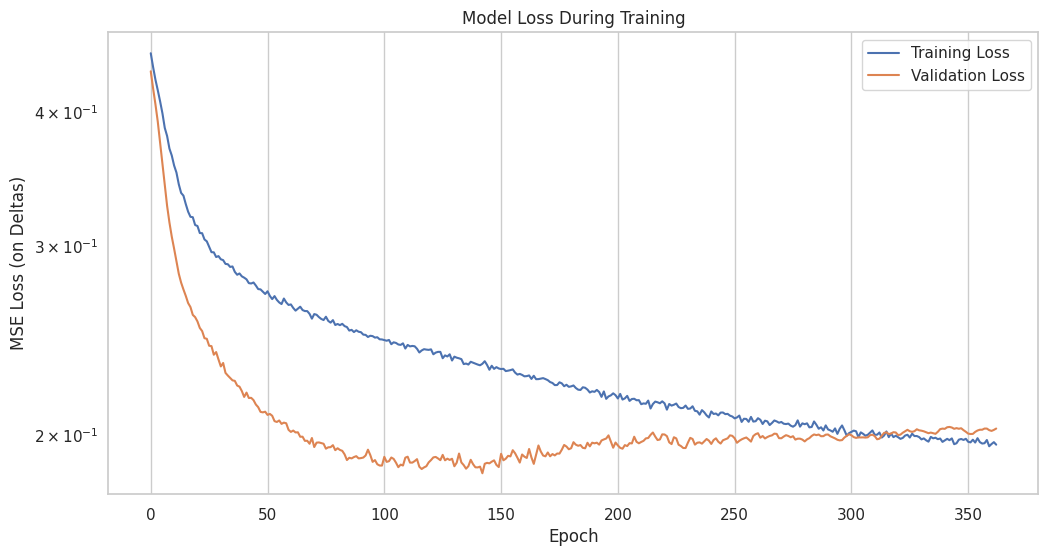

In [35]:
# Reload the best saved model weights if available.
best_model_path = 'best_model_pytorch.pth'
if os.path.exists(best_model_path):
    try:
        print(f"Loading best model weights from {best_model_path}")
        model.load_state_dict(torch.load(best_model_path))
    except Exception as e:
        print(f"Error loading best model weights: {e}. Using last state.")
else:
    print("Best model file not found. Using model state from end of training.")

# Plot the training and validation loss history.
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (on Deltas)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

### Generating Predictions on the Test Set
Now that we have our trained model, it's time to evaluate its performance on the test set of movies. This step generates predictions for all test movies and collects the necessary data for detailed evaluation.

In this step, we:

1. **Set up prediction storage**:
   - Initialize lists to store predicted delta sequences
   - Track movie IDs to match predictions with actuals
   - Collect actual delta values and attention masks for comparison

2. **Set model to evaluation mode**:
   - This disables dropout and batch normalization updates

3. **Generate predictions batch by batch**:
   - Iterate through the test loader with a progress bar
   - Move input data to the appropriate device (GPU/CPU)
   - Keep targets and masks on CPU for easier comparison
   - Run forward pass through the model without gradient tracking
   - Store predictions, actual values, masks, and movie IDs

This prediction phase transforms our trained model into concrete forecasts for the test movies' future box office performance. The careful organization of predictions, targets, and masks ensures we can properly evaluate how well our model generalizes to unseen movies.

In [41]:
# Evaluating the Model

# Generate predictions on the test set
model.eval()
all_pred_delta_log_seq = []
all_test_movie_ids_ordered = []
all_actual_delta_log_seq = []
all_actual_masks = []

print("Generating predictions on the test set...")
with torch.no_grad():
    test_pbar_eval = tqdm(test_loader, desc="Evaluating Test Set", leave=False)
    for batch in test_pbar_eval:
        # Move necessary inputs to device
        num_static = batch['num_static'].to(device)
        cat_static = [c.to(device) for c in batch['cat_static']]
        known_seq = batch['known_seq'].to(device)
        decoder_base = batch['decoder_base'].to(device)
        positions = batch['positions'].to(device)
        # Keep target and mask on CPU to store comparisons
        target_delta = batch['target_delta']
        mask = batch['mask']
        movie_ids = batch['movie_ids']

        predictions = model(num_static, cat_static, known_seq, decoder_base, positions)
        all_pred_delta_log_seq.append(predictions.cpu().numpy())
        all_test_movie_ids_ordered.extend(movie_ids)
        all_actual_delta_log_seq.append(target_delta.numpy())
        all_actual_masks.append(mask.numpy())

Generating predictions on the test set...


### Evaluating Prediction Quality at the Delta Level
Before we reconstruct full revenue predictions, we should first check how well our model is predicting the day-to-day changes in box office revenue. Since our model directly outputs these delta predictions, this serves as a sanity check on the raw model outputs.

In this step, we:

1. **Consolidate batch predictions**: 
   - Concatenate the predictions and actual values collected during the test phase
   - Combine all test masks for proper evaluation

2. **Calculate MSE on delta predictions**:
   - Compute squared error between predicted and actual deltas
   - Apply the mask to only include valid (non-padded) time steps
   - Calculate the mean over all valid predictions

This delta-level evaluation gives us a pure measure of the model's accuracy on its direct outputs, without the compounding effects that occur when reconstructing the full revenue sequence. A good mean squared error at this level indicates that the model has successfully learned the patterns of day-to-day changes in box office performance.

In [37]:
# Concatenate batch outputs
y_pred_delta_log_seq = np.concatenate(all_pred_delta_log_seq, axis=0)   # (n_test_total, N_DAYS_PREDICT)
y_actual_delta_log_seq = np.concatenate(all_actual_delta_log_seq, axis=0)  # (n_test_total, N_DAYS_PREDICT)
y_actual_mask = np.concatenate(all_actual_masks, axis=0)   # (n_test_total, N_DAYS_PREDICT)

# Sanity Check: Calculate MSE on delta predictions using the valid (non-padded) steps only
delta_loss_per_element = (y_pred_delta_log_seq - y_actual_delta_log_seq) ** 2
masked_delta_loss = delta_loss_per_element * y_actual_mask
num_valid_deltas = y_actual_mask.sum()
if num_valid_deltas > 0:
    mse_on_deltas = masked_delta_loss.sum() / num_valid_deltas
    print(f"Sanity Check: MSE Loss on test set DELTAS: {mse_on_deltas:.4f}")

Sanity Check: MSE Loss on test set DELTAS: 0.1843


### Reconstructing Absolute Revenue Predictions
Since our model predicts daily changes in log-transformed box office revenue, we need to reconstruct the absolute daily revenue values for meaningful evaluation and visualization. This process involves converting from predicted deltas to absolute values in the original scale.

In this step, we:

1. **Create arrays for reconstructed values**: Set up storage for our reconstructed predictions

2. **Loop through each test movie**:
   - Retrieve the movie's unique identifier
   - Look up the last known log gross value (day 14)
   - Starting from this known value, iteratively add the predicted deltas
   - For each day in the prediction window, update the cumulative total

3. **Transform back to dollar scale**:
   - Apply expm1() to reverse the log1p transformation
   - Ensure no negative predictions by applying a floor of 0
   - Replace any NaN values with 0

4. **Retrieve and process actual values**:
   - Collect the original log gross sequences for comparison
   - Track the actual length of each movie's run
   - Create padded arrays with the same shape as predictions
   - Transform actual values back to dollar scale

This reconstruction process essentially "plays forward" the predicted daily changes to build up the complete forecast. It handles the challenge of converting from relative changes (which are easier to model) to absolute values (which are more interpretable and useful for evaluation).

In [38]:
# Reconstruct the absolute log gross by adding the predicted deltas to the last known log gross
num_test_samples = y_pred_delta_log_seq.shape[0]
y_pred_rec_log_seq = np.zeros_like(y_pred_delta_log_seq)

for i in range(num_test_samples):
    movie_id = all_test_movie_ids_ordered[i]
    if movie_id not in last_known_log_gross_history:
        print(f"Warning: Cannot find last known gross for test movie {movie_id}. Filling prediction with NaNs.")
        y_pred_rec_log_seq[i, :] = np.nan
        continue
    last_known_lg = last_known_log_gross_history[movie_id]
    current_pred_lg = last_known_lg
    for j in range(N_DAYS_PREDICT):
        delta_pred = y_pred_delta_log_seq[i, j]
        current_pred_lg += delta_pred
        y_pred_rec_log_seq[i, j] = current_pred_lg

# Inverse-transform log gross to actual dollar scale
y_pred_seq = np.expm1(y_pred_rec_log_seq)
y_pred_seq = np.maximum(y_pred_seq, 0)
y_pred_seq = np.nan_to_num(y_pred_seq, nan=0.0)

# Retrieve the actual log gross sequences for the test movies
y_test_seq_log_list = []
actual_lengths_test = []
for mid in all_test_movie_ids_ordered:
    if mid in original_target_gross_log_sequences:
        seq = original_target_gross_log_sequences[mid]
        y_test_seq_log_list.append(seq)
        actual_lengths_test.append(len(seq))
    else:
        print(f"Warning: Missing original log gross sequence for test movie {mid}. Appending empty.")
        y_test_seq_log_list.append(np.array([]))
        actual_lengths_test.append(0)

# Pad the actual log gross sequences to N_DAYS_PREDICT for comparison
y_test_log_padded = np.zeros_like(y_actual_delta_log_seq)
for i in range(num_test_samples):
    length = actual_lengths_test[i]
    if length > 0:
        seq = y_test_seq_log_list[i]
        y_test_log_padded[i, :length] = seq
    y_test_log_padded[i, length:] = PAD_VALUE  # PAD_VALUE is 0

# Inverse-transform actual log gross to get dollar values
y_test_seq = np.expm1(y_test_log_padded)
y_test_seq = np.maximum(y_test_seq, 0)


### Calculating Performance Metrics
With our predictions reconstructed in dollar terms, we can now calculate standard regression metrics to evaluate our model's forecasting performance. This gives us quantitative measures of how accurately our model predicts future box office revenue.

In this step, we:

1. **Prepare for metric calculation**:
   - Create a mask to identify valid time steps (non-padded values)
   - Flatten predictions and actual values for easier processing
   - Apply the mask to get only valid predictions and targets

2. **Define robust metric functions**:
   - Create a safe MAPE function that handles zero or near-zero values
   - Define a safe Median APE function for reduced sensitivity to outliers

3. **Calculate multiple evaluation metrics**:
   - RMSE (Root Mean Squared Error): Measures overall error magnitude
   - MAE (Mean Absolute Error): Measures average absolute difference
   - MAPE (Mean Absolute Percentage Error): Measures relative error
   - Median APE: A robust measure of typical relative error

4. **Report the results**:
   - Print each metric with appropriate formatting
   - Include units ($ for absolute metrics, % for relative metrics)

These comprehensive metrics give us a well-rounded view of our model's performance. RMSE and MAE tell us about absolute error in dollar terms, while MAPE and Median APE tell us about relative error as a percentage of the actual value. The latter are particularly important for box office data where the absolute dollar amounts can vary widely across movies.

In [39]:
# Calculate evaluation metrics on the valid (non-padded) steps only
mask_valid_steps = y_actual_mask.astype(bool)
mask_flat = mask_valid_steps.flatten()
y_pred_flat = y_pred_seq.flatten()
y_test_flat = y_test_seq.flatten()
y_pred_valid = y_pred_flat[mask_flat]
y_test_valid = y_test_flat[mask_flat]

if len(y_test_valid) == 0:
    print("WARNING: No valid test samples found for metric calculation. Skipping metrics.")
    rmse_overall, mae_overall, mape_overall, medape_overall = np.nan, np.nan, np.nan, np.nan
else:
    print(f"Evaluating metrics on {len(y_test_valid)} valid time steps.")
    def safe_mape(y_true, y_pred, epsilon=1e-6):
        y_true_safe = np.maximum(np.abs(y_true), epsilon)
        ape = np.abs((y_true - y_pred) / y_true_safe)
        return np.mean(ape[np.isfinite(ape)]) * 100 if np.isfinite(ape).any() else np.nan

    def safe_median_ape(y_true, y_pred, epsilon=1e-6):
        y_true_safe = np.maximum(np.abs(y_true), epsilon)
        ape = np.abs((y_true - y_pred) / y_true_safe)
        return np.median(ape[np.isfinite(ape)]) * 100 if np.isfinite(ape).any() else np.nan

    rmse_overall = np.sqrt(mean_squared_error(y_test_valid, y_pred_valid))
    mae_overall = mean_absolute_error(y_test_valid, y_pred_valid)
    mape_overall = safe_mape(y_test_valid, y_pred_valid)
    medape_overall = safe_median_ape(y_test_valid, y_pred_valid)

    print(f"\nOverall Evaluation (Reconstructed Gross):")
    print(f"  RMSE:       {rmse_overall:.2f}")
    print(f"  MAE:        {mae_overall:.2f}")
    print(f"  MAPE:       {mape_overall:.2f}%")
    print(f"  Median APE: {medape_overall:.2f}%")

Evaluating metrics on 288 valid time steps.

Overall Evaluation (Reconstructed Gross):
  RMSE:       353646.35
  MAE:        120856.43
  MAPE:       61.11%
  Median APE: 34.51%


### Visualizing Forecasts for Sample Movies
While aggregate metrics give us an overall assessment of model performance, visualizing individual forecasts helps us understand the model's behavior on specific movies. These visualizations provide intuitive insight into how well our model captures different box office patterns.

In this step, we:

1. **Select a sample of test movies**:
   - Determine how many sample plots to create (up to 20)
   - Randomly select movies from the test set

2. **For each selected movie**:
   - Check if we have actual data available for that movie
   - Extract the actual performance data for the prediction period
   - Extract the corresponding model predictions
   - Determine the actual run length of the movie

3. **Create comparative plots**:
   - Define the x-axis as days since release (starting from day 15)
   - Plot actual gross revenue as a blue line with markers
   - Plot predicted gross revenue as a red dashed line with markers
   - Add a descriptive title with the movie ID
   - Label axes appropriately
   - Create tick marks at sensible intervals
   - Add a legend to distinguish actual vs predicted values
   - Apply grid lines for better readability

These visualizations let us see:
- How closely the predicted trajectory follows the actual one
- Whether the model captures weekend patterns correctly
- If the model accurately predicts the slope of decay
- Where the model makes its largest errors

By examining these sample forecasts, we can better understand our model's strengths and limitations in predicting future box office performance.

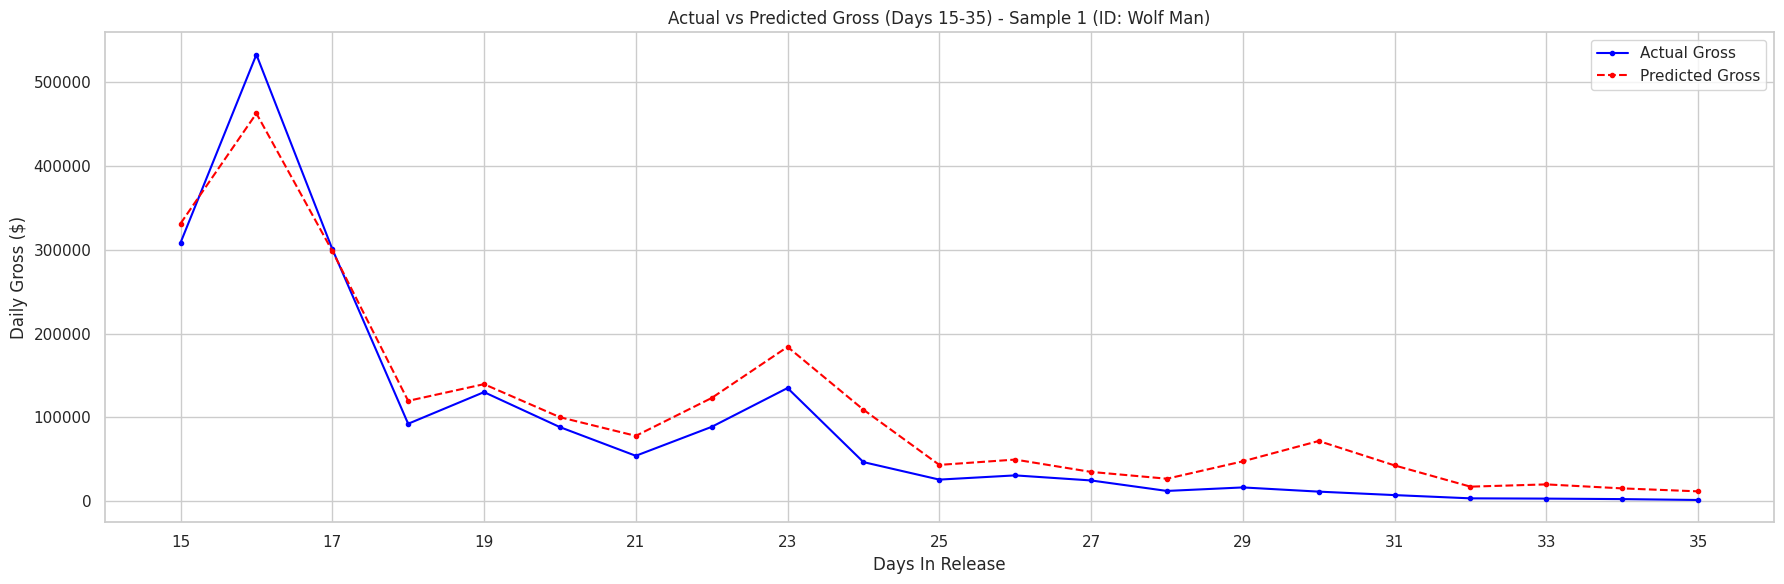

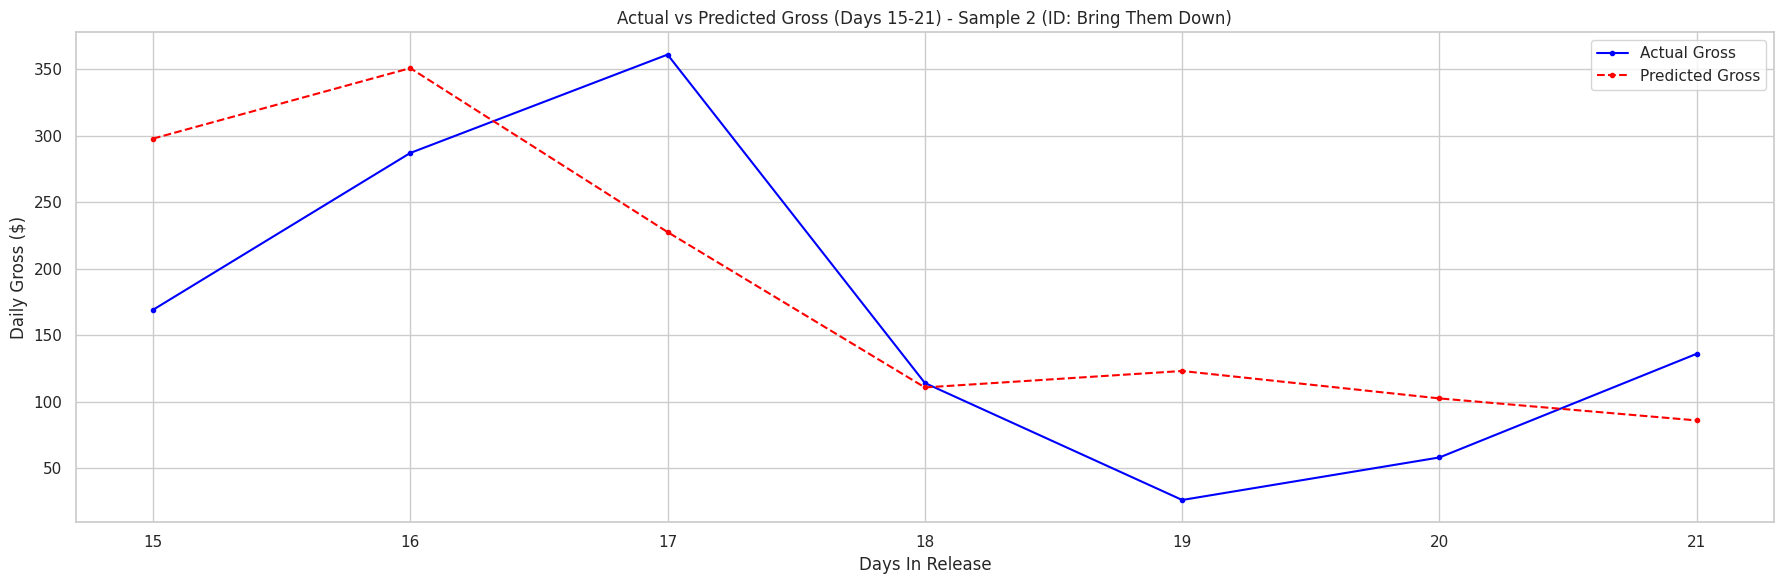

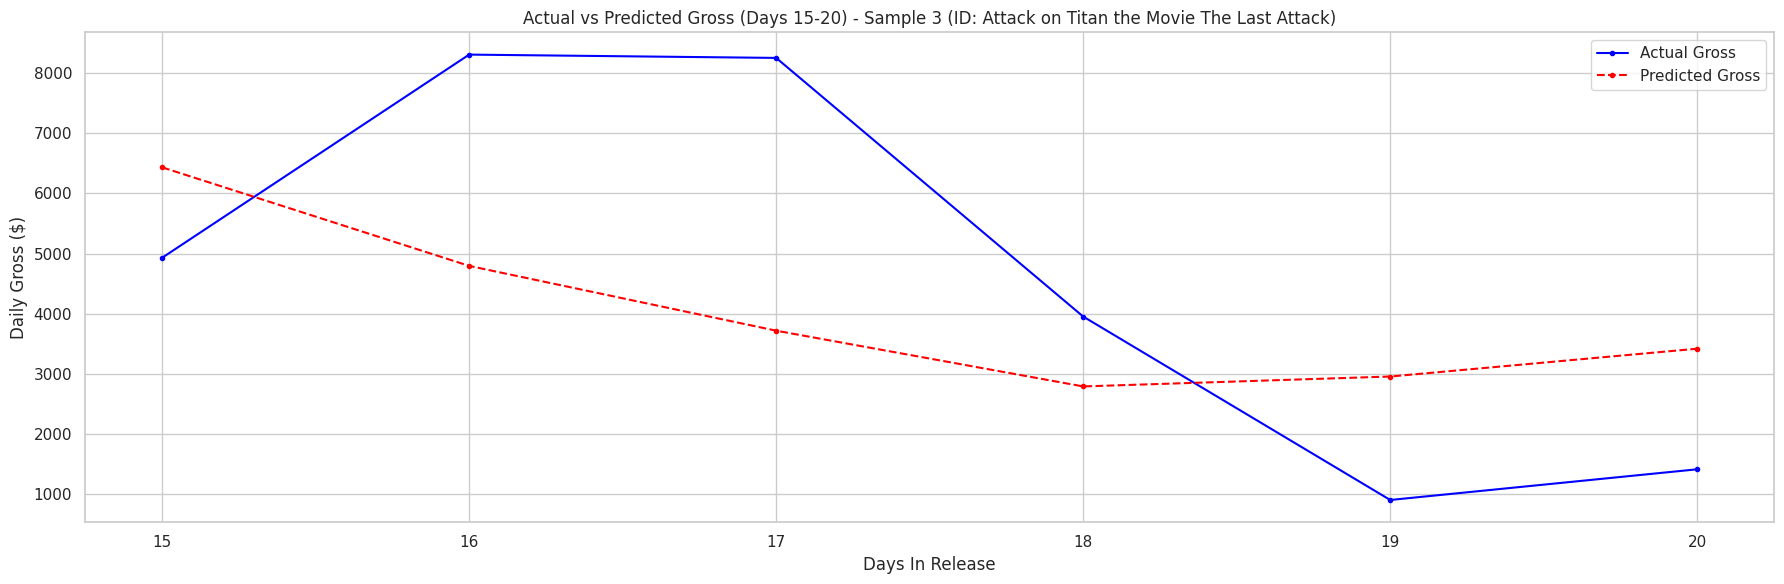

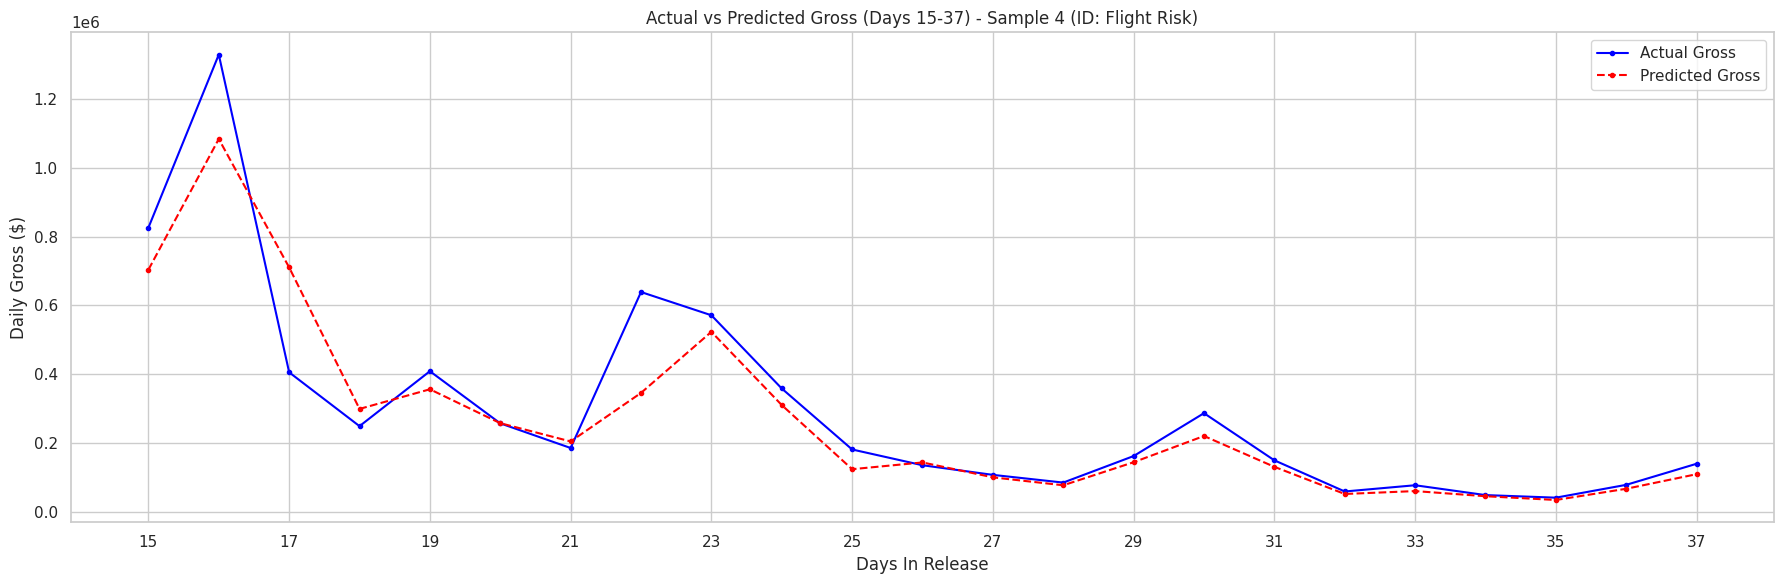

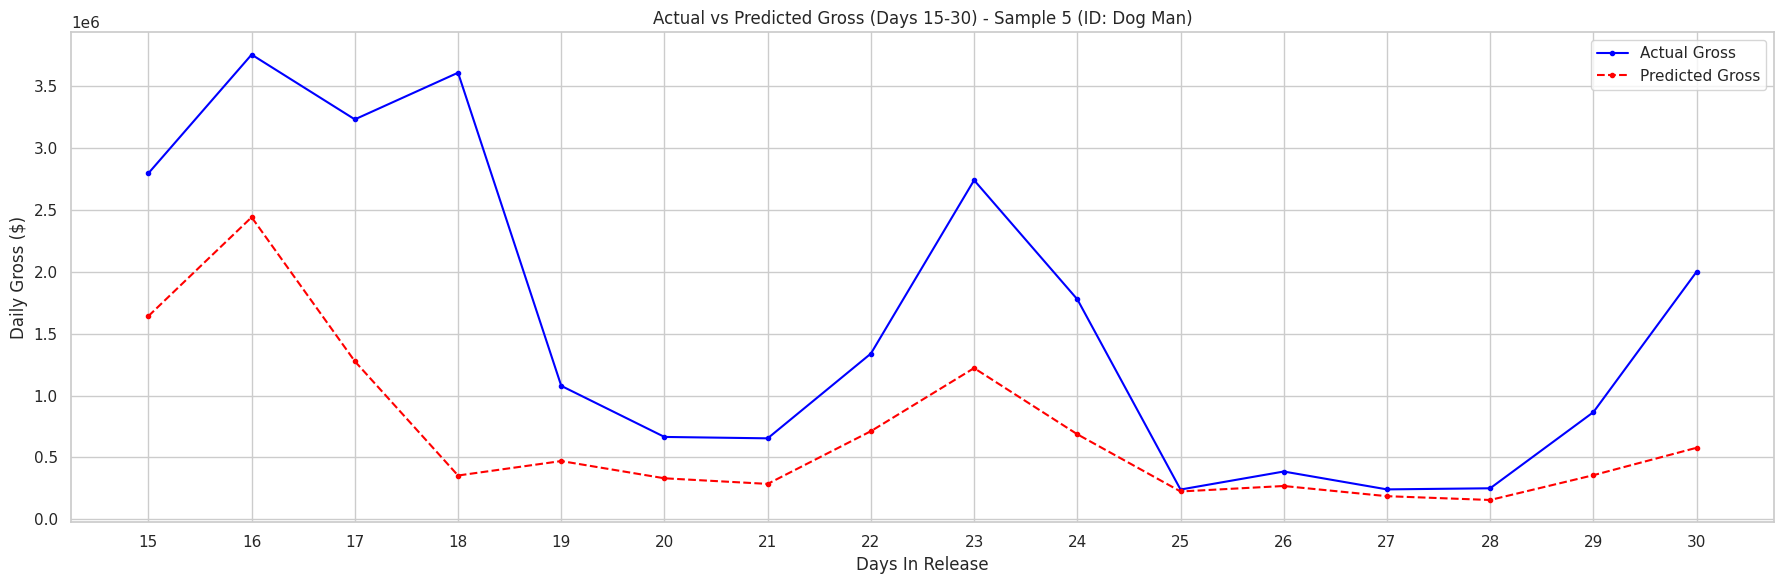

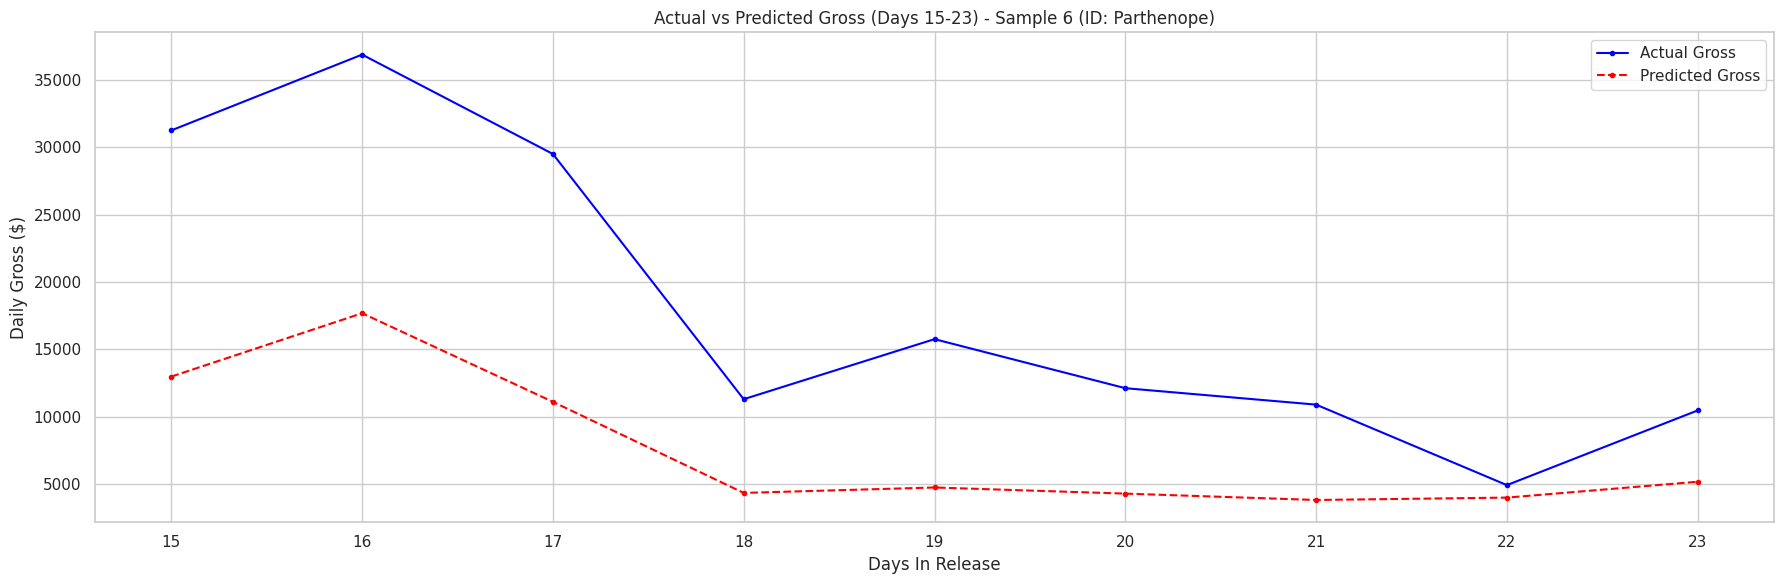

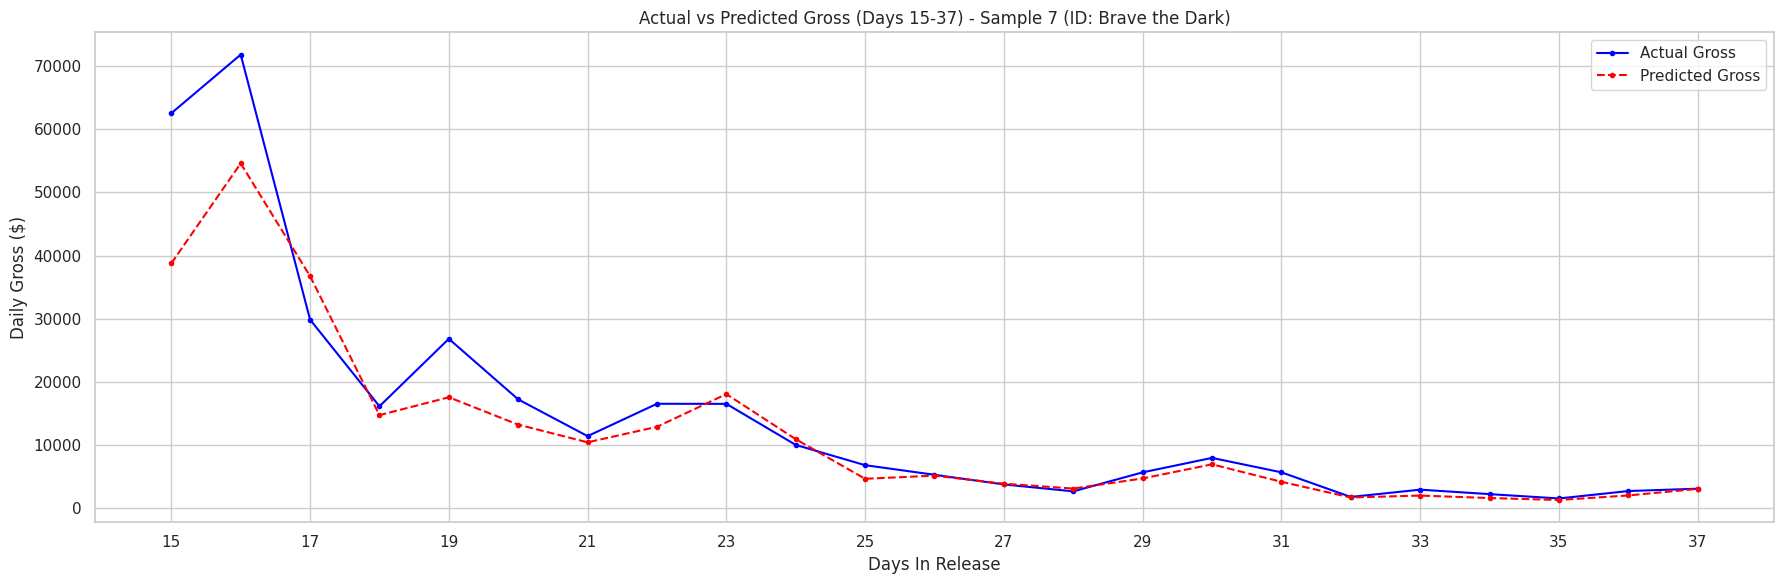

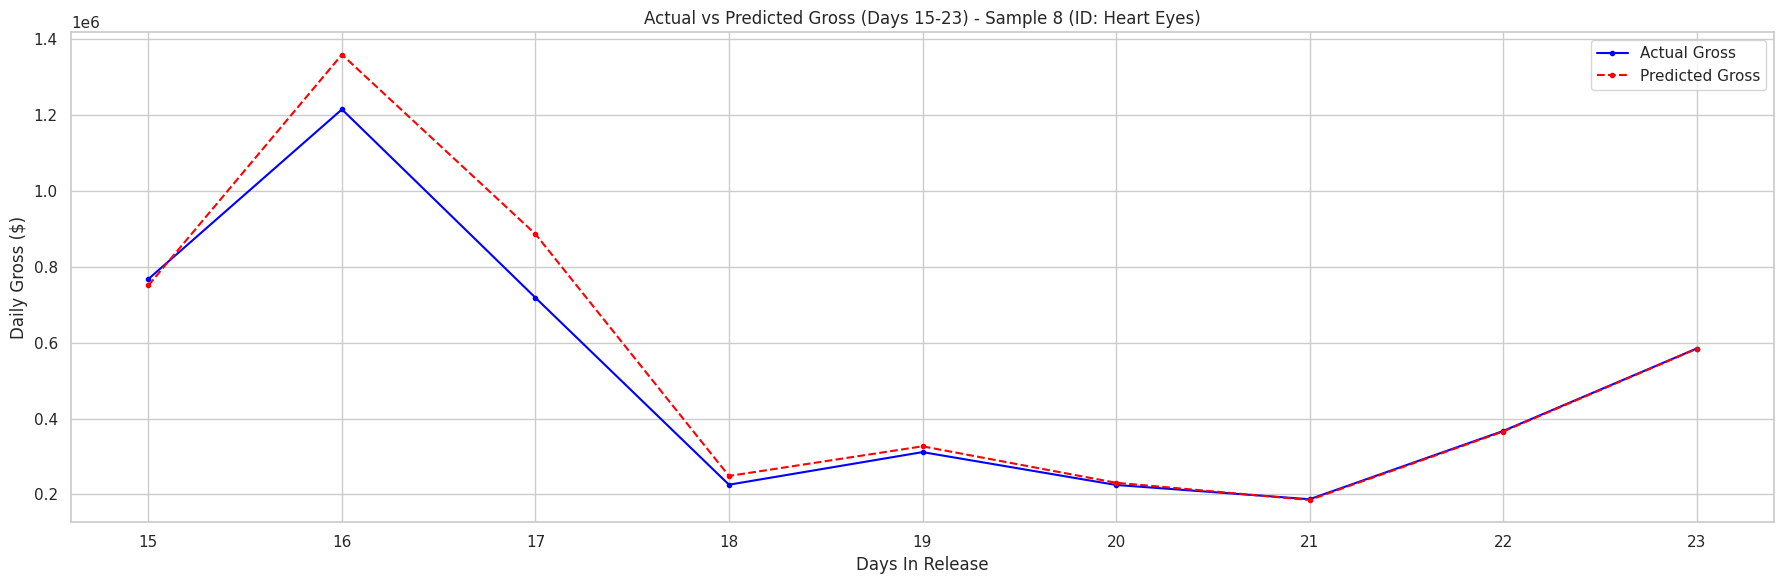

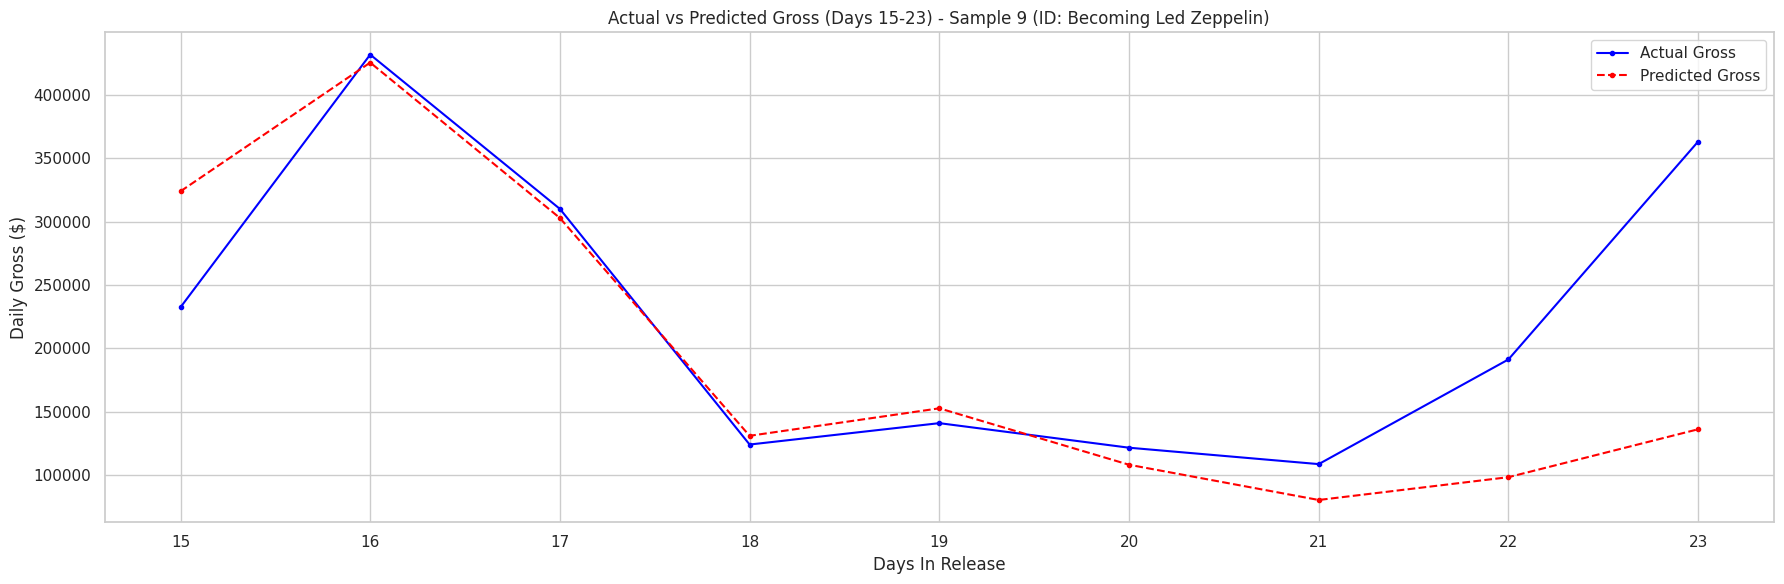

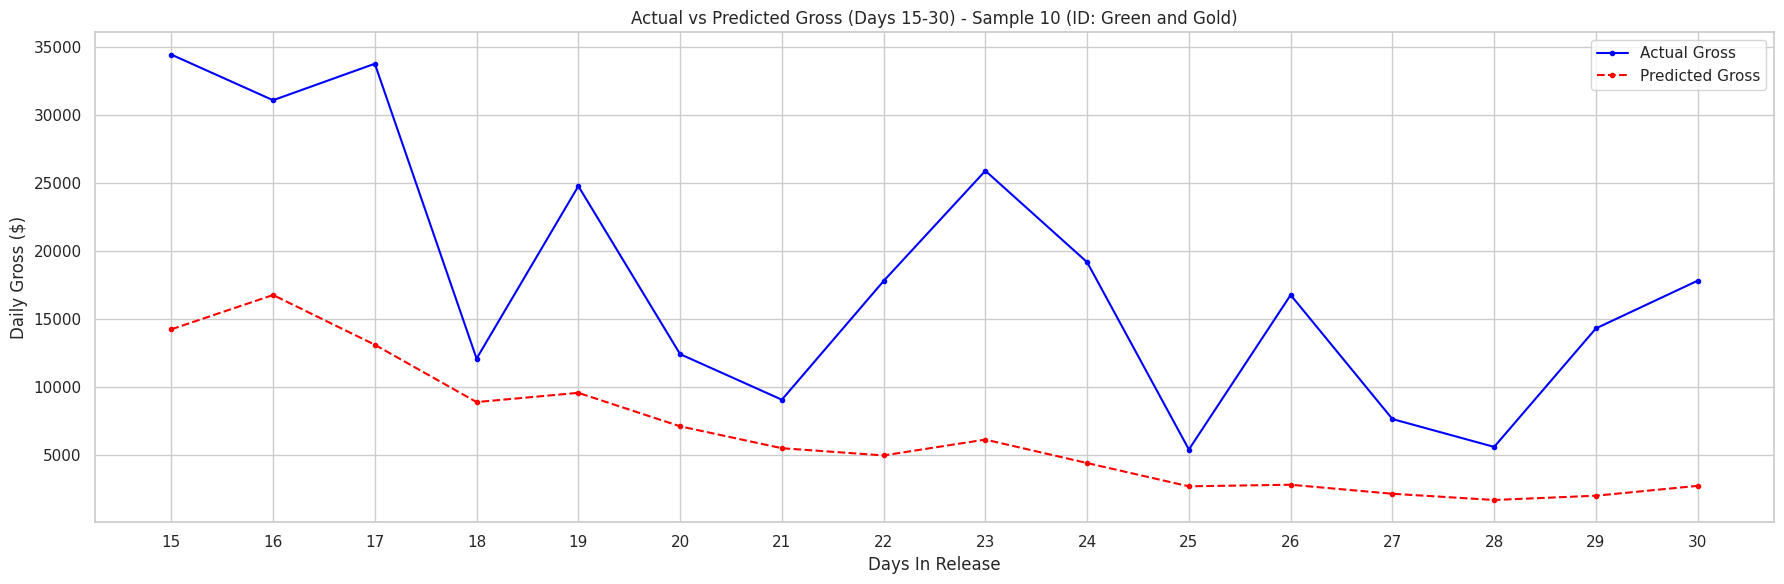

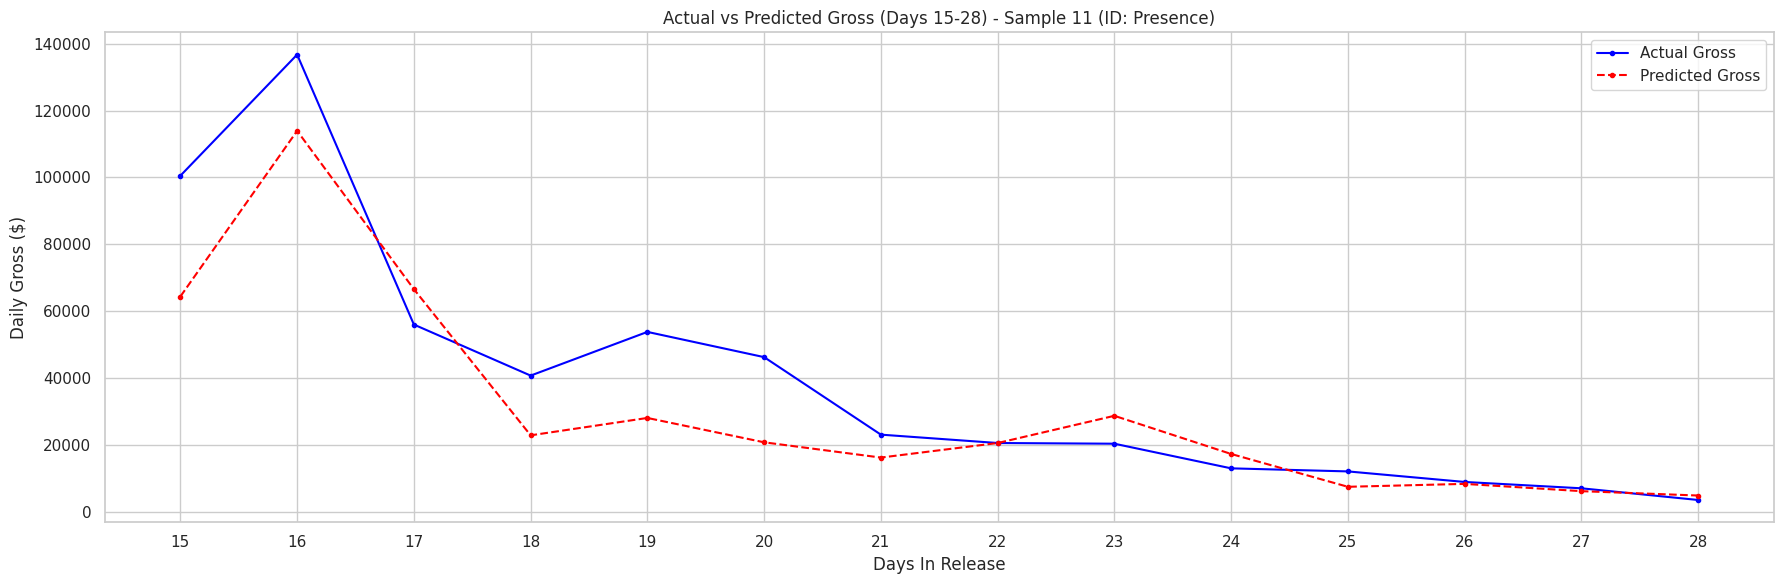

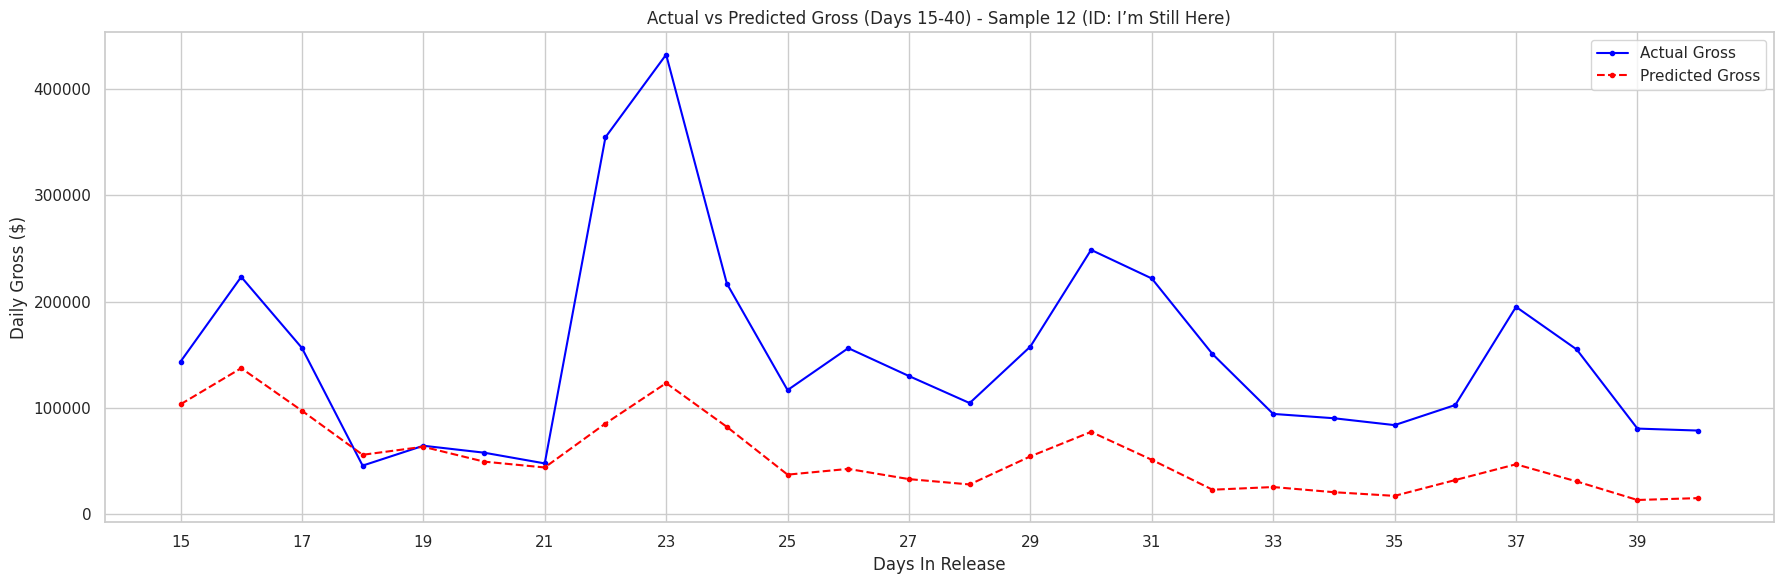

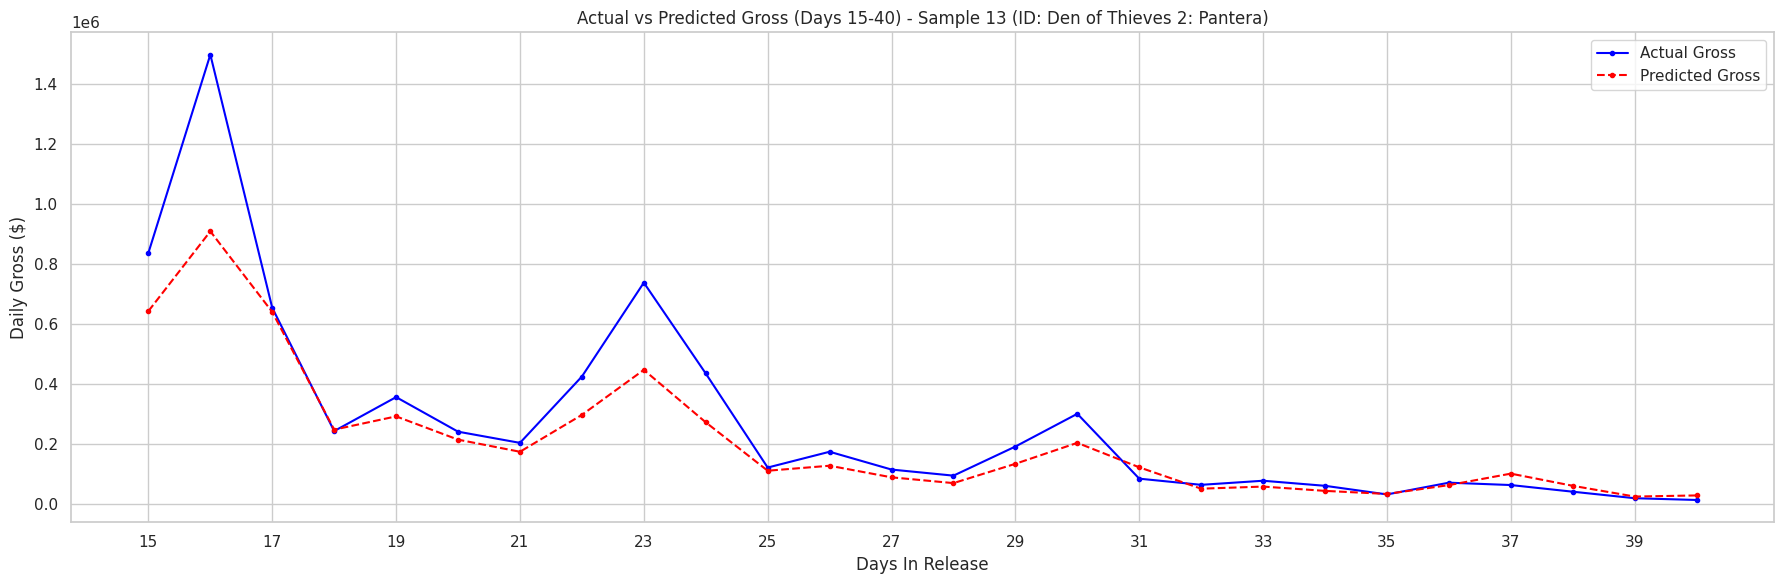

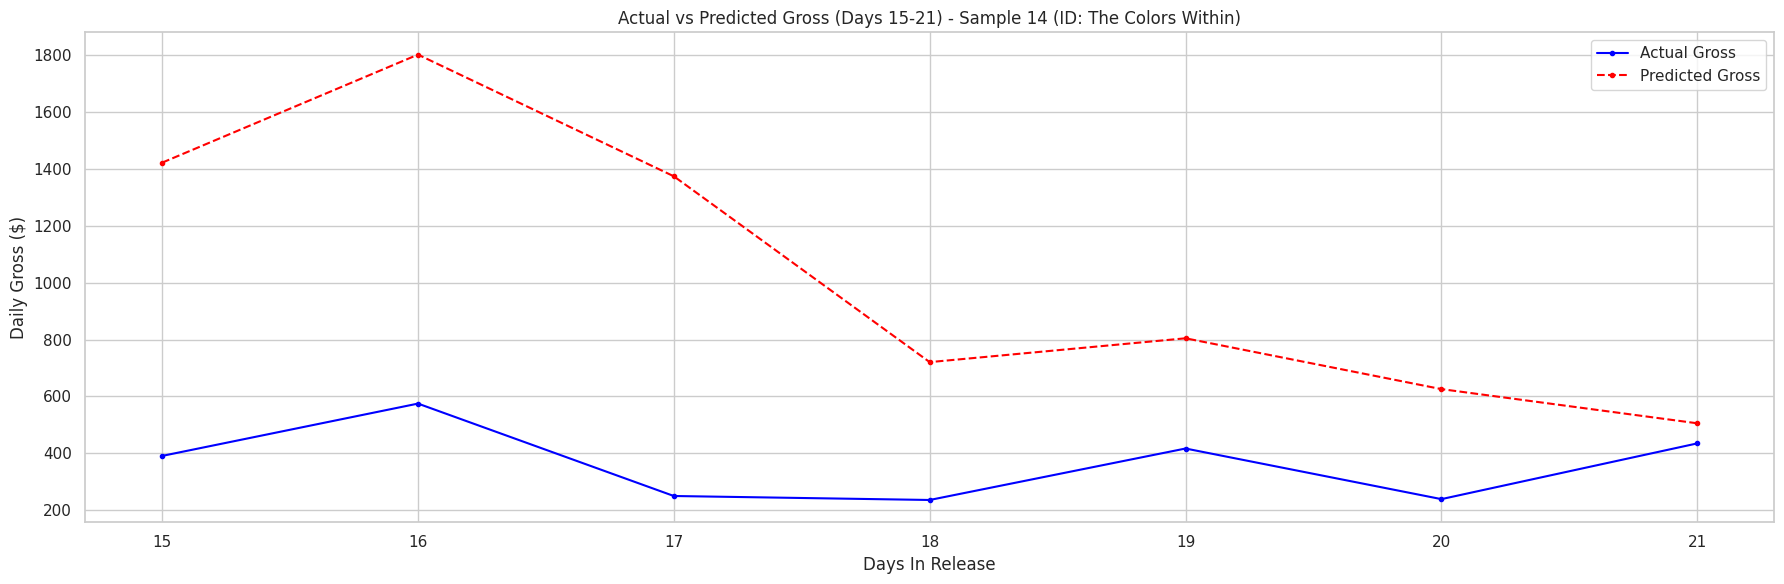

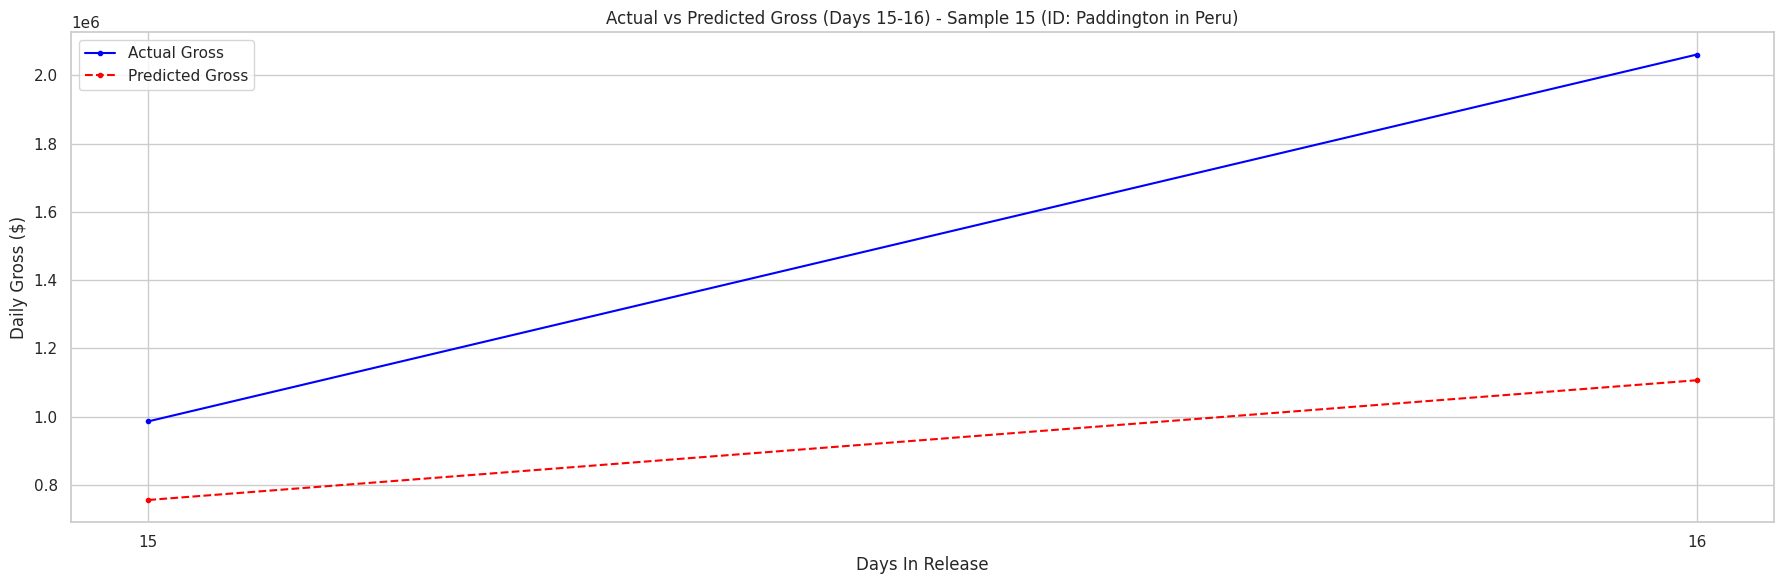

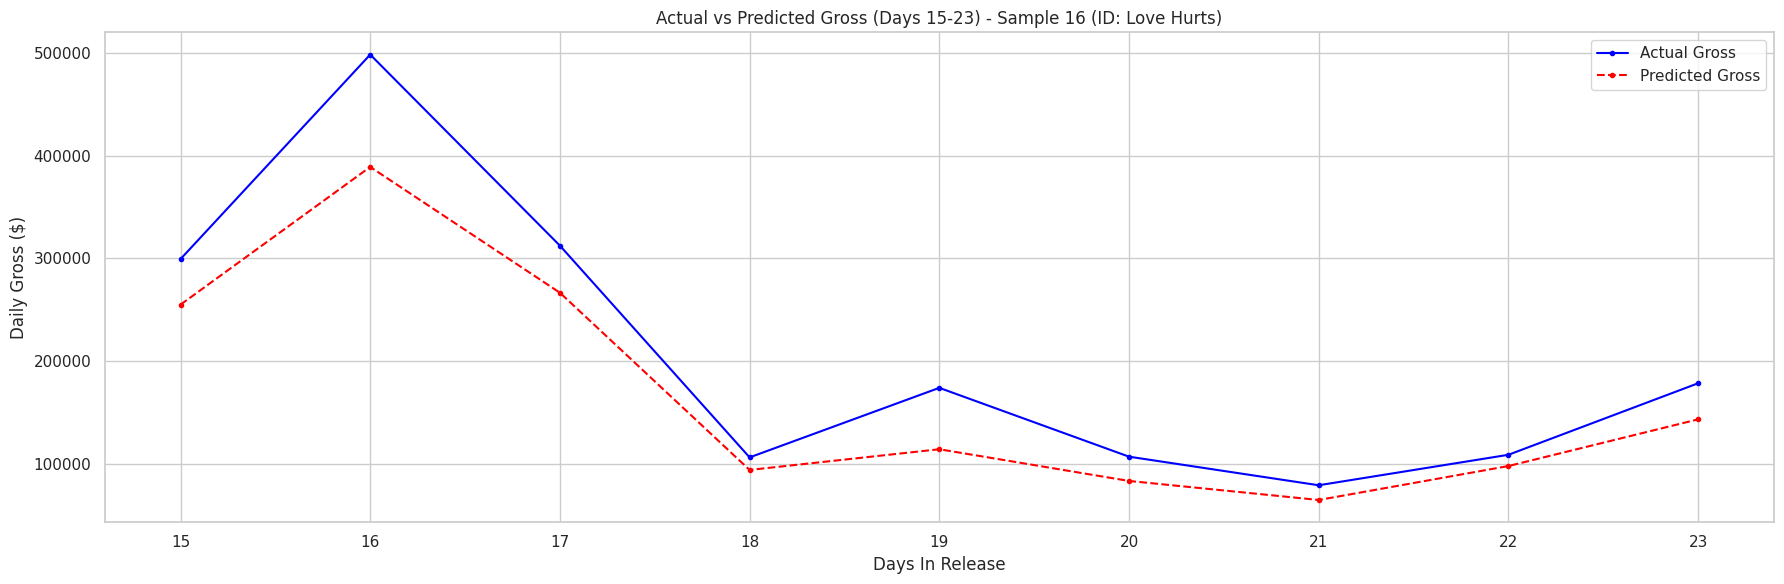

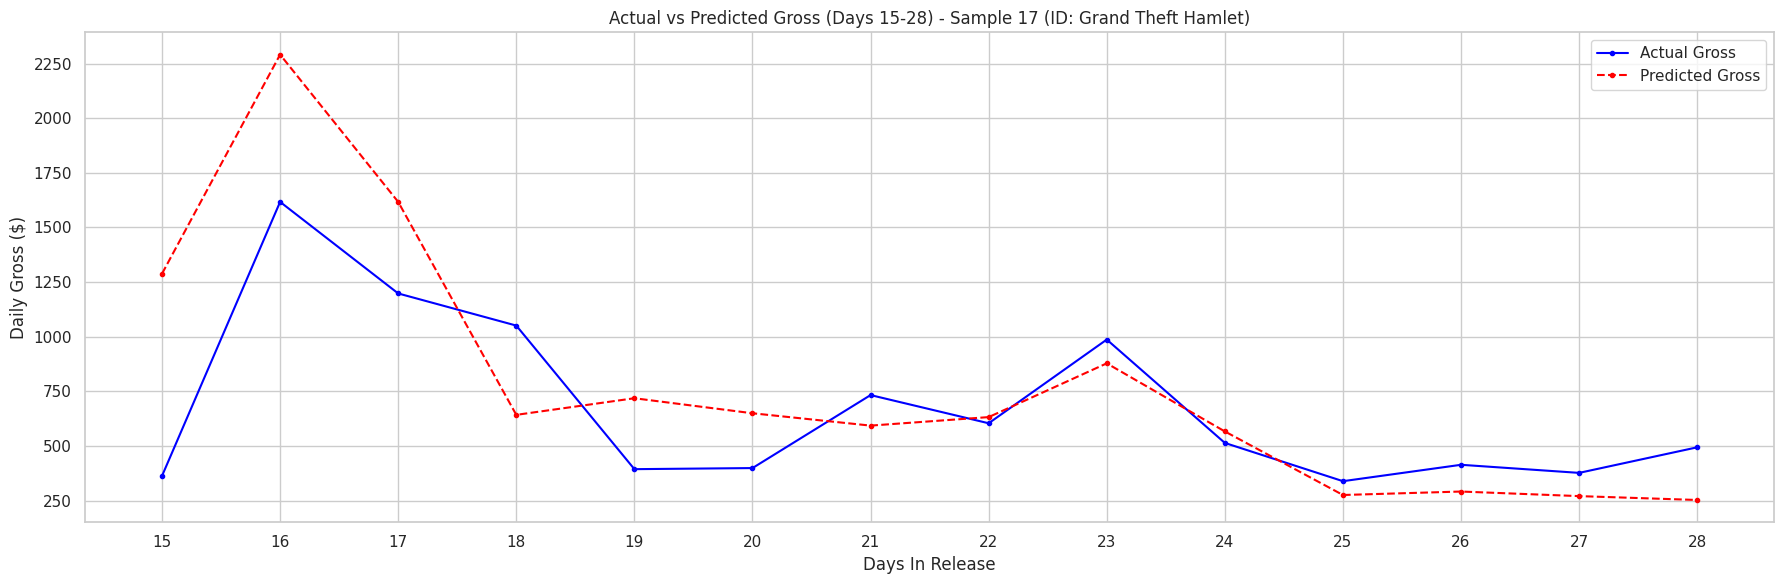

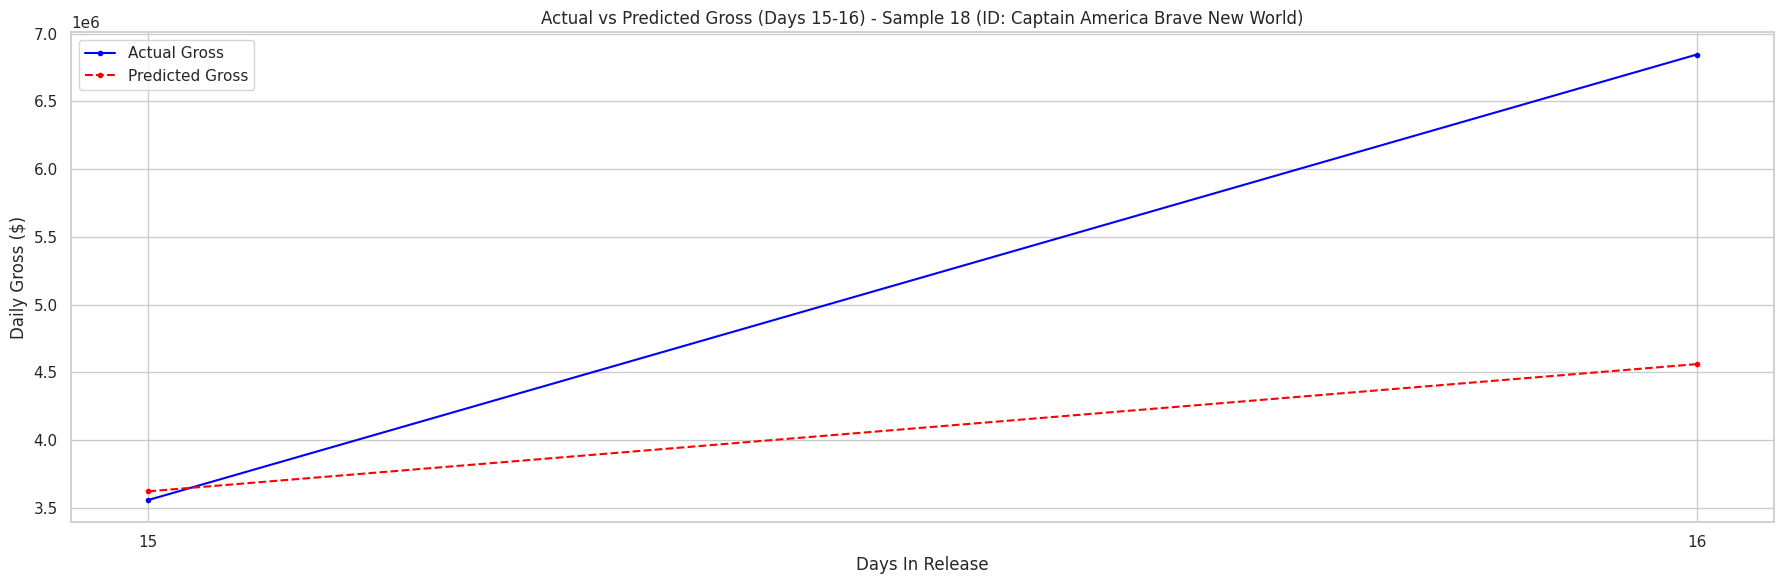

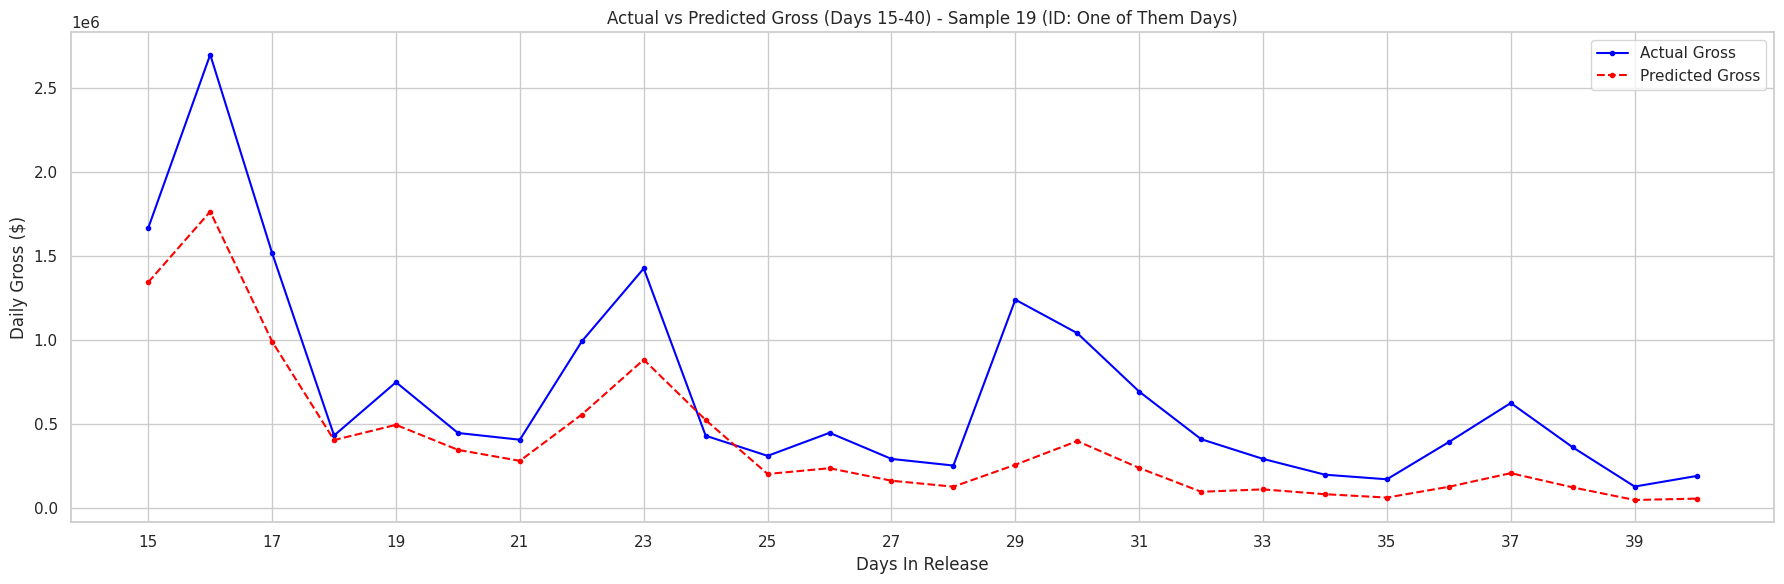

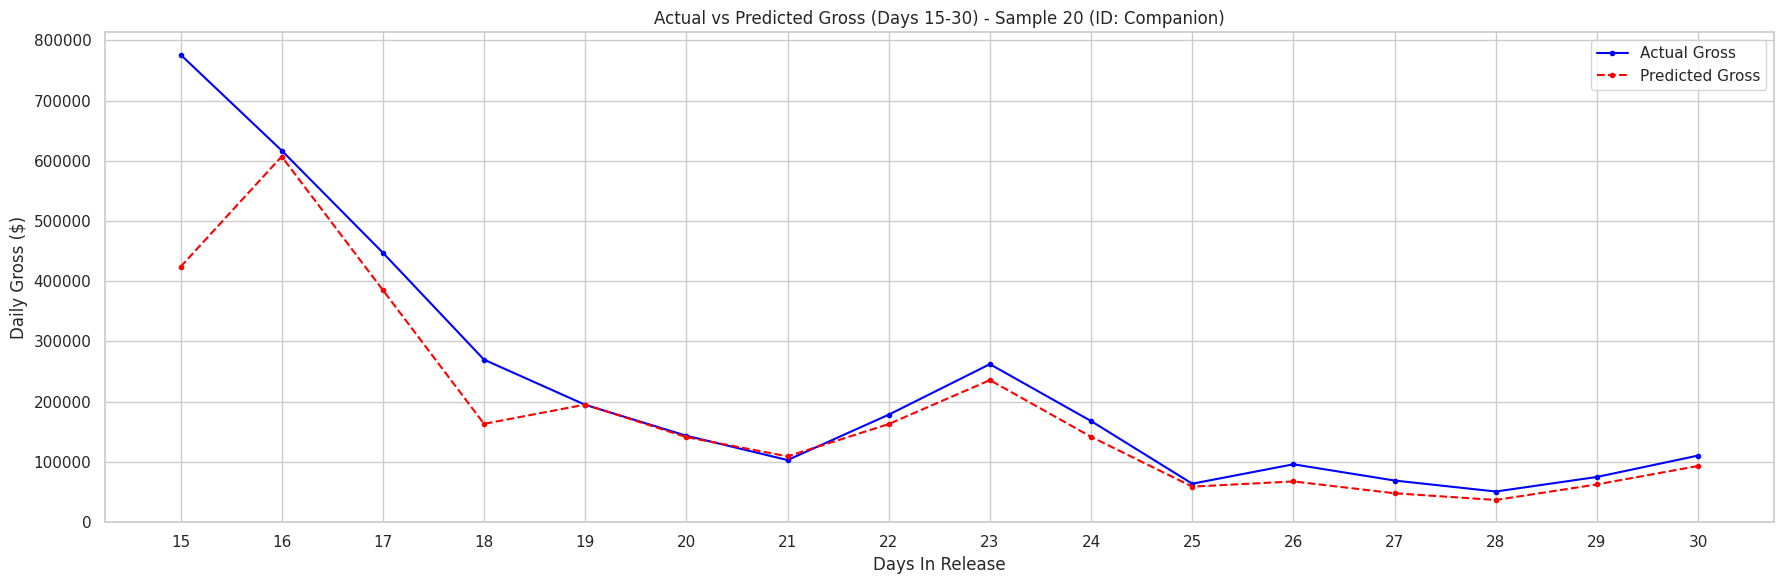

--- End of PyTorch Script ---


In [ ]:
# Plot sample predictions for a few test movies.
num_samples_to_plot = min(NUM_SAMPLE_PLOTS, len(all_test_movie_ids_ordered))
if num_samples_to_plot > 0:
    available_indices = list(range(len(all_test_movie_ids_ordered)))
    sample_indices_in_test = random.sample(available_indices, num_samples_to_plot)

    for k, test_idx in enumerate(sample_indices_in_test):
        actual_movie_id = all_test_movie_ids_ordered[test_idx]
        actual_len = int(y_actual_mask[test_idx].sum())
        if actual_len == 0:
            print(f"Skipping plot for sample {k+1} (ID: {actual_movie_id}): No actual data available.")
            continue

        plt.figure(figsize=(18, 6))
        days_axis = range(N_DAYS_KNOWN + 1, N_DAYS_KNOWN + 1 + actual_len)
        actual_plot_data = y_test_seq[test_idx, :actual_len]
        predicted_plot_data = y_pred_seq[test_idx, :actual_len]

        plt.plot(days_axis, actual_plot_data, label='Actual Gross', marker='.', linewidth=1.5, color='blue')
        plt.plot(days_axis, predicted_plot_data, label='Predicted Gross', marker='.', linestyle='--', linewidth=1.5, color='red')
        plt.title(f'Actual vs Predicted Gross (Days {N_DAYS_KNOWN+1}-{N_DAYS_KNOWN+actual_len}) - Sample {k+1} (ID: {actual_movie_id})')
        plt.xlabel('Days In Release')
        plt.ylabel('Daily Gross ($)')
        tick_step = max(1, actual_len // 10)
        start_tick = N_DAYS_KNOWN + 1
        end_tick = N_DAYS_KNOWN + actual_len
        tick_values = np.arange(start_tick, end_tick + 1, tick_step).astype(int)
        plt.xticks(ticks=tick_values)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("No test samples available for plotting.")

